## XGB on modified data

#### Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance
from matplotlib import pyplot as plt
import xgboost as xgb
import gc
import sys
import pickle


/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: Depre

### Parameters:

In [2]:

run_title = "Extraction_I"

Word_Notes = "added bureau and prev app features, Weights v2.0"
rounds = 1000

par = {  'eta': .01,
         'gamma': 6.3324,
         'max_depth': 29,
         'min_child_weight': 19,
          'colsample_byree': .8315,
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'n_job': 14,
          'booster': 'gbtree',
           'max_delta_step':1.3239,
           'subsample':.995
      }

In [3]:
Output_Name = run_title + ".csv"

### Data

In [4]:
#Not reading in Test yet to avoid memory issues
data_path = "/home/matia_alexander/data/"
output_path = "/home/matia_alexander/output/"
application_train = pd.read_csv(data_path + "train_modified.csv")
application_test = pd.read_csv(data_path + "test_modified.csv")

## Feature Selection

In [6]:
#Test result of keeping only MEDIAN imputed columns when median-imputed columns exist

Feature_Set = [i for i in application_train.columns]
Feature_Set = [i for i in application_train.columns 
              if '.trmean' not in i
              if '.trmode' not in i]
Feature_Set = [i for i in Feature_Set
              if not (i + '.trmedian') in Feature_Set]

Feature_Set_test = [i for i in Feature_Set
                   if i not in ['TARGET', 'fold', 'Weights']]

In [7]:
application_train = application_train.loc[:,Feature_Set]
application_test = application_test.loc[:, Feature_Set_test]

In [8]:
non_numeric_cols = []
for i in application_train.columns:
    if application_train[i].dtype.name == "object":
        non_numeric_cols.append(i)

#one-hot encode categoricals in train and test sets

#Build dataset of only non-numerics
application_train_non_numeric = application_train.loc[:,non_numeric_cols]
#Remove non-encoded variables from original dataset
application_train.drop(columns = non_numeric_cols, inplace = True)
#Convert non-numerics into dummies/ one-hot encode
application_train_non_numeric_dummies = pd.get_dummies(application_train_non_numeric)
#Join encoded dataset back with original
application_train = pd.concat([application_train, application_train_non_numeric_dummies], axis = 1)


non_numeric_cols = []
for i in application_test.columns:
    if application_test[i].dtype.name == "object":
        non_numeric_cols.append(i)

#one-hot encode categoricals in train and test sets

#Build dataset of only non-numerics
application_test_non_numeric = application_test.loc[:,non_numeric_cols]
#Remove non-encoded variables from original dataset
application_test.drop(columns = non_numeric_cols, inplace = True)
#Convert non-numerics into dummies/ one-hot encode
application_test_non_numeric_dummies = pd.get_dummies(application_test_non_numeric)
#Join encoded dataset back with original
application_test = pd.concat([application_test, application_test_non_numeric_dummies], axis = 1)








In [9]:
train_cols = [i for i in application_train.columns]
test_cols = [i for i in application_test.columns]
train_not_test = [i for i in train_cols if i not in test_cols]
test_not_train = [i for i in test_cols if i not in train_cols]

print("Columns in Train but not Test: \n" + str(train_not_test))
print("Columns in Test but not Train: \n" + str(test_not_train))

Columns in Train but not Test: 
['TARGET', 'fold', 'Weights', 'CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown']
Columns in Test but not Train: 
[]


In [10]:
#Dropping one-hot encoded column expansions that resulted from unique categories
application_train.drop(columns = ["CODE_GENDER_XNA", "NAME_INCOME_TYPE_Maternity leave",
                                 "NAME_FAMILY_STATUS_Unknown"], inplace = True)

In [11]:
train_cols = [i for i in application_train.columns]
test_cols = [i for i in application_test.columns]
train_not_test = [i for i in train_cols if i not in test_cols]
test_not_train = [i for i in test_cols if i not in train_cols]

#The following must be true going forward:
assert(train_not_test == ['TARGET', 'fold', 'Weights'])
assert(test_not_train == [])
print("Train and Test columns are as expected!")

Train and Test columns are as expected!


In [12]:
del(application_test)

## Train Model

In [ ]:
from sklearn.model_selection import train_test_split
import pickle
X = application_train
y = application_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Train_DMatrix_All = xgb.DMatrix(data = X_train.drop(columns = ["SK_ID_CURR","Weights","fold", "TARGET"]),
                               weight = X_train.Weights,
                               label = y_train)

Valid_DMatrix_All = xgb.DMatrix(data = X_test.drop(columns = ["SK_ID_CURR","Weights","fold", "TARGET"]),
                               weight = X_test.Weights,
                               label = y_test)

watchlist = [(Valid_DMatrix_All, 'eval'), (Train_DMatrix_All, 'train')]

Trained_Model = xgb.train(params = par, 
                          num_boost_round = rounds, 
                          dtrain = Train_DMatrix_All, 
                          evals = watchlist)


[0]	eval-auc:0.56426	train-auc:0.582212
[1]	eval-auc:0.580981	train-auc:0.597393
[2]	eval-auc:0.580992	train-auc:0.597395
[3]	eval-auc:0.581158	train-auc:0.597497
[4]	eval-auc:0.581174	train-auc:0.597474
[5]	eval-auc:0.581316	train-auc:0.597522
[6]	eval-auc:0.581258	train-auc:0.597422
[7]	eval-auc:0.581261	train-auc:0.597361
[8]	eval-auc:0.581364	train-auc:0.597285
[9]	eval-auc:0.581361	train-auc:0.597274
[10]	eval-auc:0.581348	train-auc:0.597146
[11]	eval-auc:0.593756	train-auc:0.609059
[12]	eval-auc:0.593886	train-auc:0.609323
[13]	eval-auc:0.599714	train-auc:0.623538
[14]	eval-auc:0.599804	train-auc:0.623544
[15]	eval-auc:0.607358	train-auc:0.634073
[16]	eval-auc:0.624579	train-auc:0.651458
[17]	eval-auc:0.624733	train-auc:0.651615
[18]	eval-auc:0.624657	train-auc:0.651742
[19]	eval-auc:0.624638	train-auc:0.651967
[20]	eval-auc:0.624652	train-auc:0.652148
[21]	eval-auc:0.624649	train-auc:0.652327
[22]	eval-auc:0.624836	train-auc:0.652674
[23]	eval-auc:0.625068	train-auc:0.652836
[24

[194]	eval-auc:0.713947	train-auc:0.779608
[195]	eval-auc:0.714239	train-auc:0.780454
[196]	eval-auc:0.714648	train-auc:0.781042
[197]	eval-auc:0.714809	train-auc:0.7814
[198]	eval-auc:0.714837	train-auc:0.781601
[199]	eval-auc:0.714904	train-auc:0.781993
[200]	eval-auc:0.715007	train-auc:0.782339
[201]	eval-auc:0.715238	train-auc:0.782863
[202]	eval-auc:0.715353	train-auc:0.783156
[203]	eval-auc:0.715429	train-auc:0.783613
[204]	eval-auc:0.715501	train-auc:0.783881
[205]	eval-auc:0.715641	train-auc:0.784093
[206]	eval-auc:0.716114	train-auc:0.784592
[207]	eval-auc:0.716322	train-auc:0.784976
[208]	eval-auc:0.716741	train-auc:0.785685
[209]	eval-auc:0.716772	train-auc:0.786142
[210]	eval-auc:0.717031	train-auc:0.786489
[211]	eval-auc:0.717192	train-auc:0.786834
[212]	eval-auc:0.717475	train-auc:0.787441
[213]	eval-auc:0.71784	train-auc:0.787912
[214]	eval-auc:0.717839	train-auc:0.788051
[215]	eval-auc:0.718087	train-auc:0.788414
[216]	eval-auc:0.718202	train-auc:0.78868
[217]	eval-auc:

[386]	eval-auc:0.746511	train-auc:0.840965
[387]	eval-auc:0.746622	train-auc:0.841232
[388]	eval-auc:0.746857	train-auc:0.841518
[389]	eval-auc:0.746944	train-auc:0.841733
[390]	eval-auc:0.747094	train-auc:0.842031
[391]	eval-auc:0.747192	train-auc:0.842279
[392]	eval-auc:0.74728	train-auc:0.842483
[393]	eval-auc:0.747439	train-auc:0.842714
[394]	eval-auc:0.747568	train-auc:0.84296
[395]	eval-auc:0.747771	train-auc:0.843245
[396]	eval-auc:0.747939	train-auc:0.843511
[397]	eval-auc:0.748028	train-auc:0.843711
[398]	eval-auc:0.748053	train-auc:0.843858
[399]	eval-auc:0.748145	train-auc:0.844056
[400]	eval-auc:0.748275	train-auc:0.84431
[401]	eval-auc:0.748414	train-auc:0.84462
[402]	eval-auc:0.748449	train-auc:0.844827
[403]	eval-auc:0.748611	train-auc:0.845068
[404]	eval-auc:0.74872	train-auc:0.845313
[405]	eval-auc:0.748812	train-auc:0.845483
[406]	eval-auc:0.748877	train-auc:0.845757
[407]	eval-auc:0.749006	train-auc:0.845952
[408]	eval-auc:0.749205	train-auc:0.8462
[409]	eval-auc:0.7

In [ ]:
pickle.dump(Trained_Model, open("Trained_Model.dat", "wb"))

In [13]:
Trained_Model = pickle.load(open("Trained_Model.dat", "rb"))

In [ ]:
#loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

## Analyze Results

### Extract feature importances

In [14]:
f_score = Trained_Model.get_fscore()
st = sorted((value, key) for (key, value) in f_score.items())
importance = [i for i in st]
importance.sort(key = lambda tup: tup[0], reverse = True)
importance_rank = [i[1] for i in importance]
importance_score = [i[0] for i in importance]
importance_top_1000 = importance_rank[0:1000]


In [15]:
importance_top_1000

['Avg_EXT_SOURCE_application',
 'ANNUITY_LENGTH',
 'MAX_DAYS_CREDIT_bureau',
 'CNT_INSTALMENT_FUTURE_min_sd_POS_CASH',
 'MAX_DAYS_CREDIT_ENDDATE_bureau',
 'DAYS_BIRTH',
 'Refused_count_NAME_CONTRACT_STATUS_prev_app',
 'CODE_GENDER_M',
 'MIN_AMT_CREDIT_SUM_bureau',
 'AMT_ANNUITY_AMT_GOODS_PRICE_ratio_application',
 'DAYS_BIRTH_EXT_SOURCE_1_ratio_application',
 'MEAN_AMT_CREDIT_SUM_DEBT_bureau',
 'MEAN_AMT_CREDIT_SUM_bureau',
 'EXT_SOURCE_1_DAYS_ID_PUBLISH_ratio_application',
 'CREDIT_TO_GOODS_RATIO',
 'AMT_ANNUITY_EXT_SOURCE_1_ratio_application',
 'AMT_PAYMENT_min_sum_installments_payments',
 'SD_DAYS_CREDIT_ENDDATE_bureau',
 'CNT_FAM_MEMBERS_EXT_SOURCE_3_ratio_application',
 'DAYS_BIRTH_EXT_SOURCE_3_ratio_application',
 'SD_AMT_CREDIT_SUM_DEBT_bureau',
 'CNT_INSTALMENT_FUTURE_Mode_sd_POS_CASH',
 'MIN_Delta_Credit_prev_app',
 'MEAN_DAYS_ENDDATE_FACT_bureau',
 'AMT_PAYMENT_n_distinct_mean_installments_payments',
 'AMT_ANNUITY_EXT_SOURCE_3_ratio_application',
 'SD_AMT_ANNUITY_bureau',
 'S

In [16]:
application_train.shape

(307511, 3326)

In [75]:
from numpy import inf
t =  np.array([-inf, inf, 37.49668579])
t[t==inf] = 0
t[t==-inf] = 0
t

array([ 0.        ,  0.        , 37.49668579])

In [79]:
Train_Col_Medians = application_train.apply(np.nanmedian, axis = 0)
Train_Col_Low = application_train.apply(clean_min, axis = 0)
Train_Col_High = application_train.apply(clean_max, axis = 0)

### Build dataframe for partial dependence plotting

In [82]:
def clean_min(vec):
    vec[vec == -inf] = np.nanmedian(vec)
    vec[vec == inf] = np.nanmedian(vec)
    return(np.nanmin(vec))

def clean_max(vec):
    vec[vec == -inf] = np.nanmedian(vec)
    vec[vec == inf] = np.nanmedian(vec)
    return(np.nanmax(vec))
    


def get_rng_col(name):
    return(pd.Series(np.linspace(start=Train_Col_Low[name], stop = Train_Col_High[name], num=100), name = name))

def get_med_col(name):
    return(pd.Series(np.repeat(Train_Col_Medians[name], 100), name= name))

def get_median_table():
    first_flag = True
    
    for i in application_train.columns:
        tmp_col = get_med_col(i)
        if first_flag == True:
            med_table = tmp_col
        else:
            med_table = pd.concat([med_table, tmp_col],  axis = 1)
        first_flag = False
    return(med_table)

def get_partial_dependence_table(explore_list):
    median_table = get_median_table()
    first_flag = True
    for i in explore_list:
        base_table = median_table.copy(deep=True)
        tmp_col = get_rng_col(i)
        base_table[i] = tmp_col
        base_table['Batch_Var'] = i
        if first_flag == True:
            PD_table = base_table
        else:
            PD_table = pd.concat([PD_table, base_table], axis = 0)
        first_flag = False
        
    return(PD_table)

/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/site-packages/numpy/core/function_base.py:133: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/matia_alexander/miniconda3/envs/deeplearning/lib/python3.5/site-packages/numpy/core/function_base.py:142: RuntimeWarning: invalid value encountered in add
  y += start


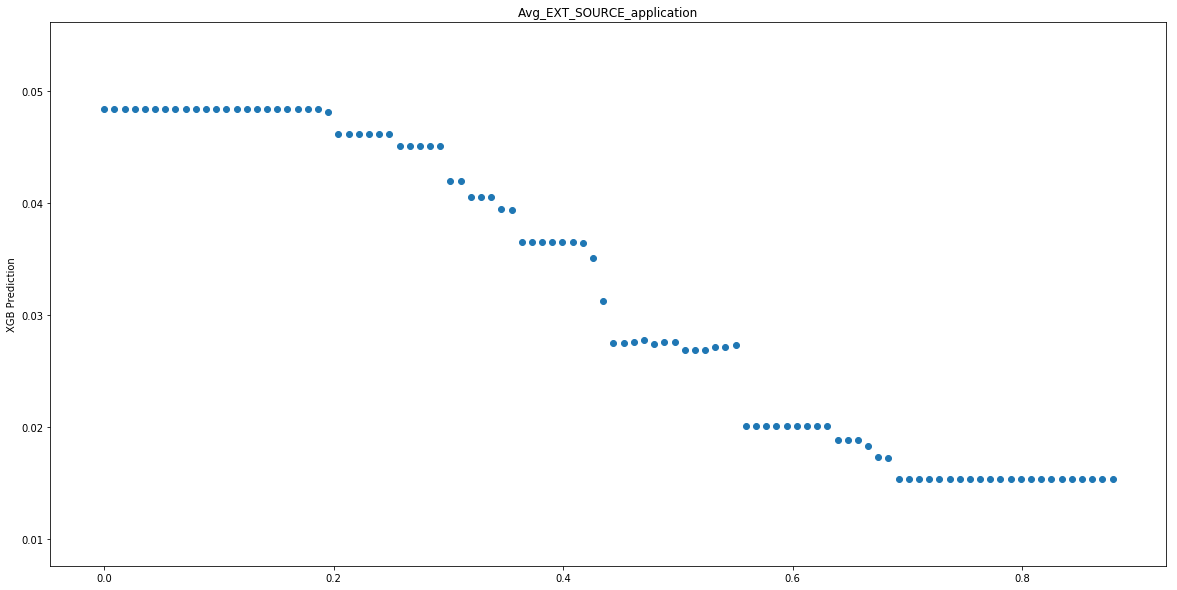

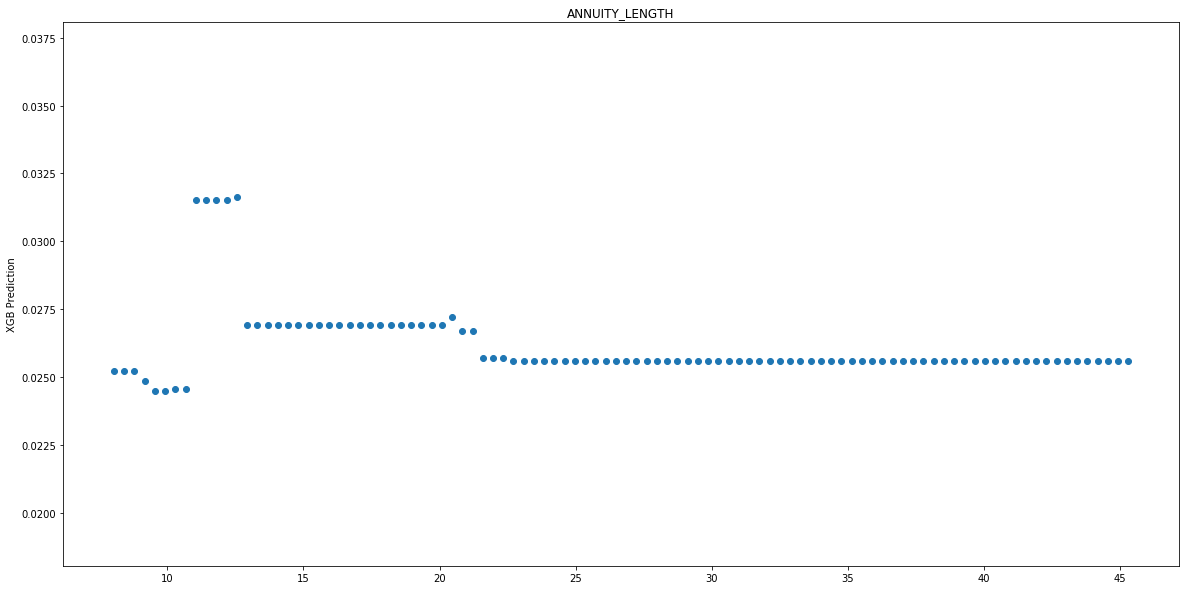

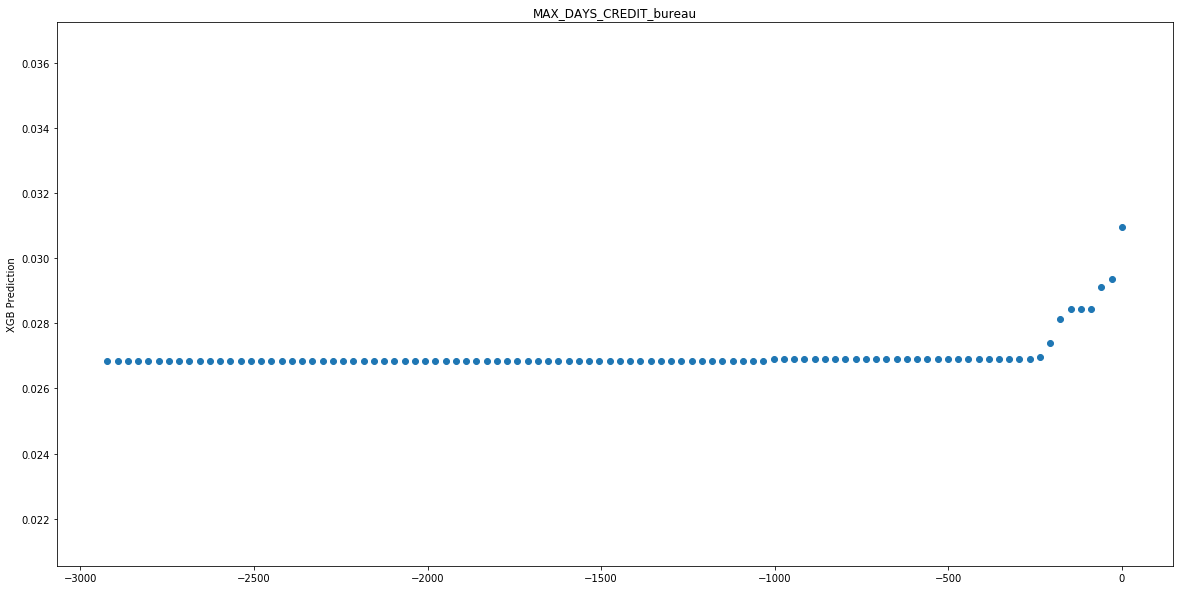

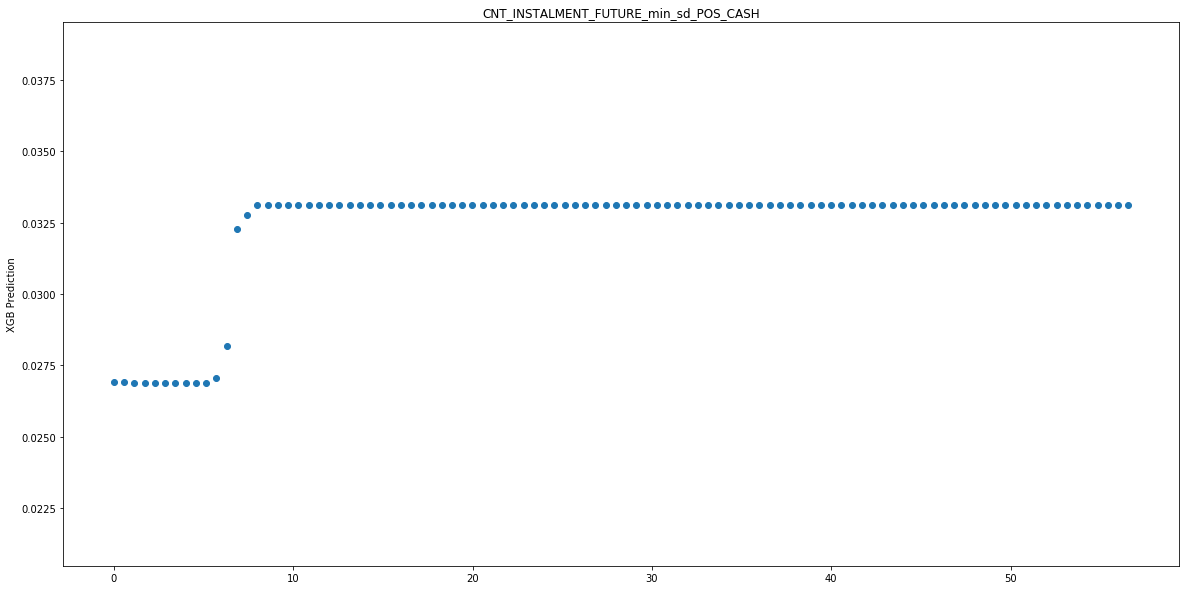

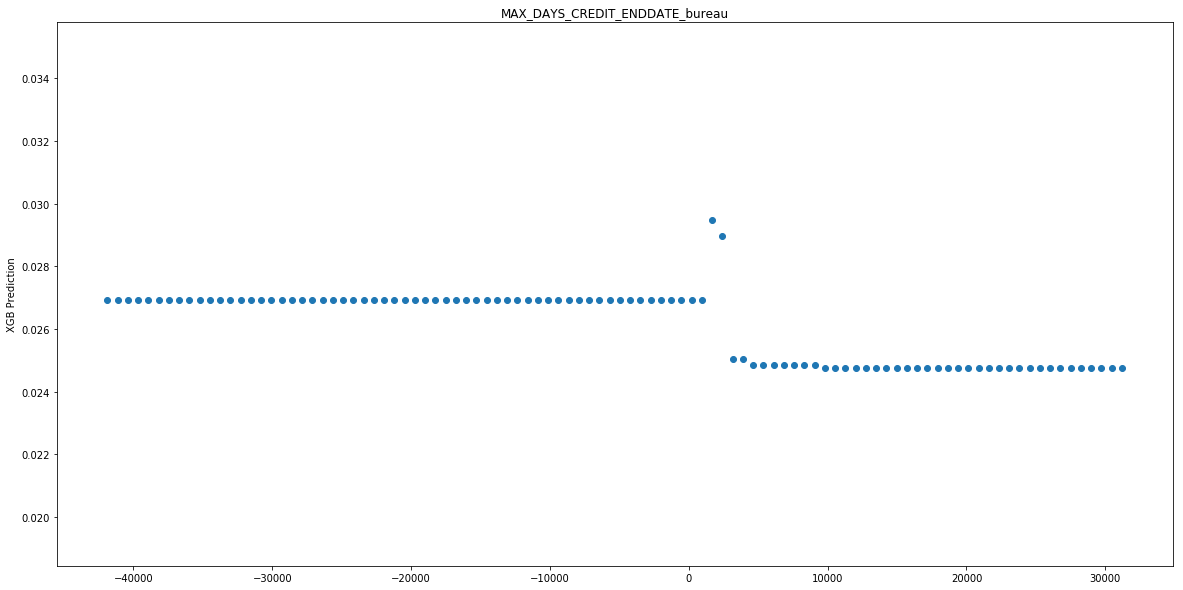

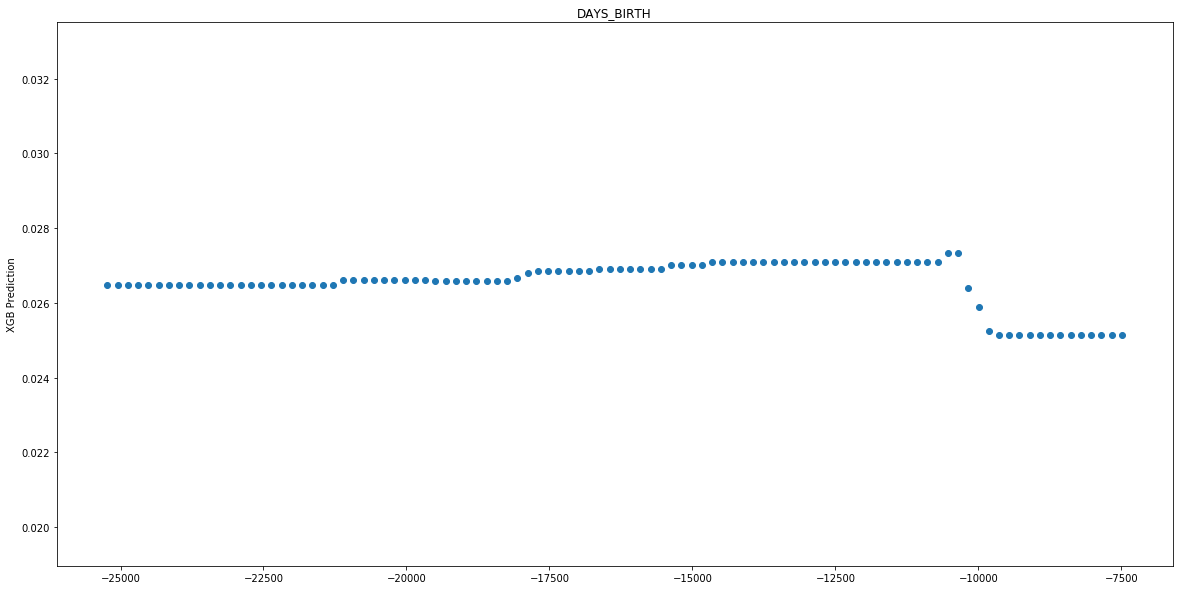

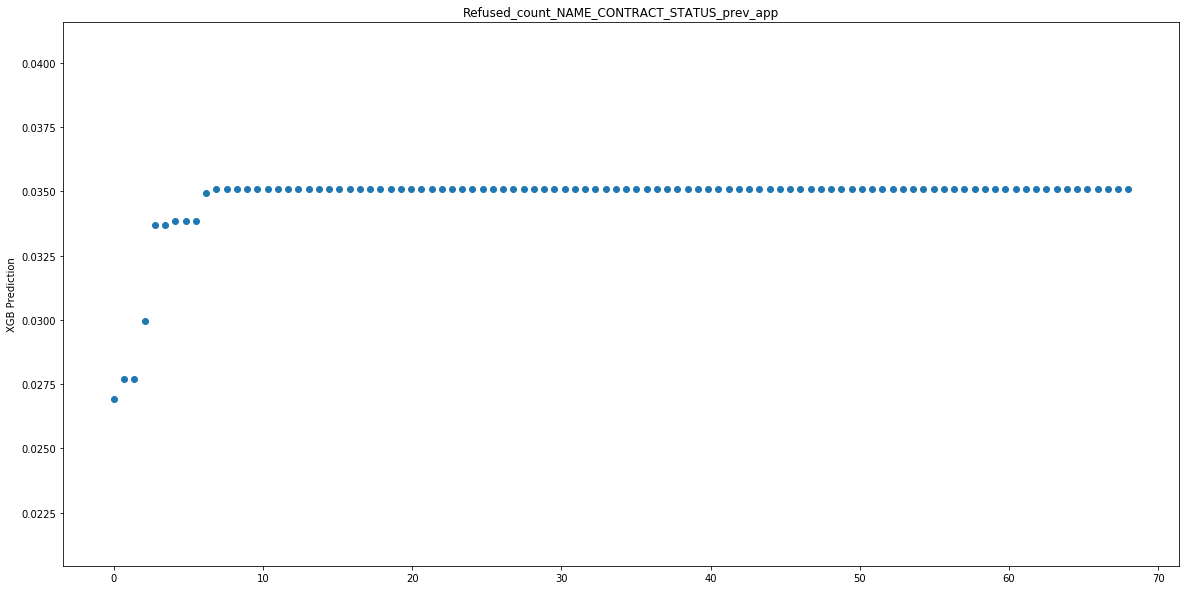

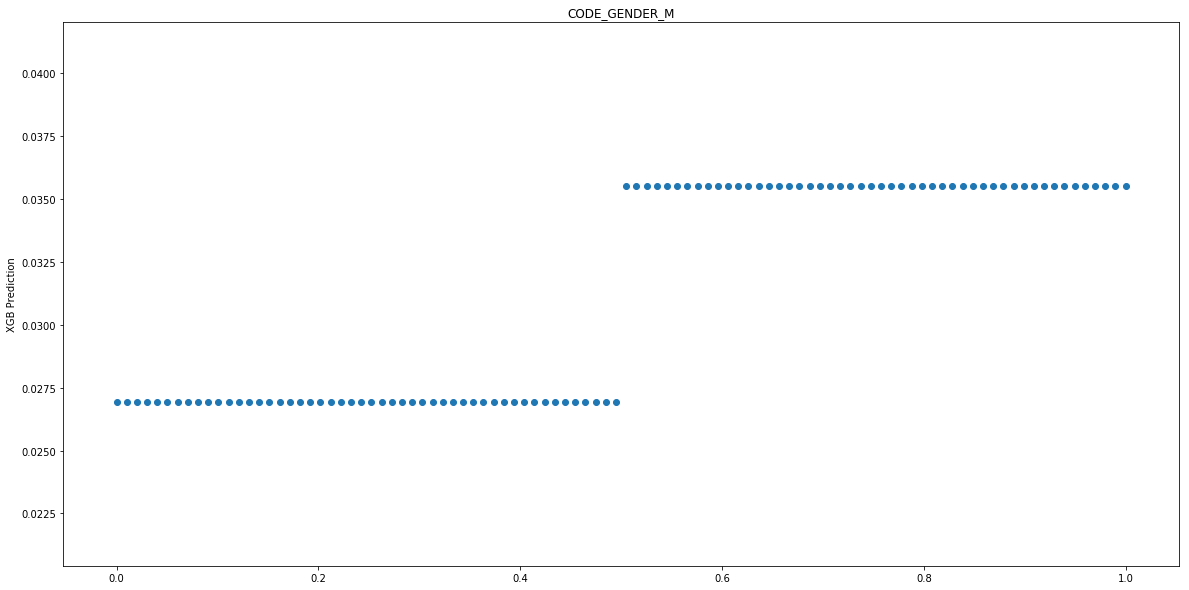

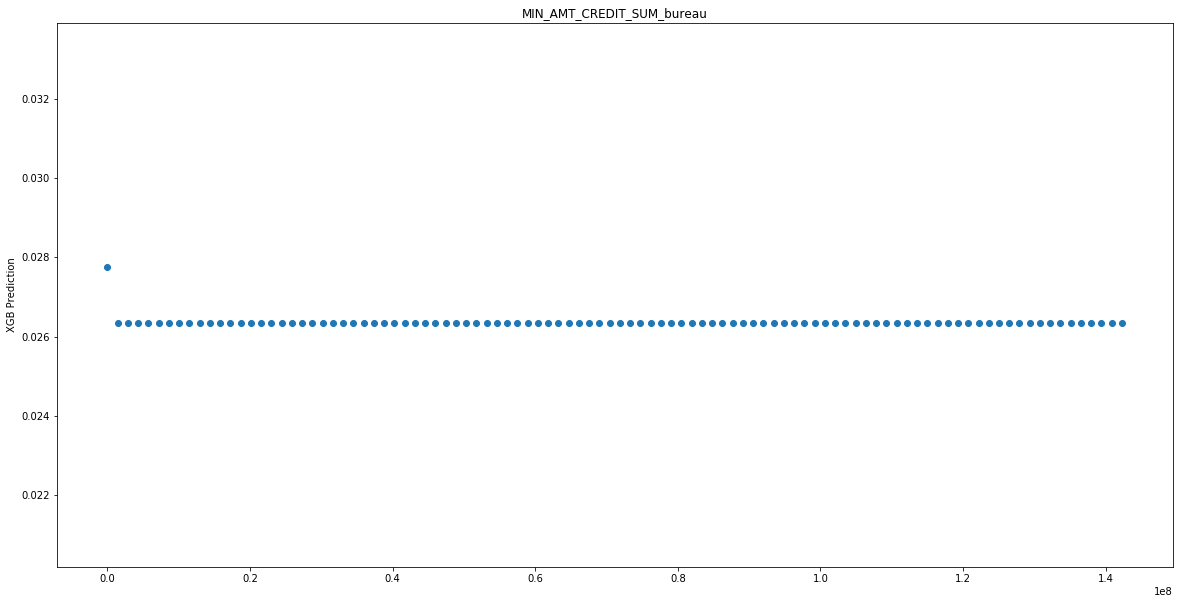

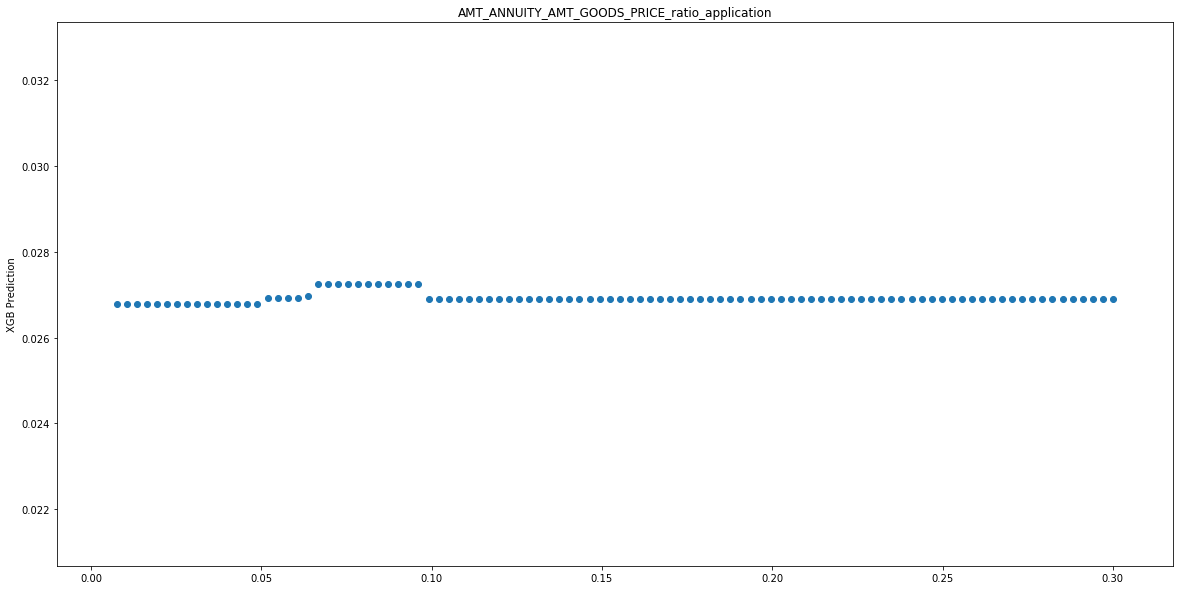

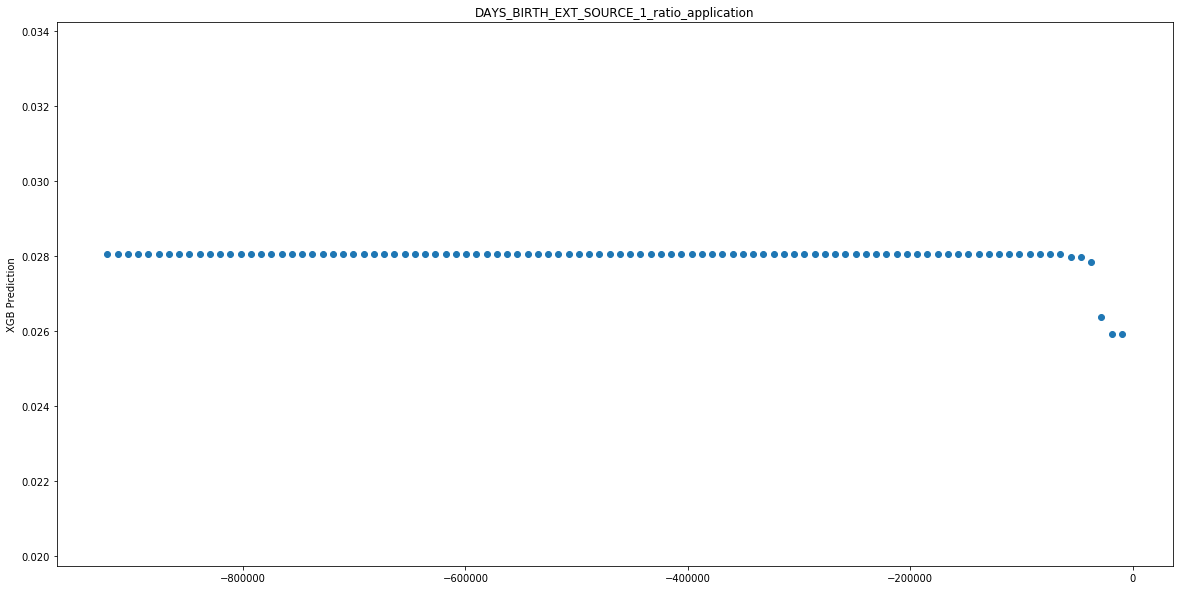

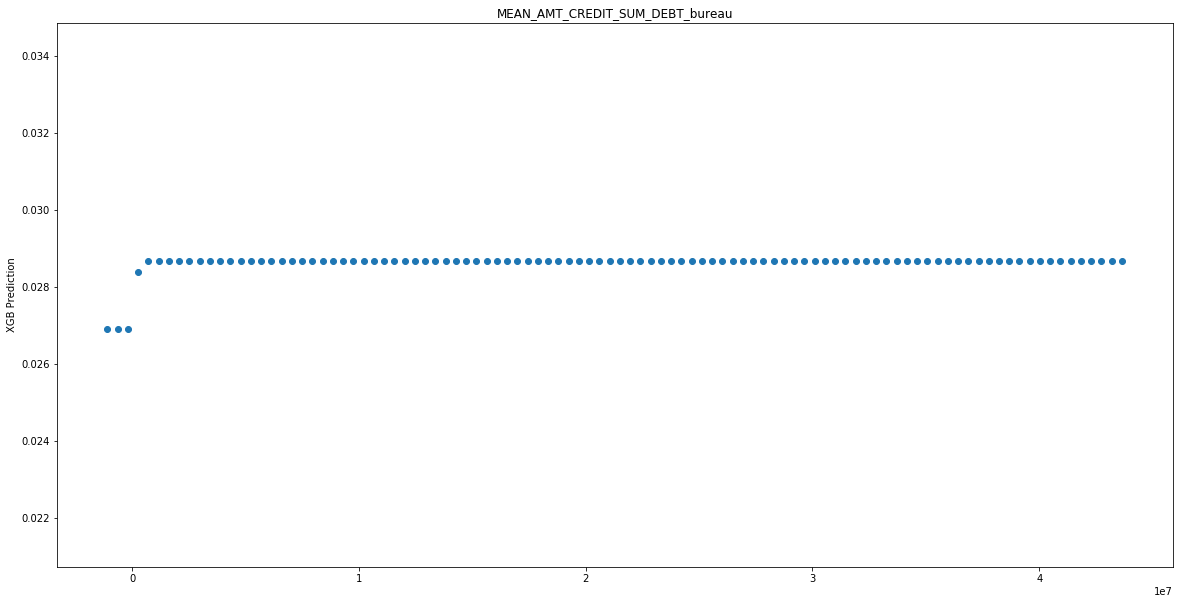

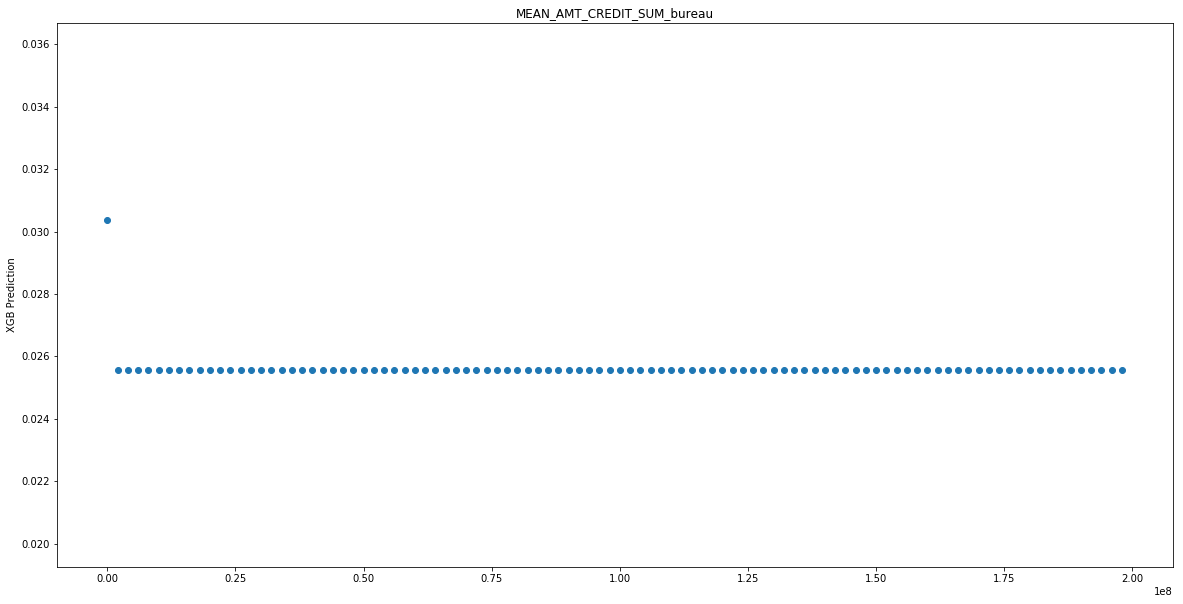

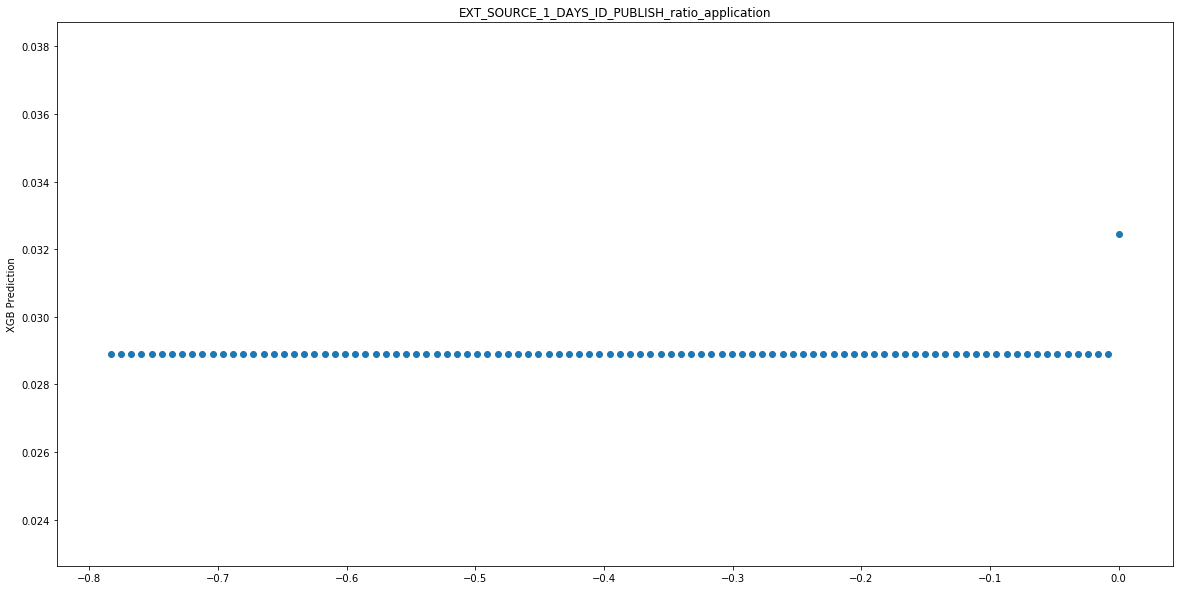

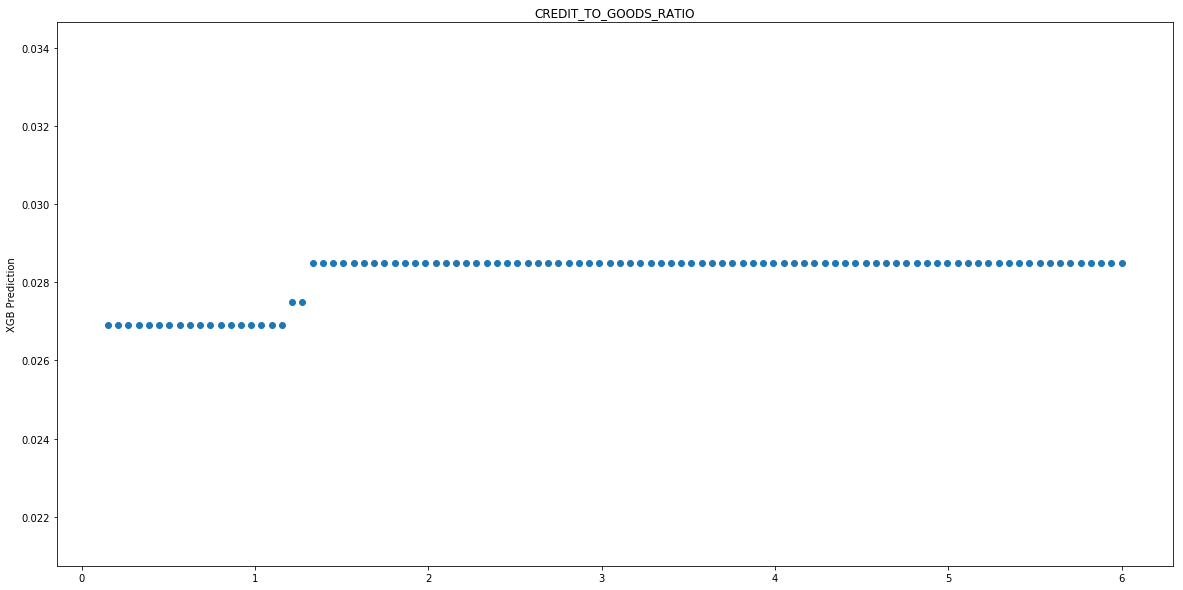

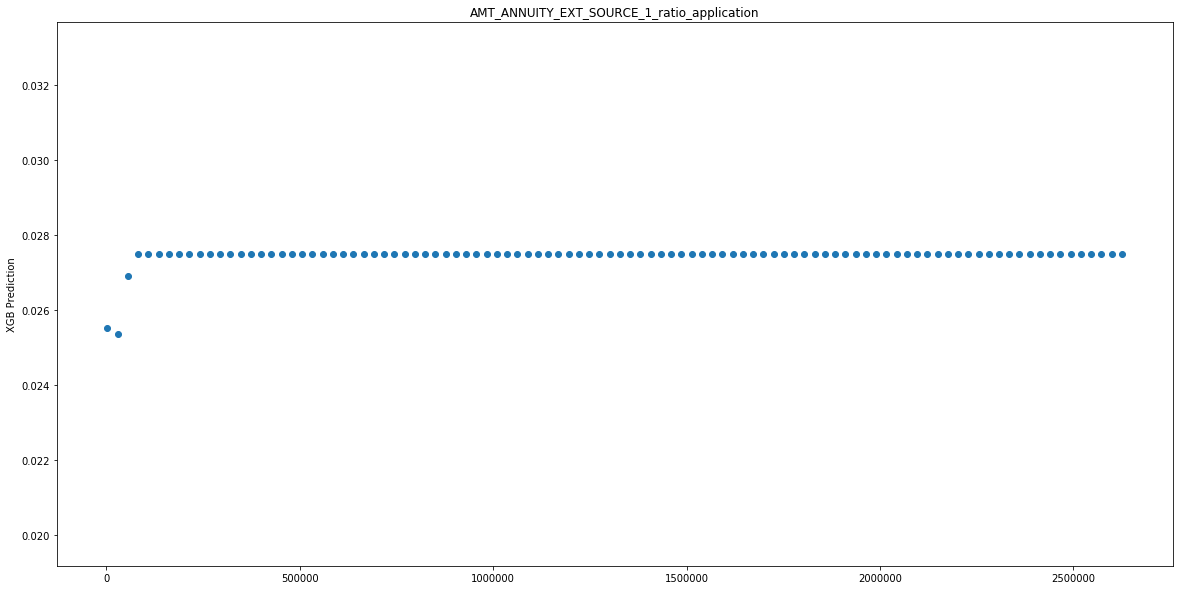

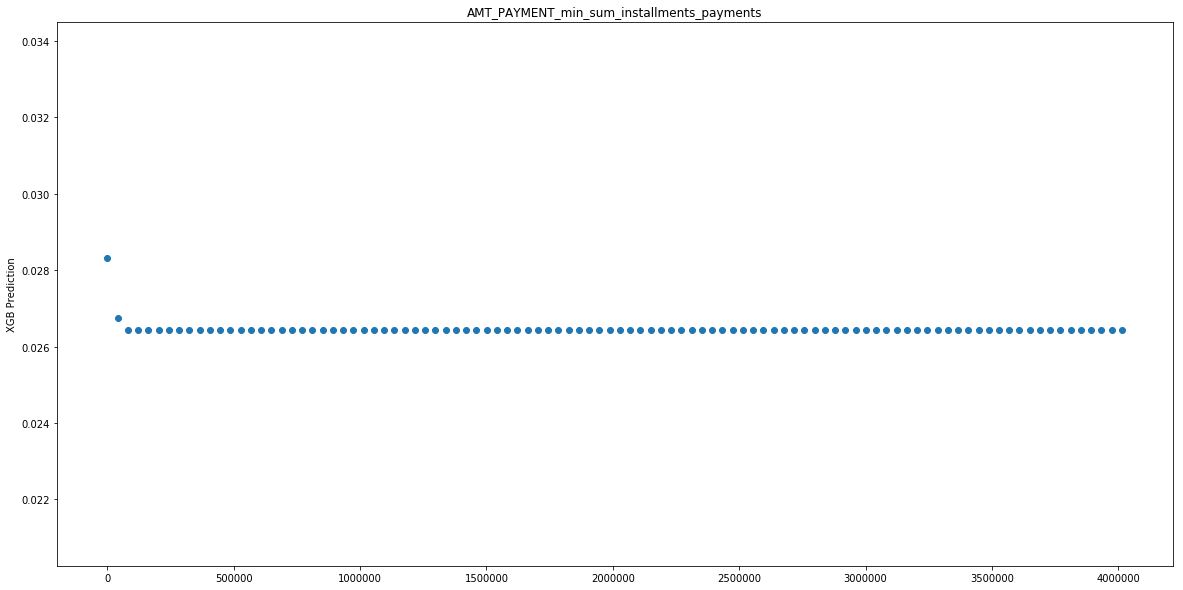

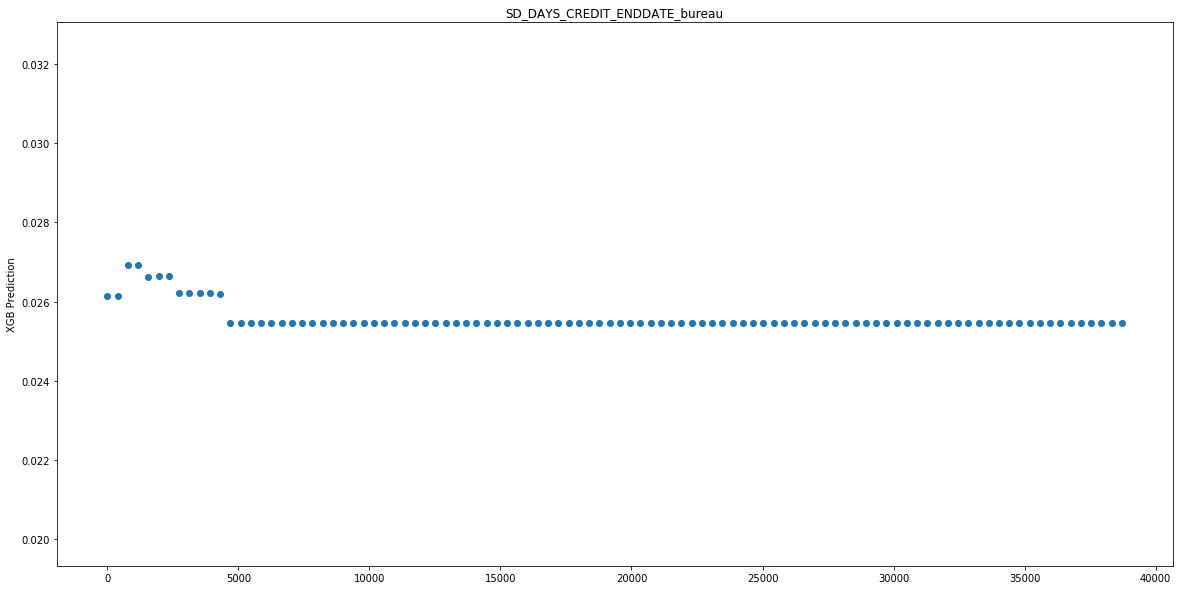

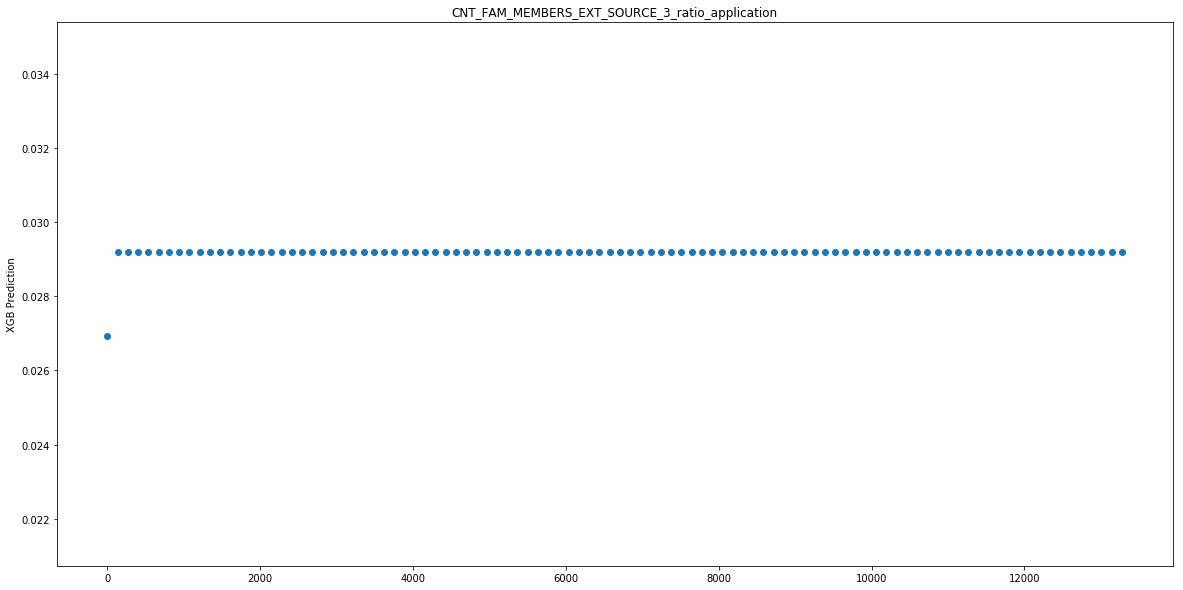

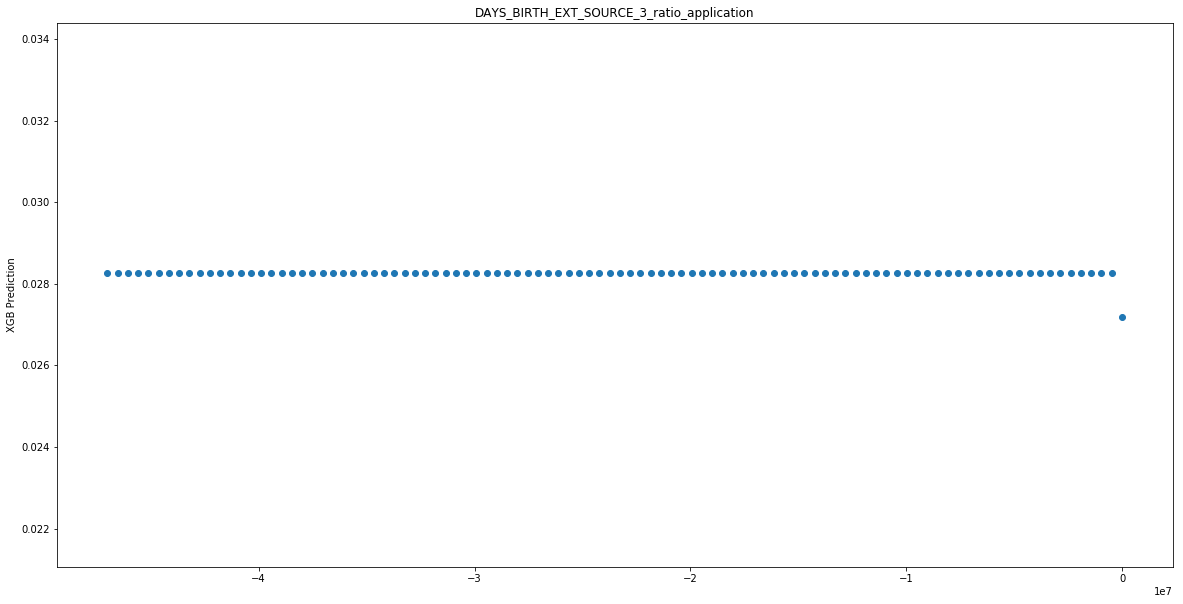

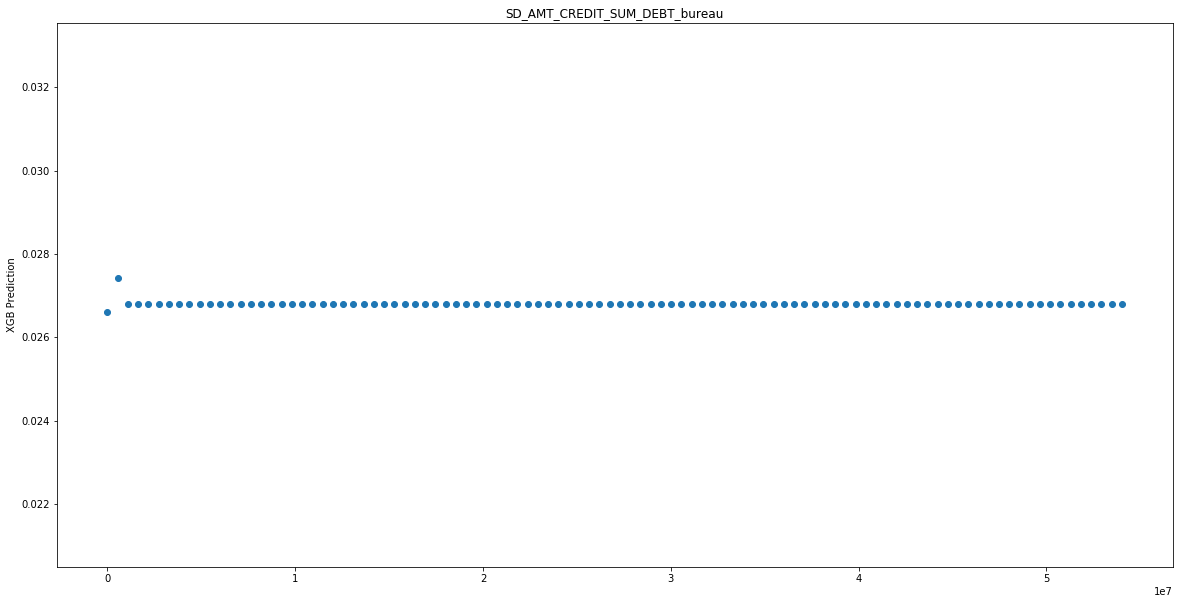

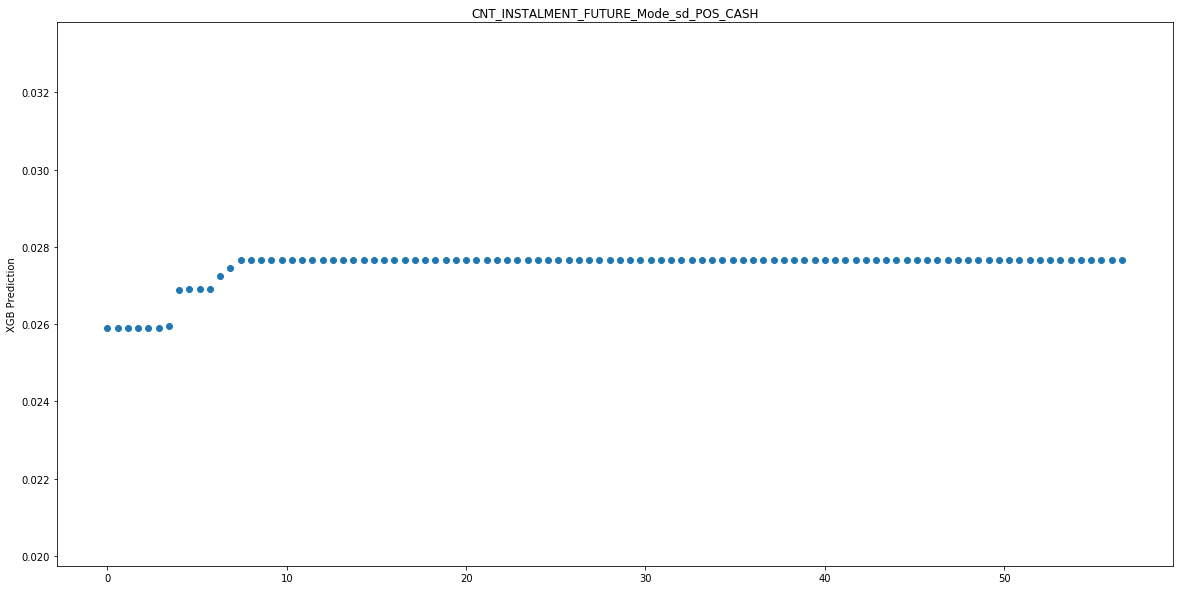

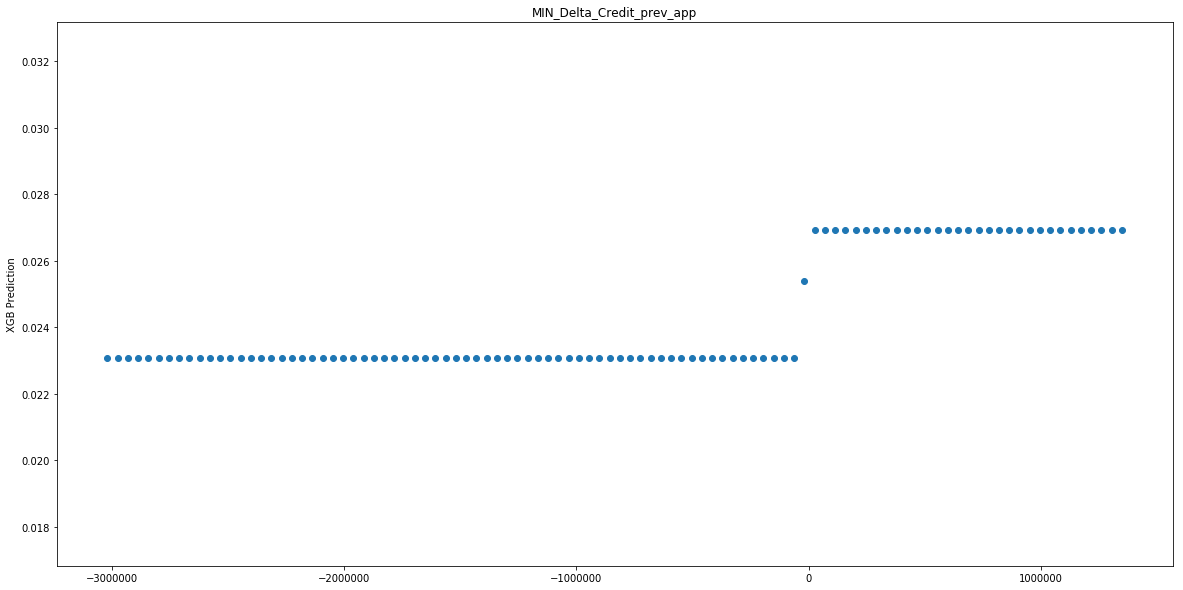

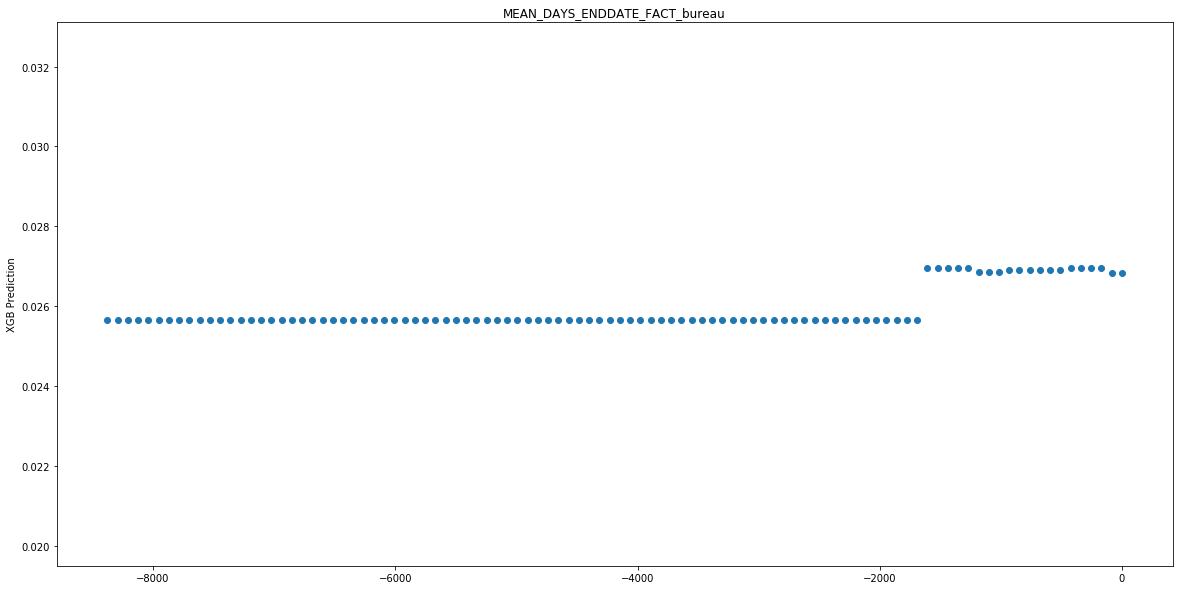

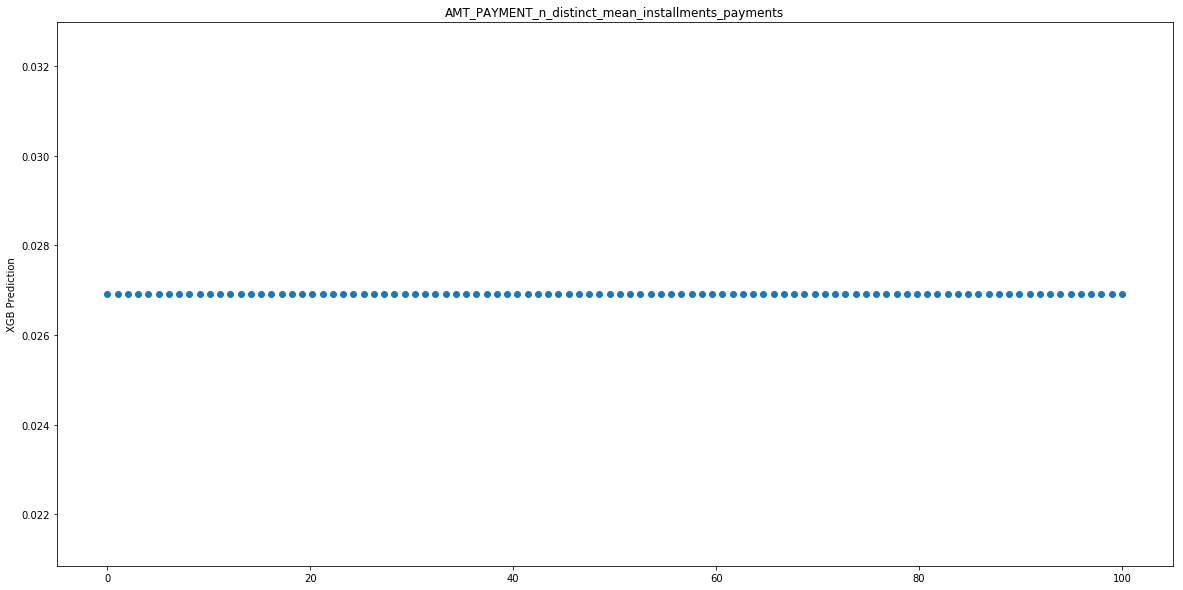

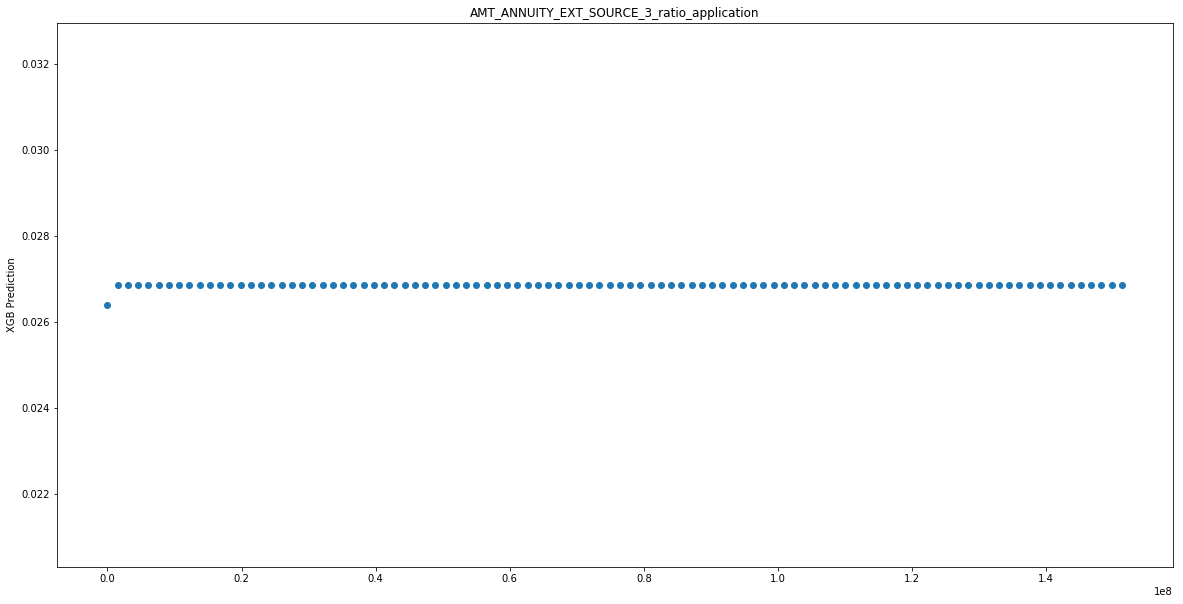

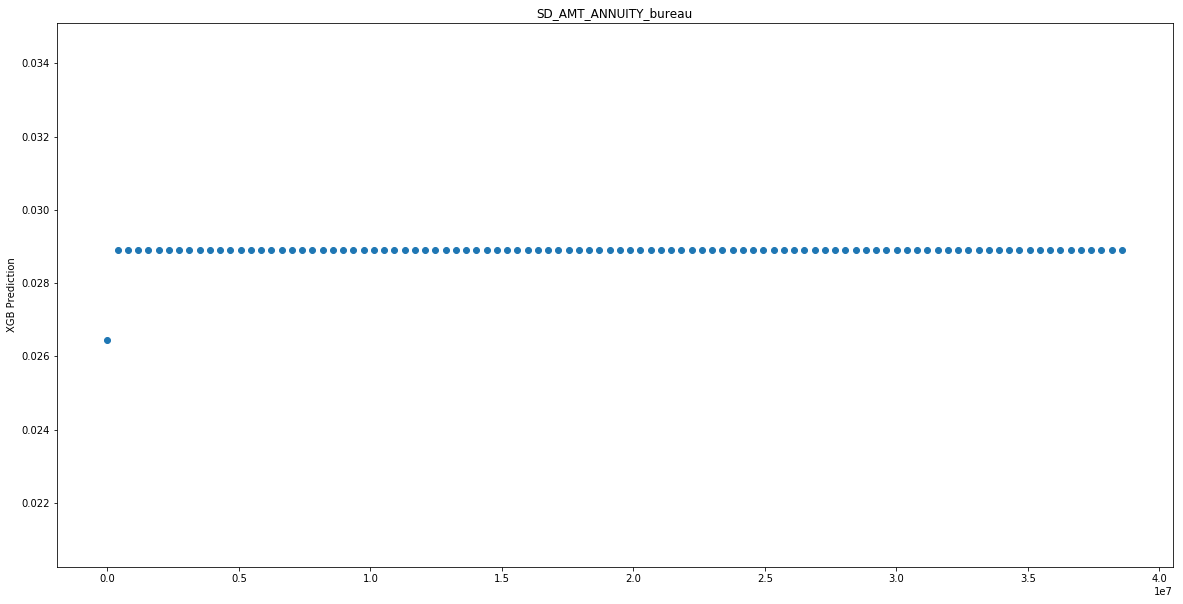

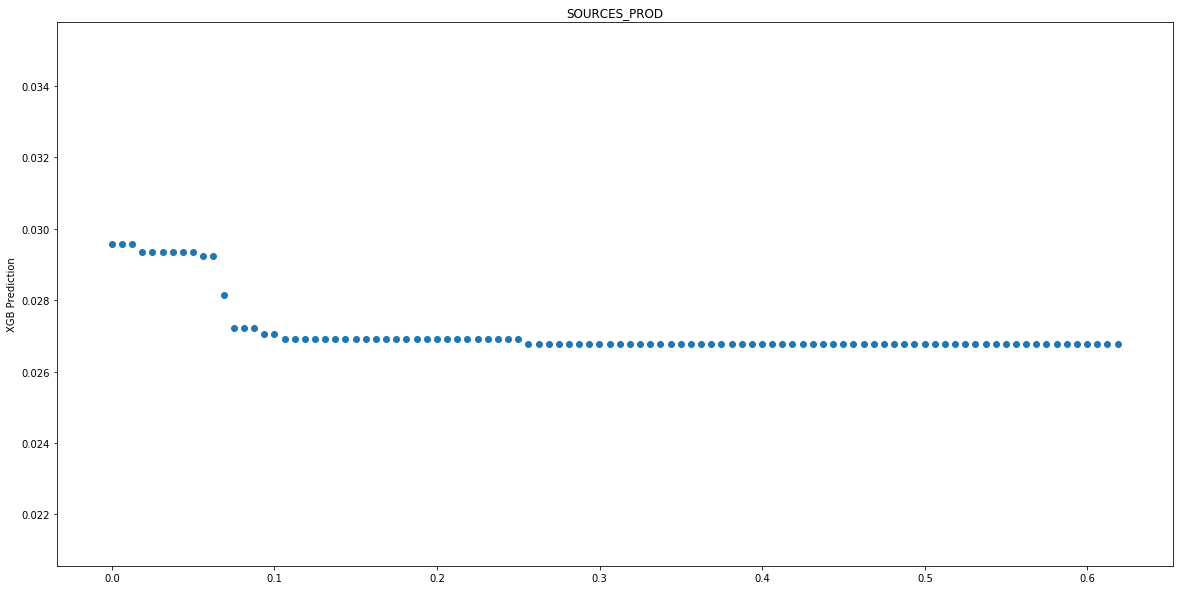

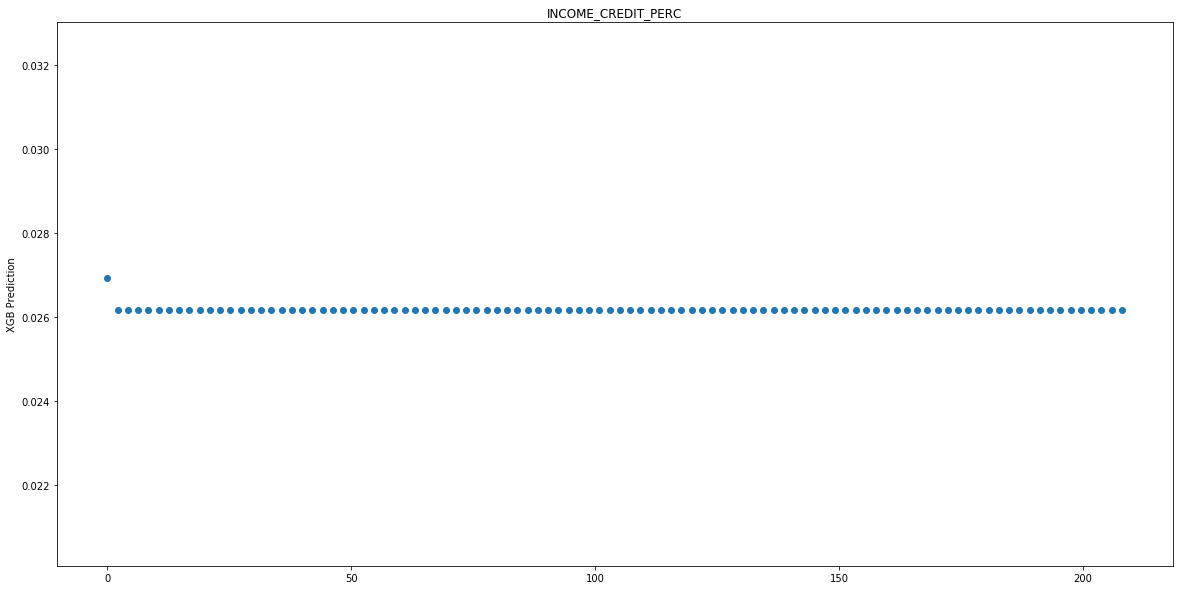

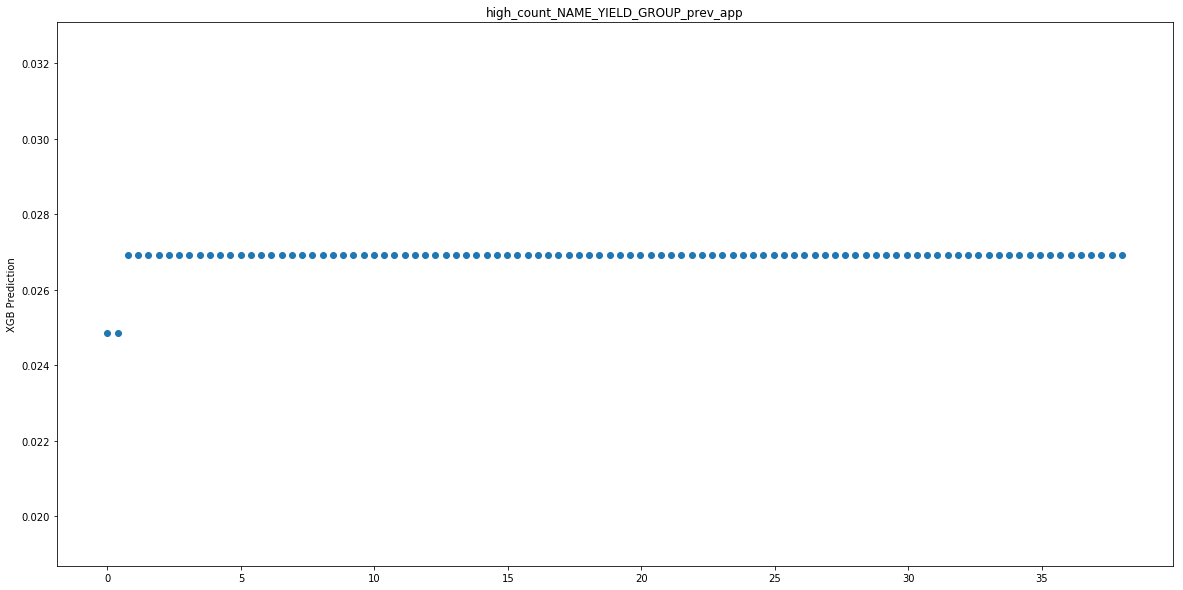

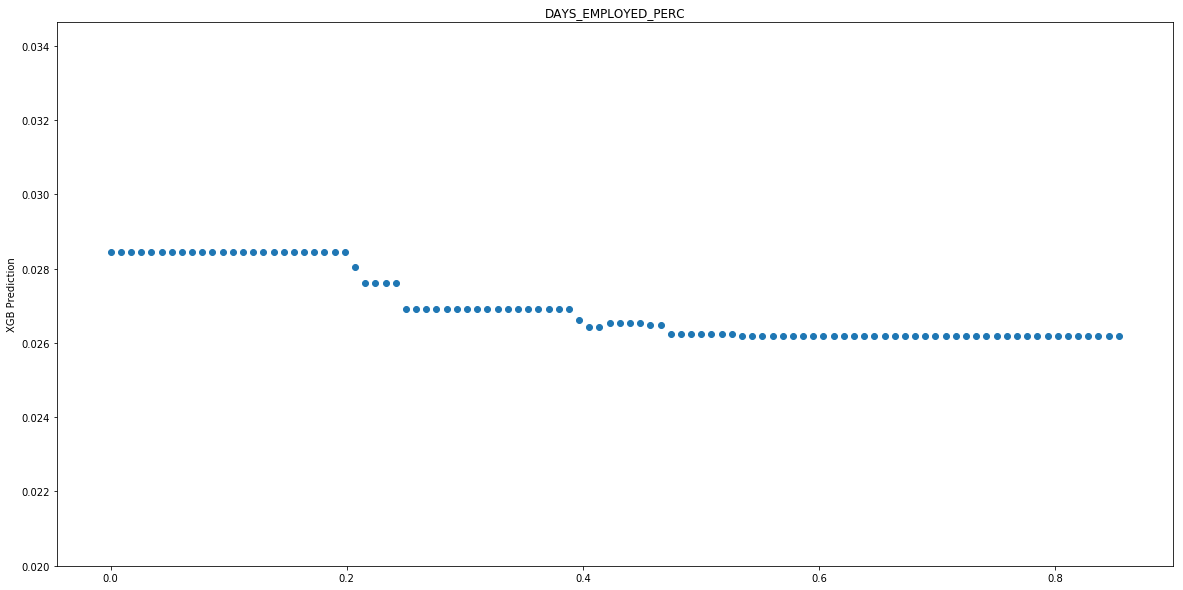

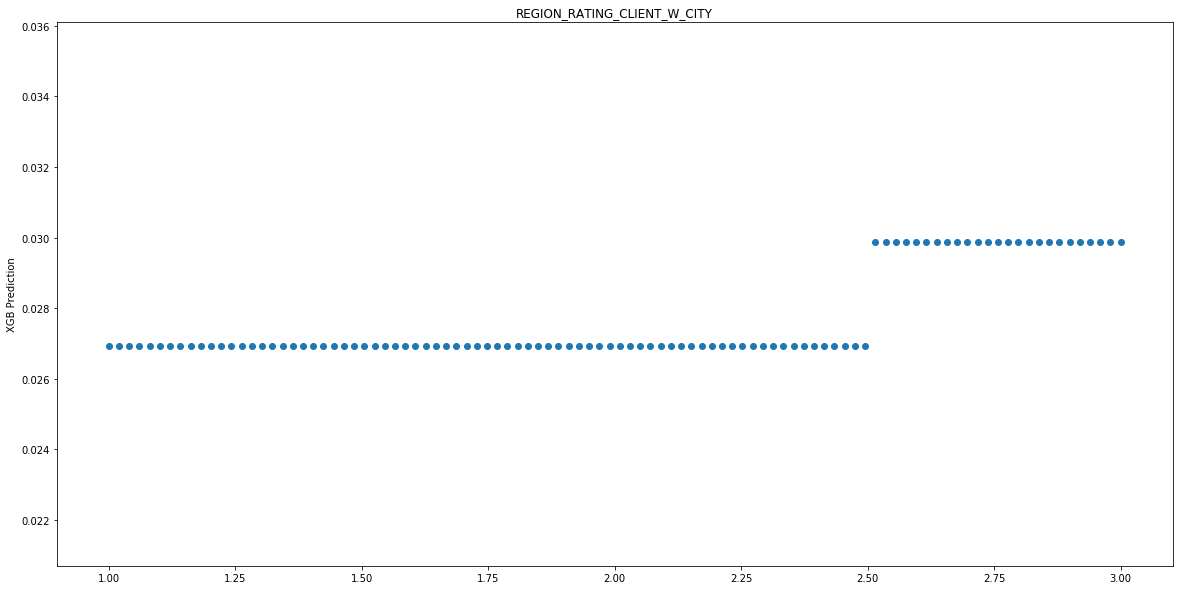

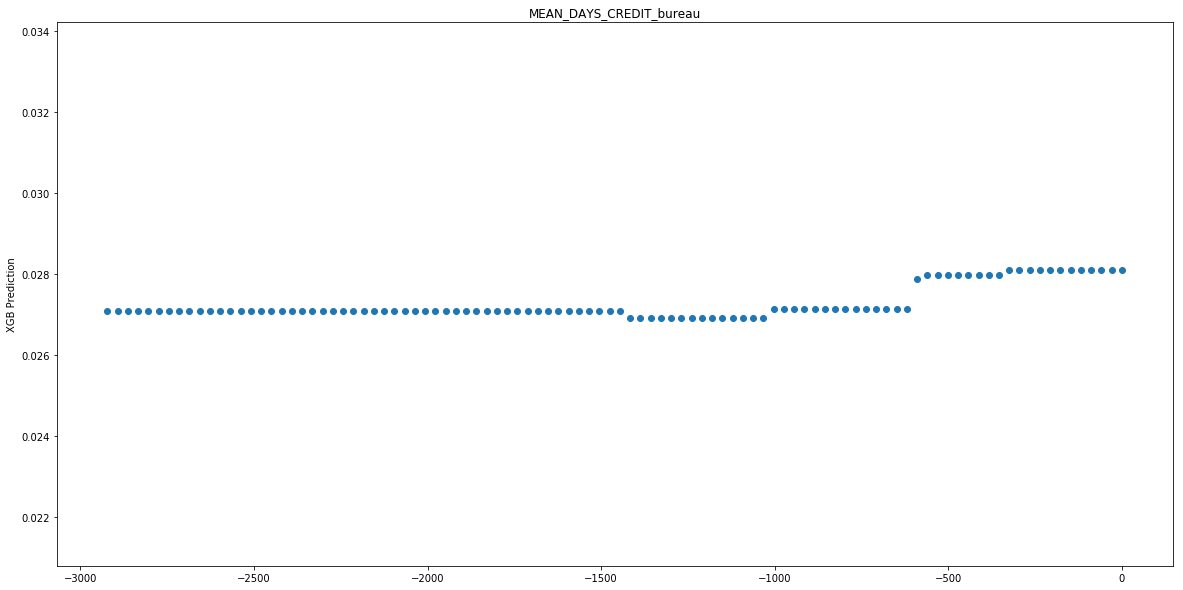

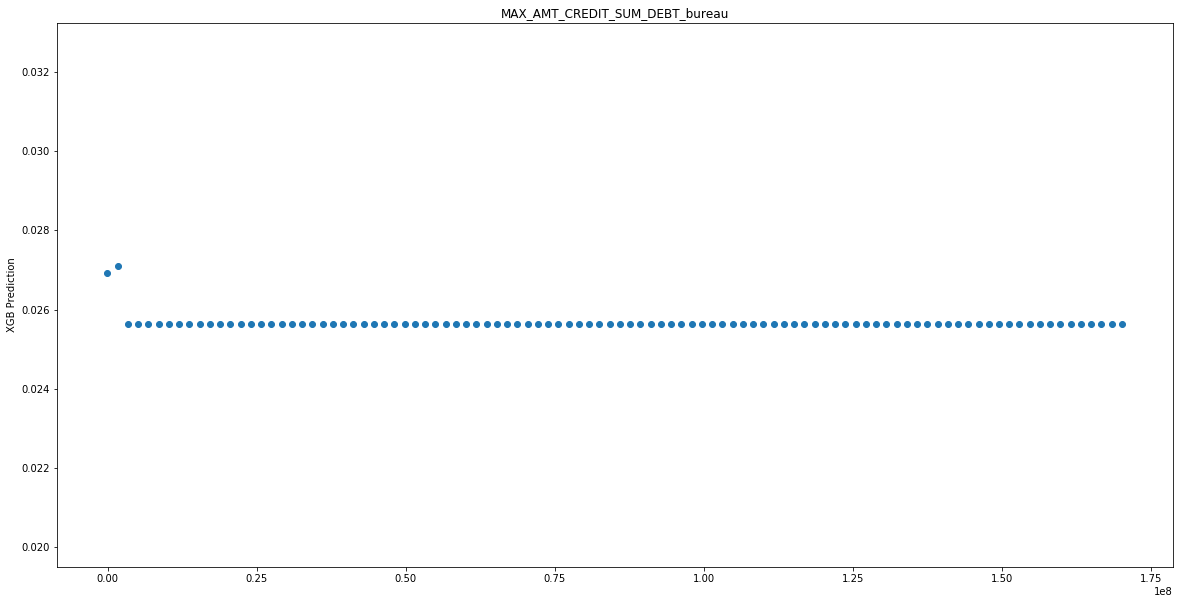

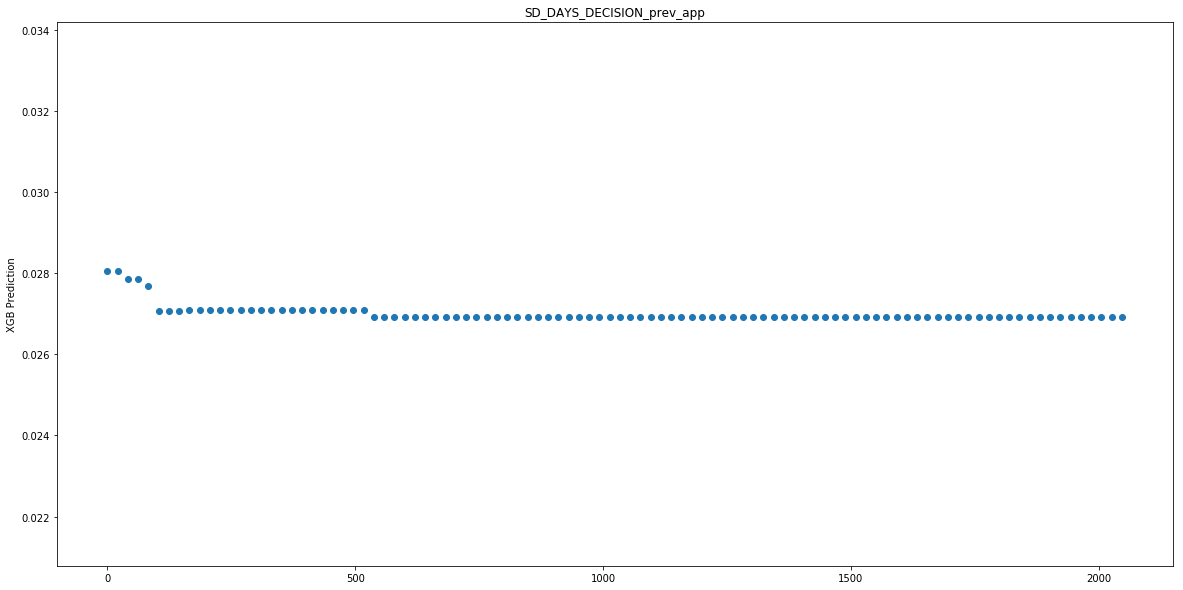

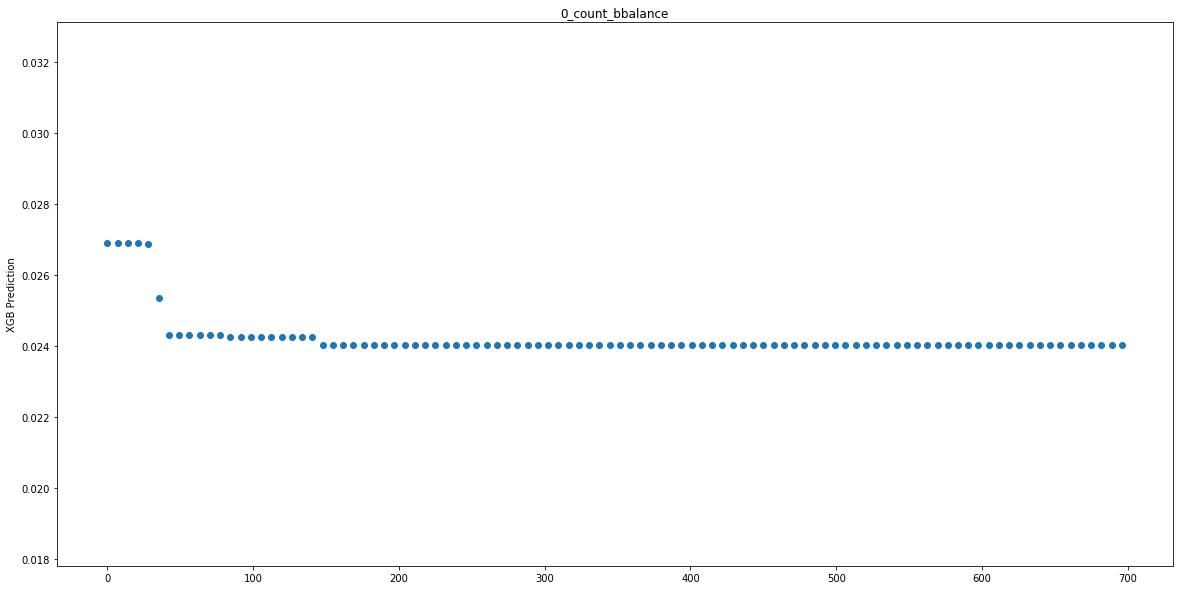

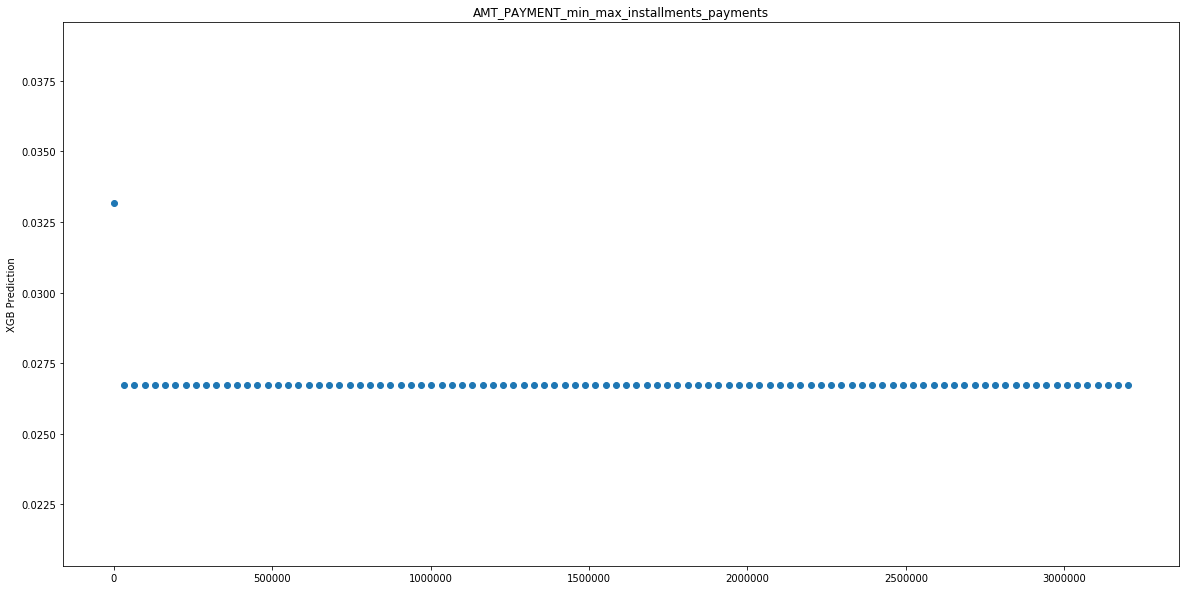

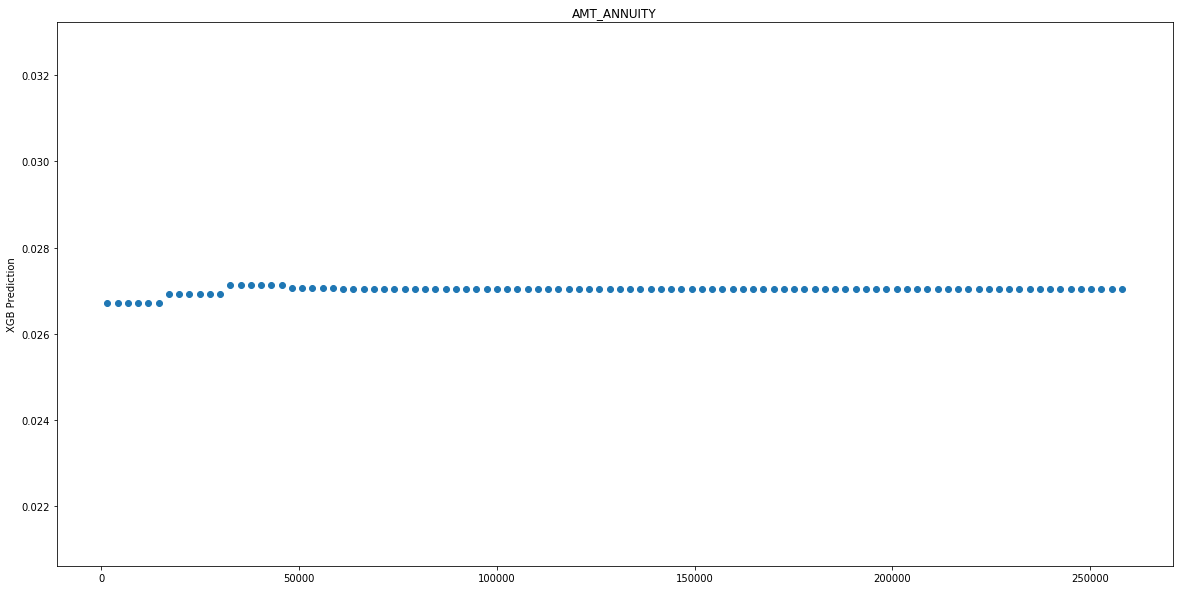

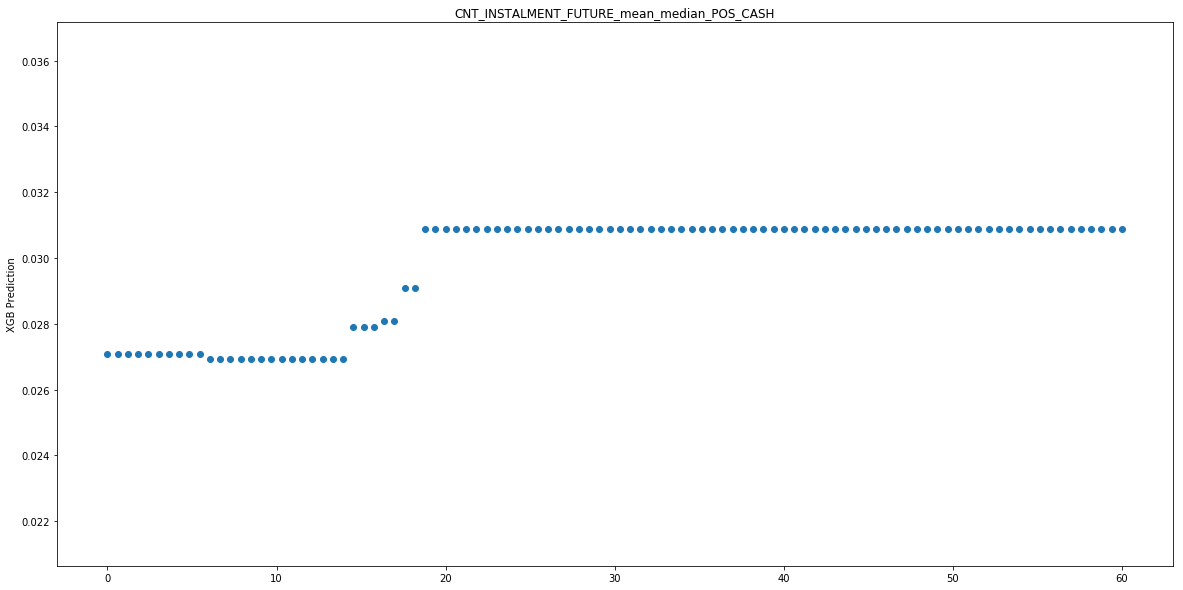

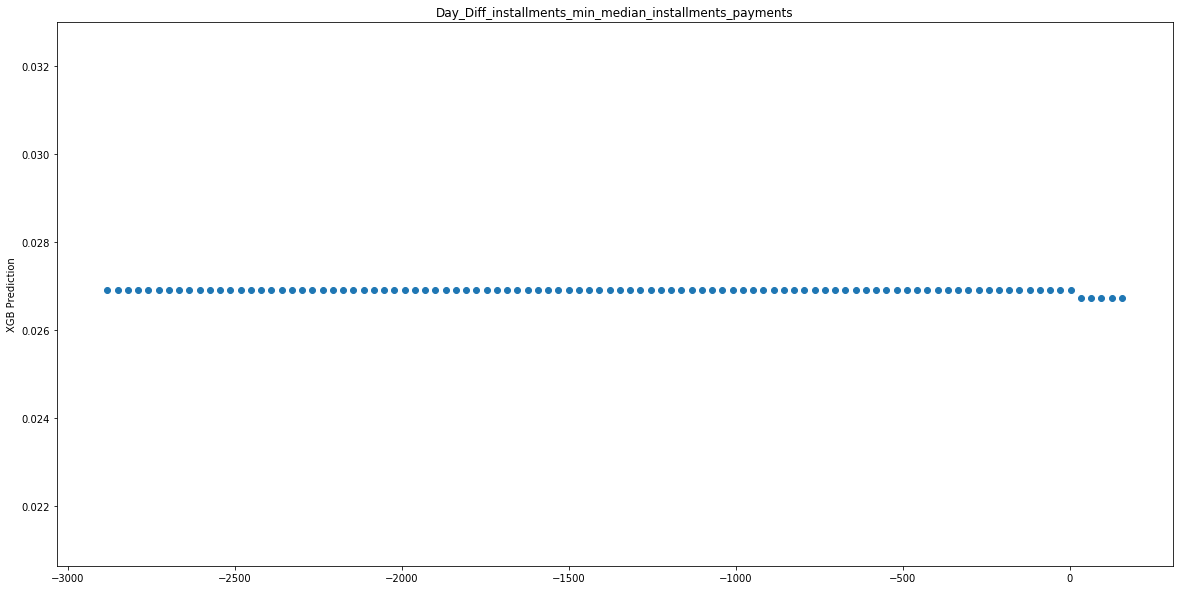

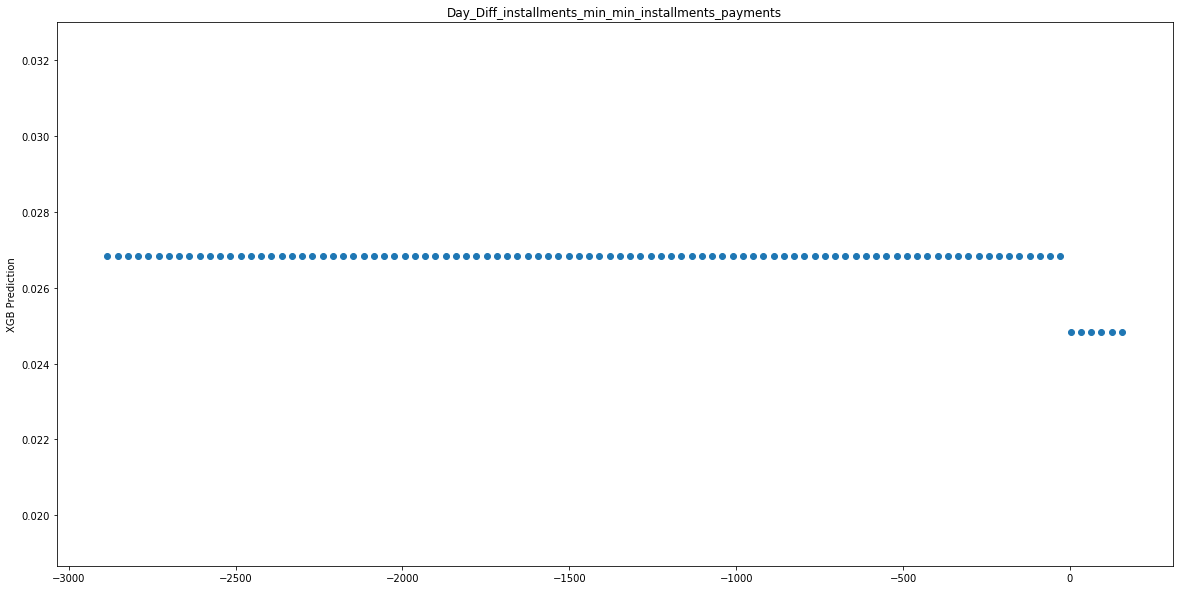

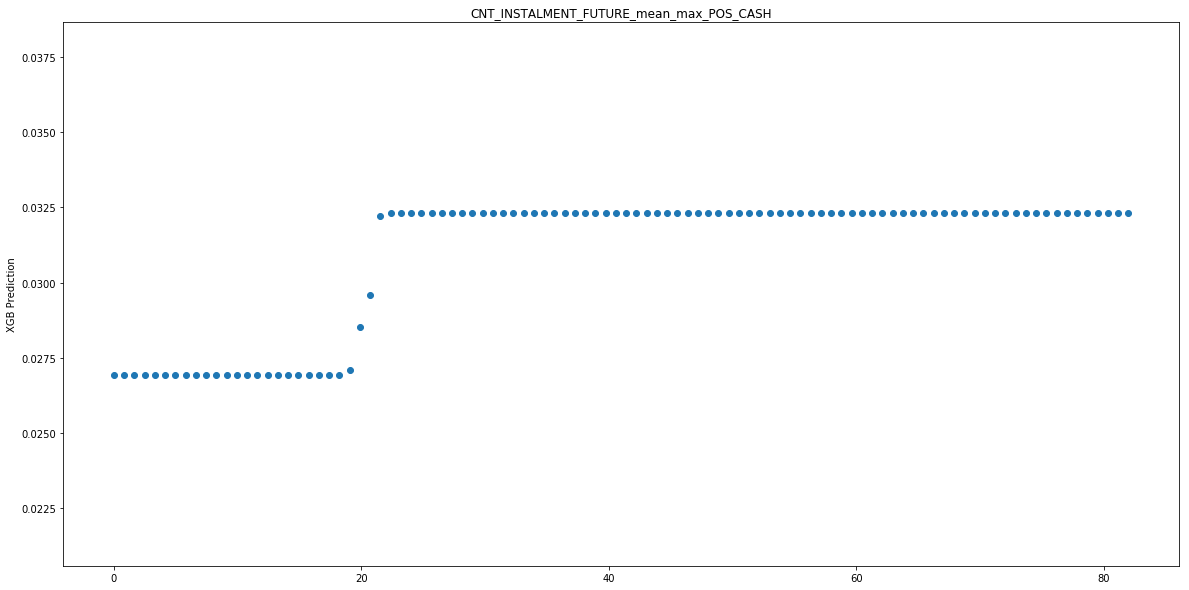

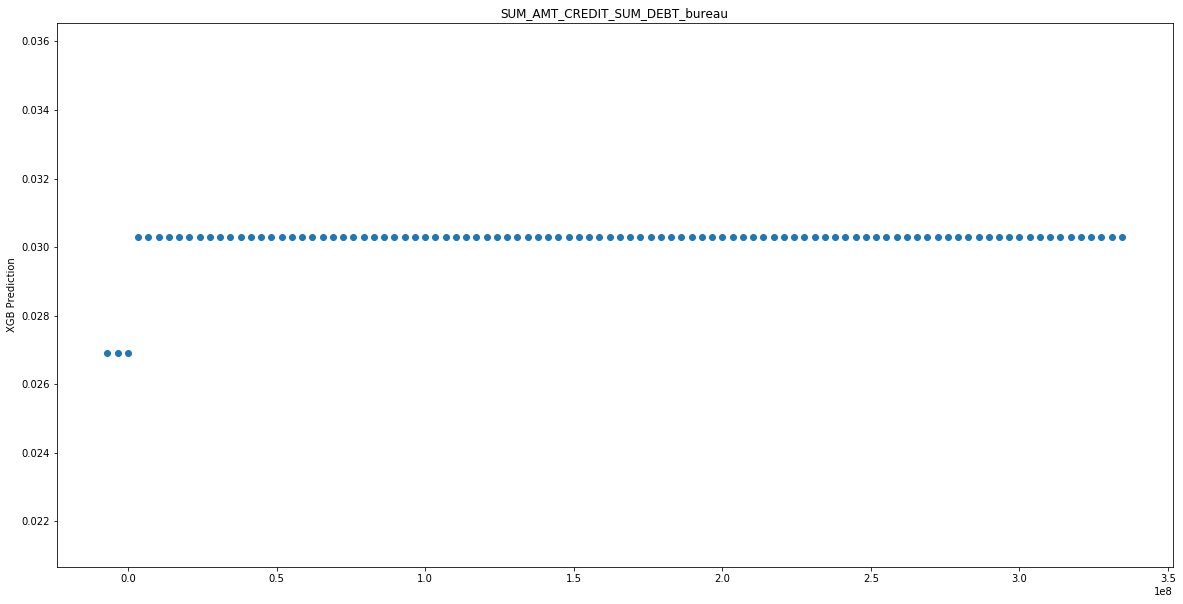

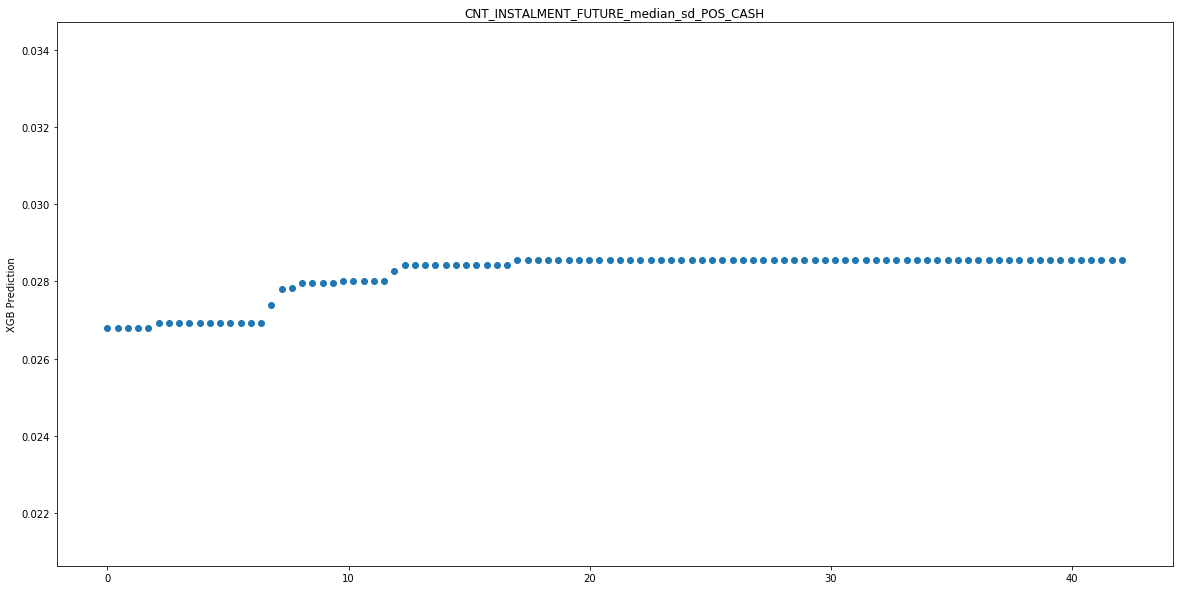

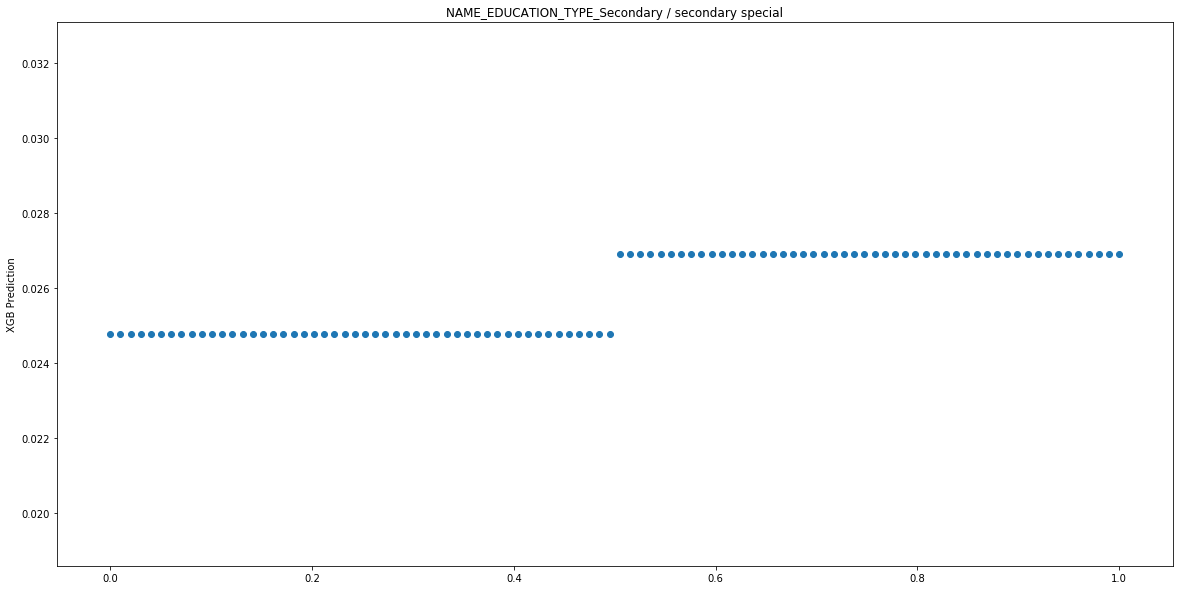

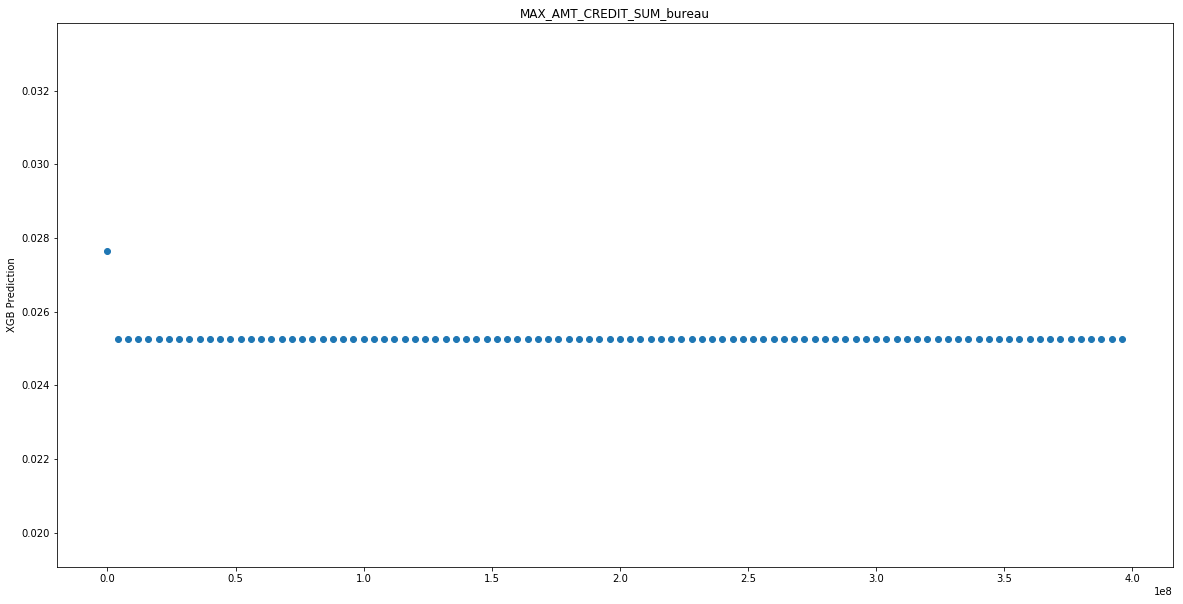

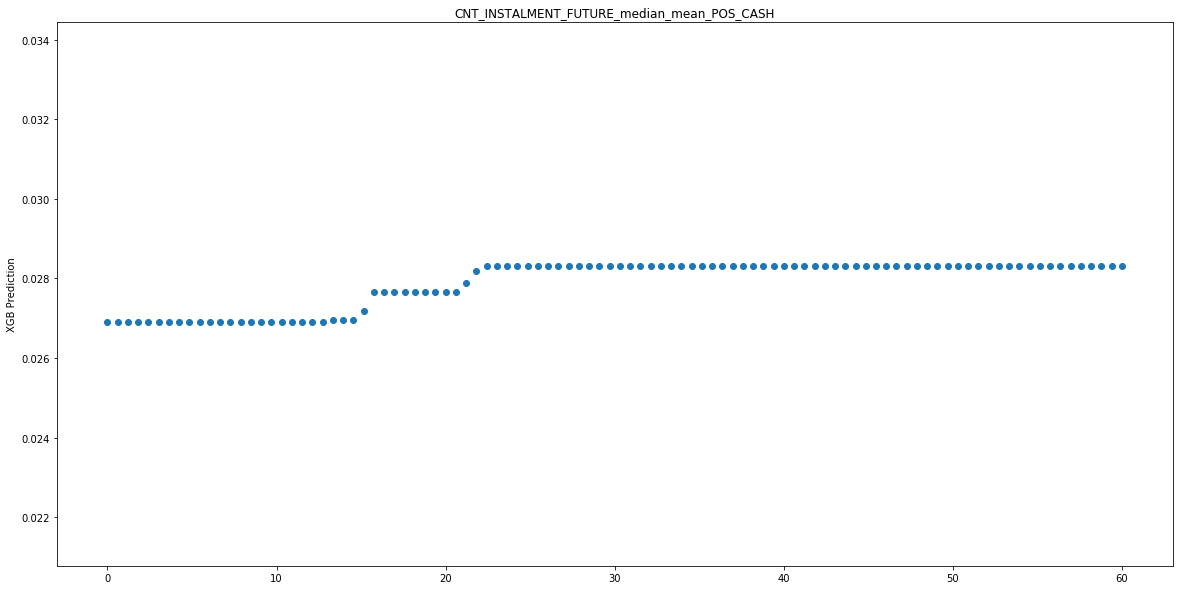

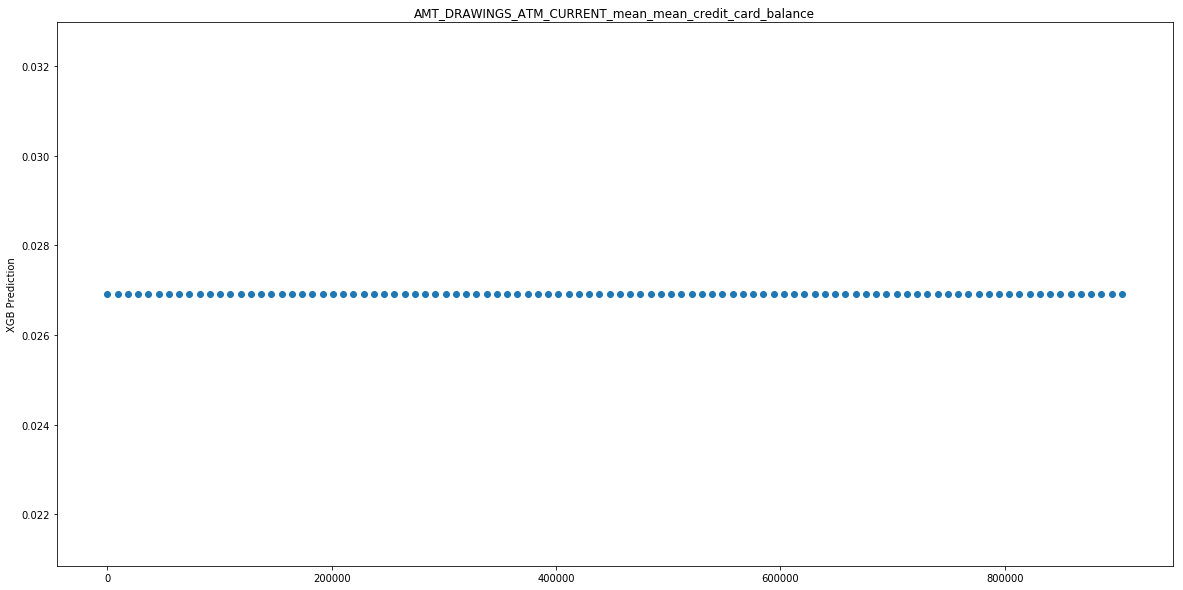

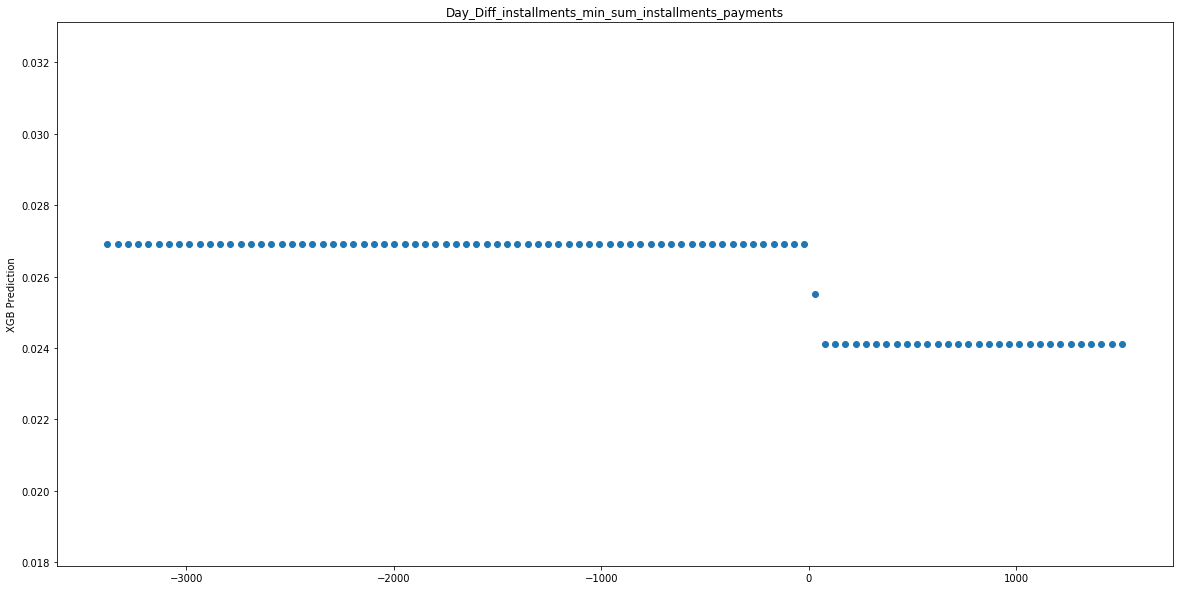

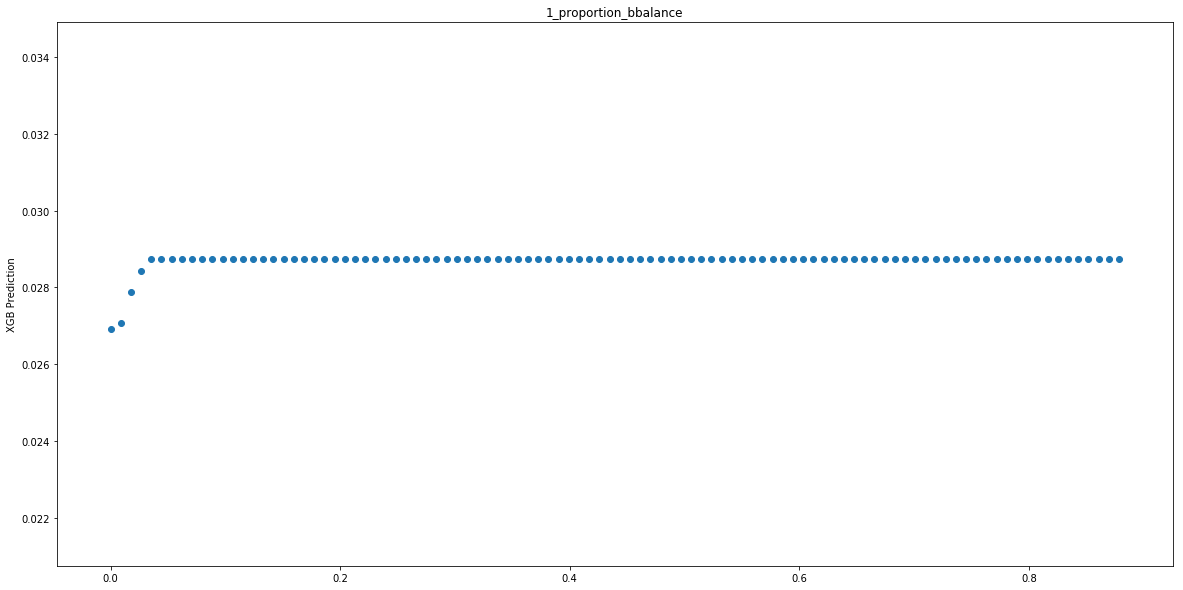

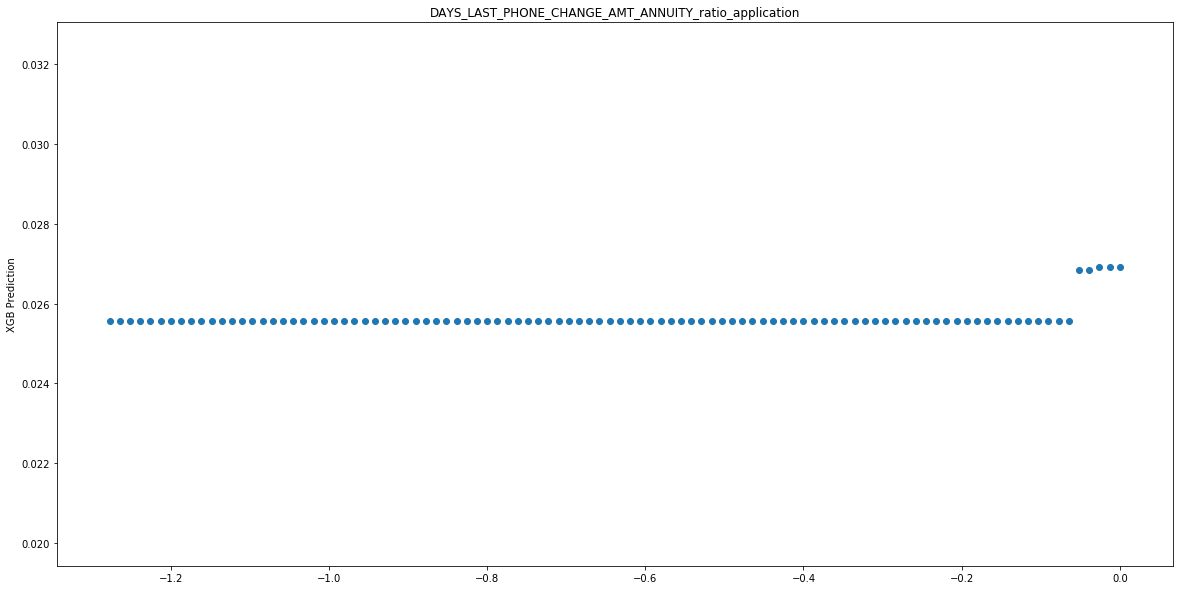

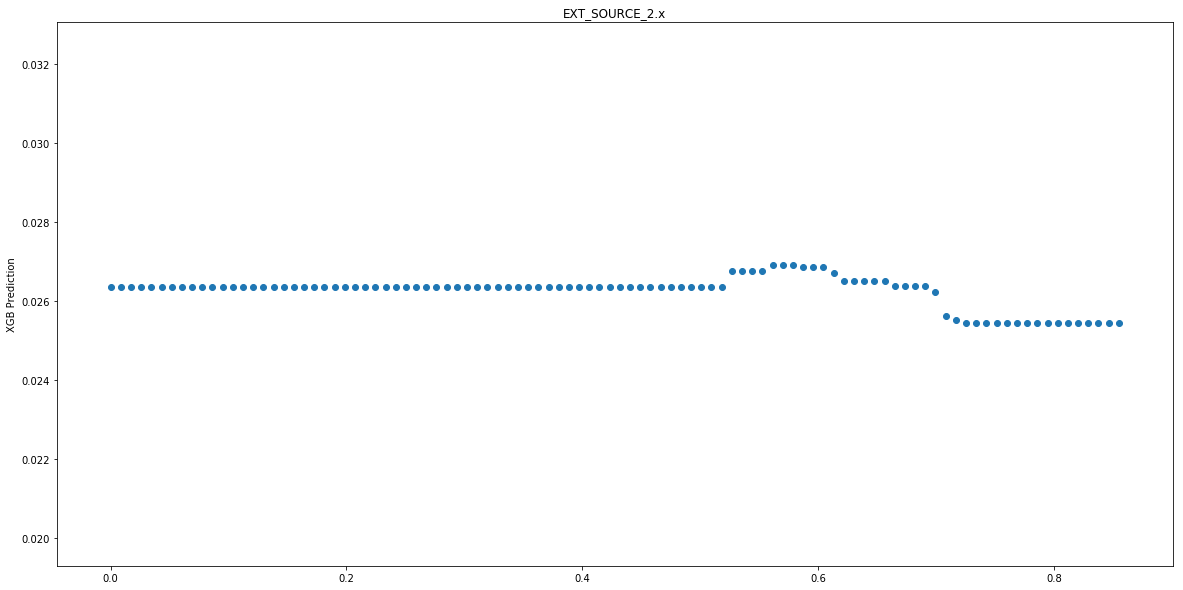

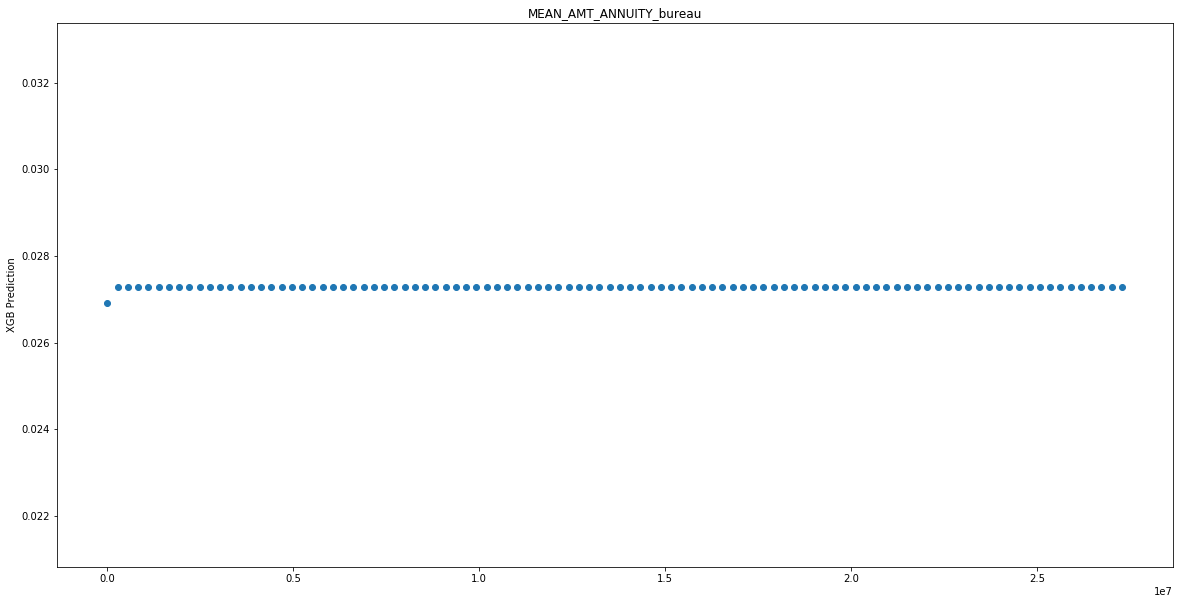

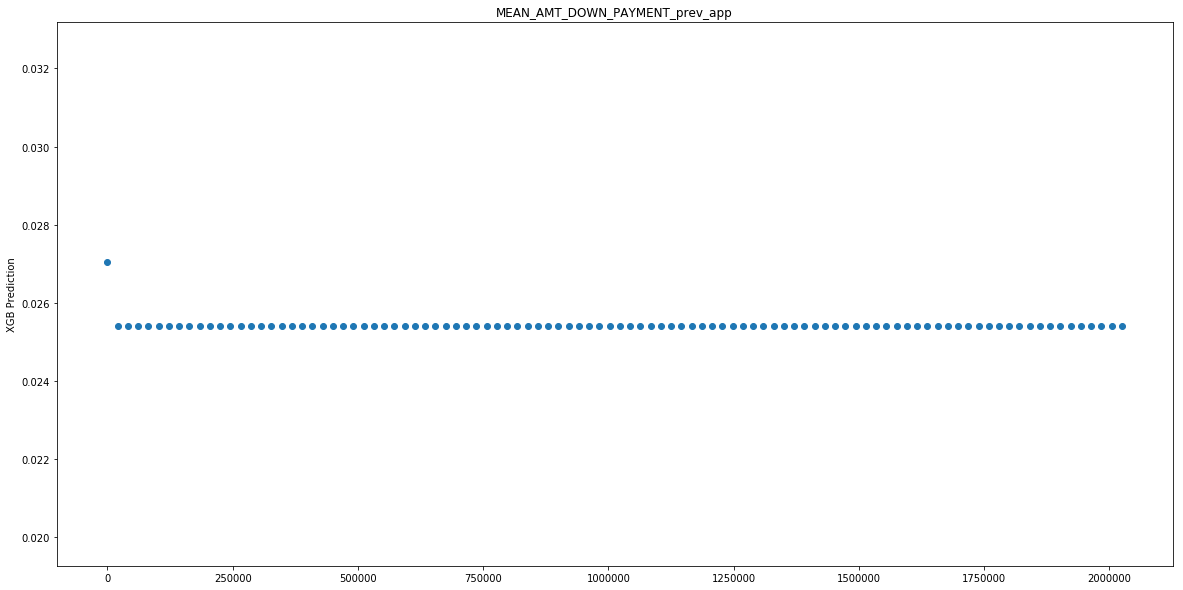

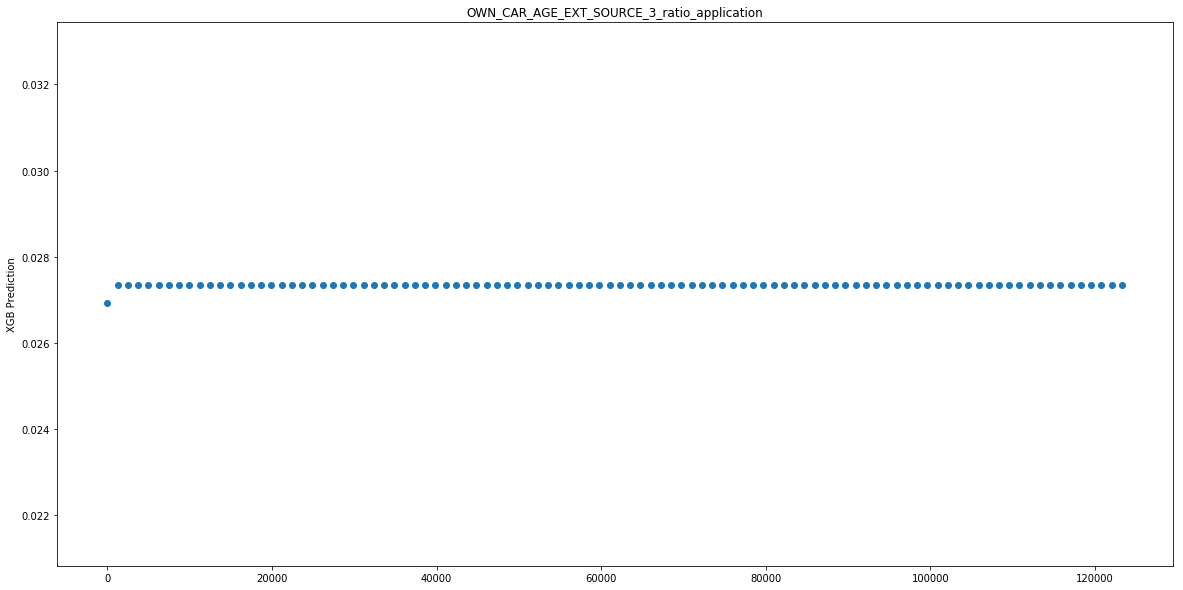

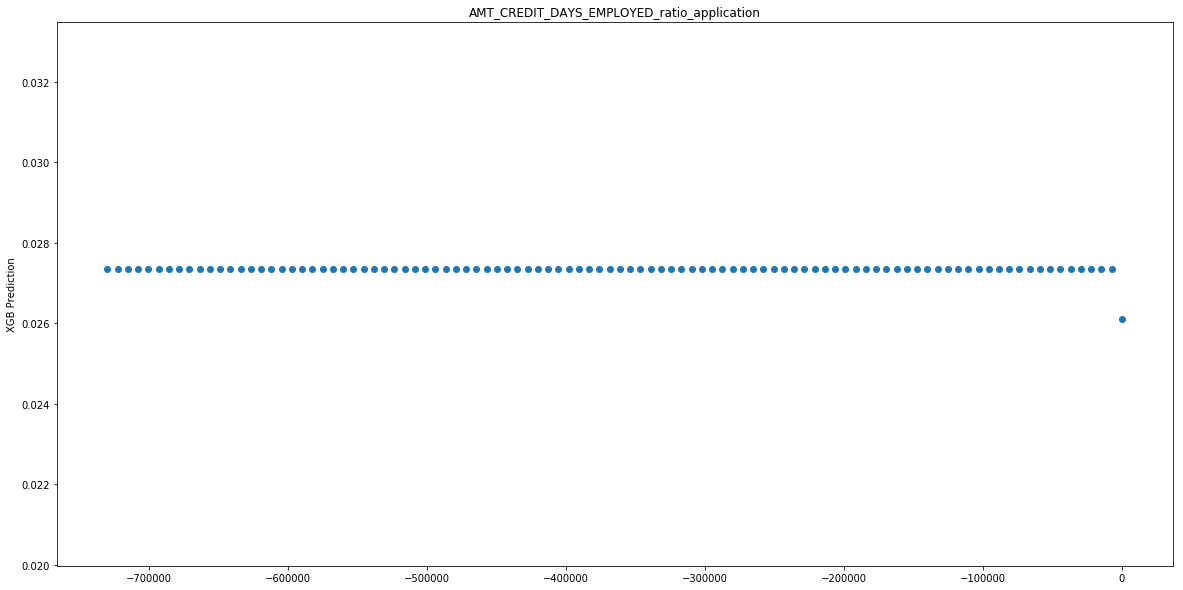

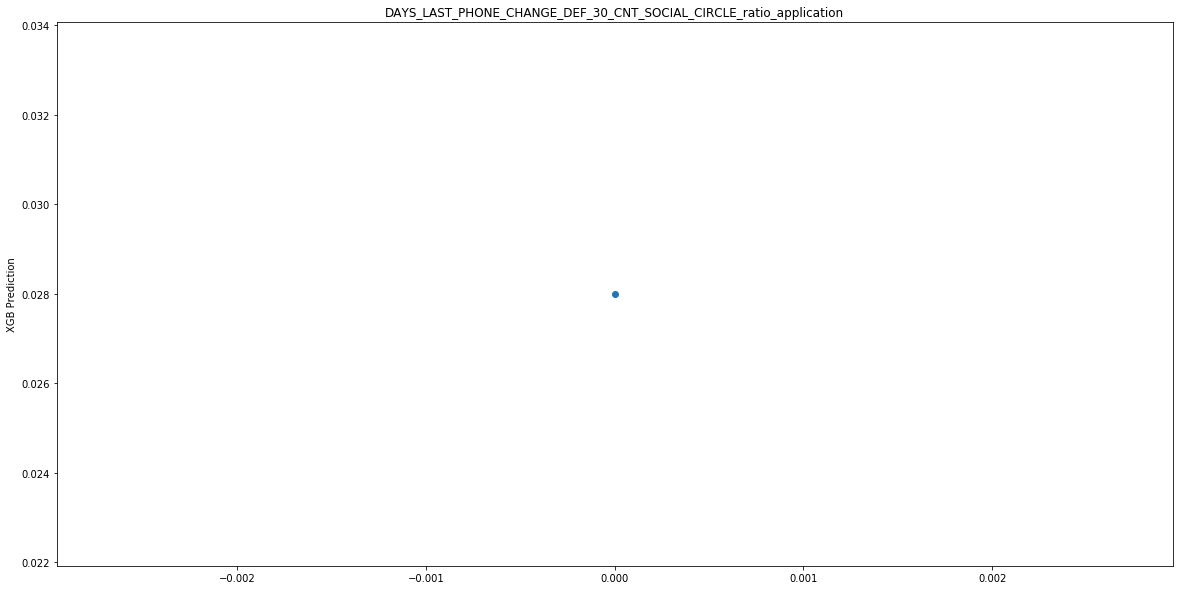

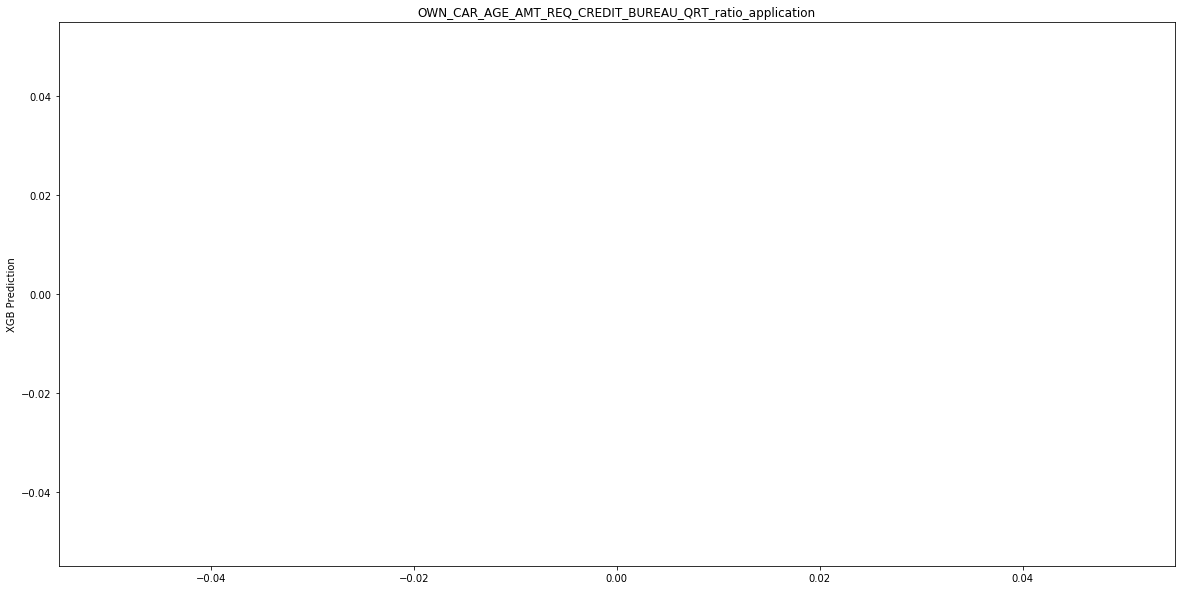

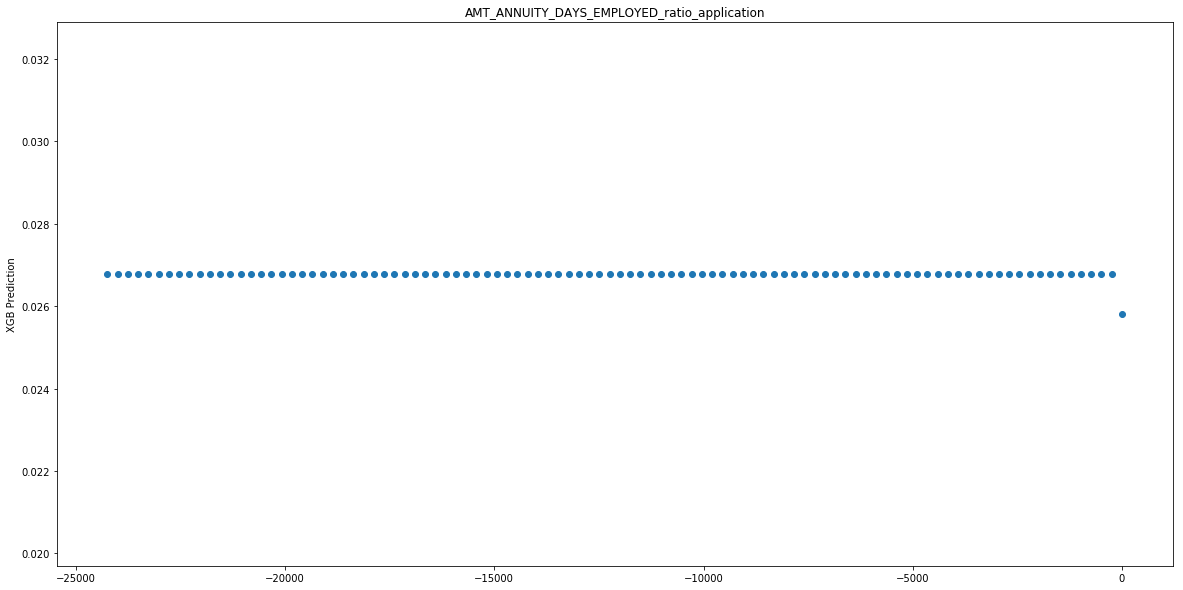

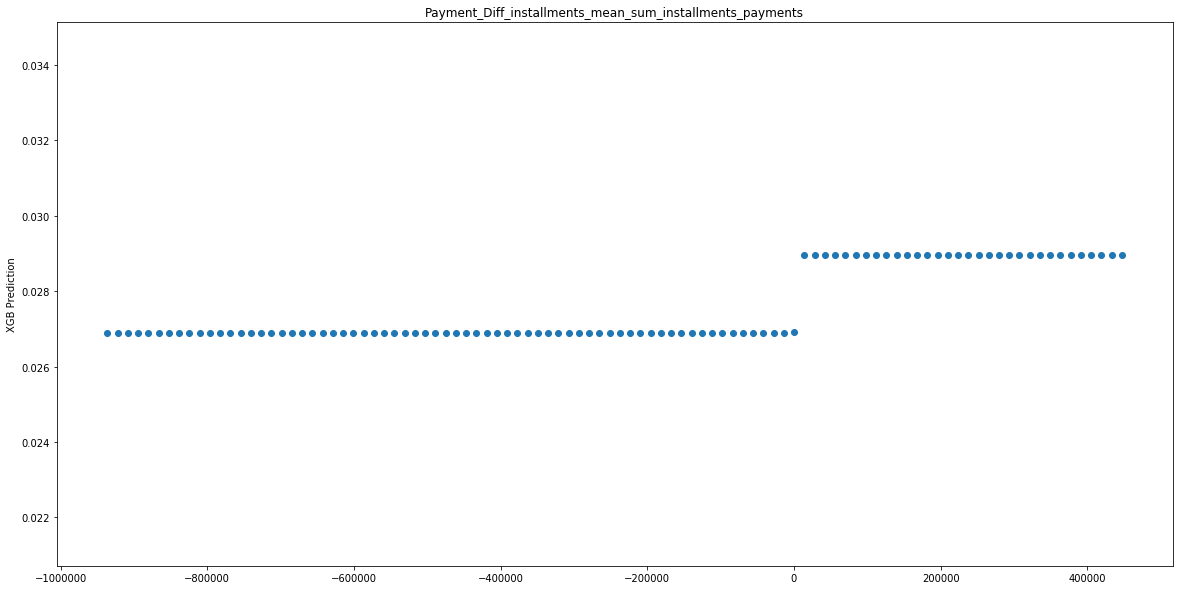

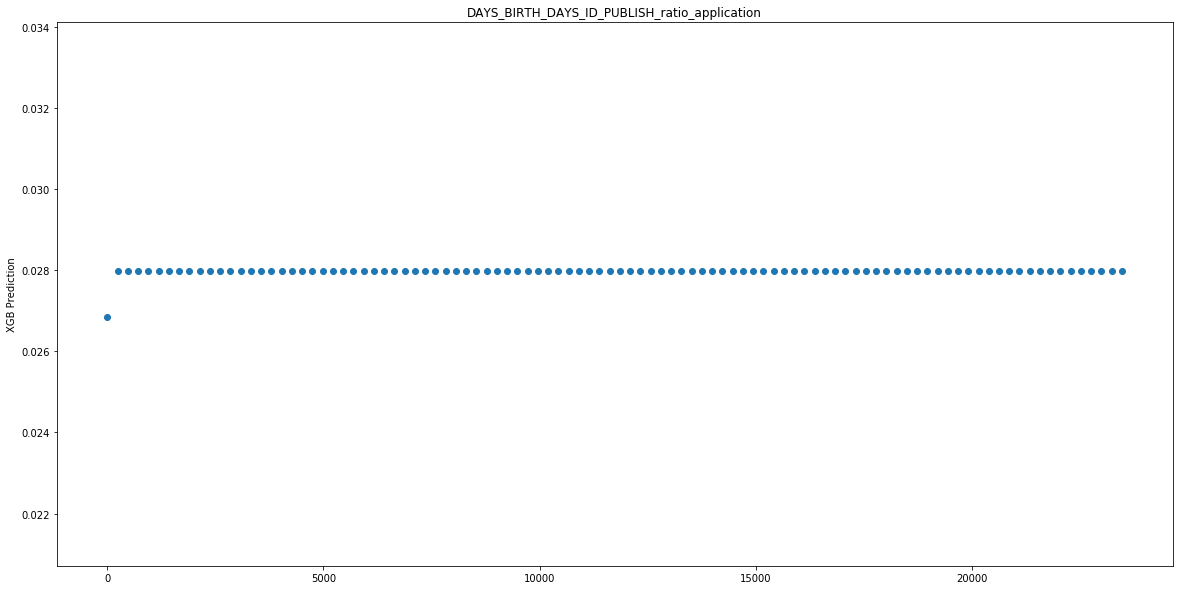

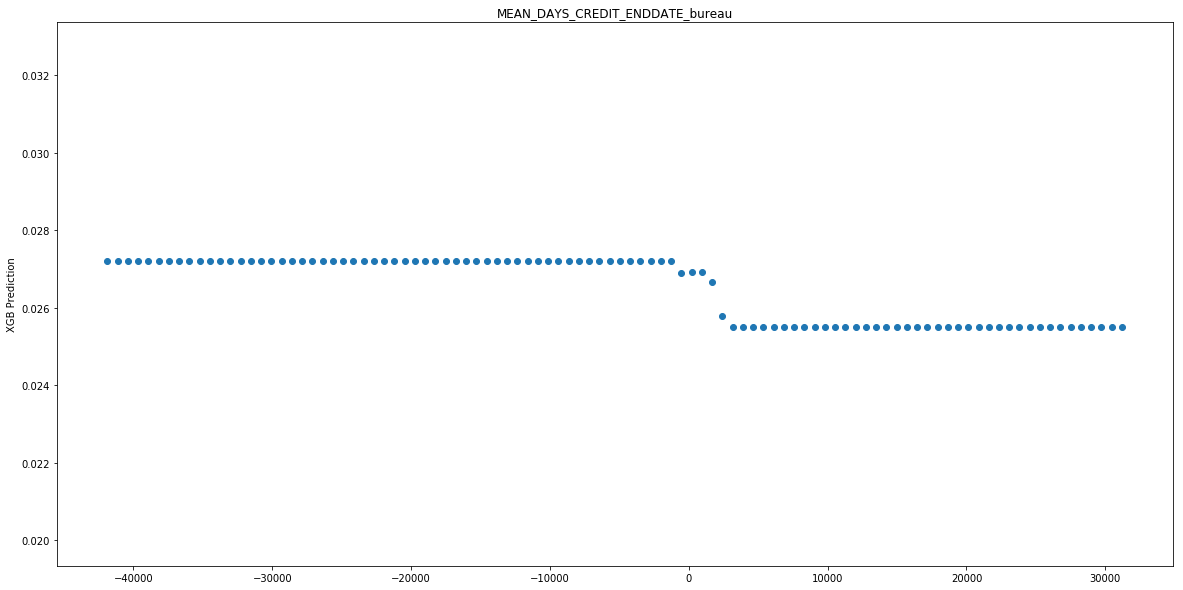

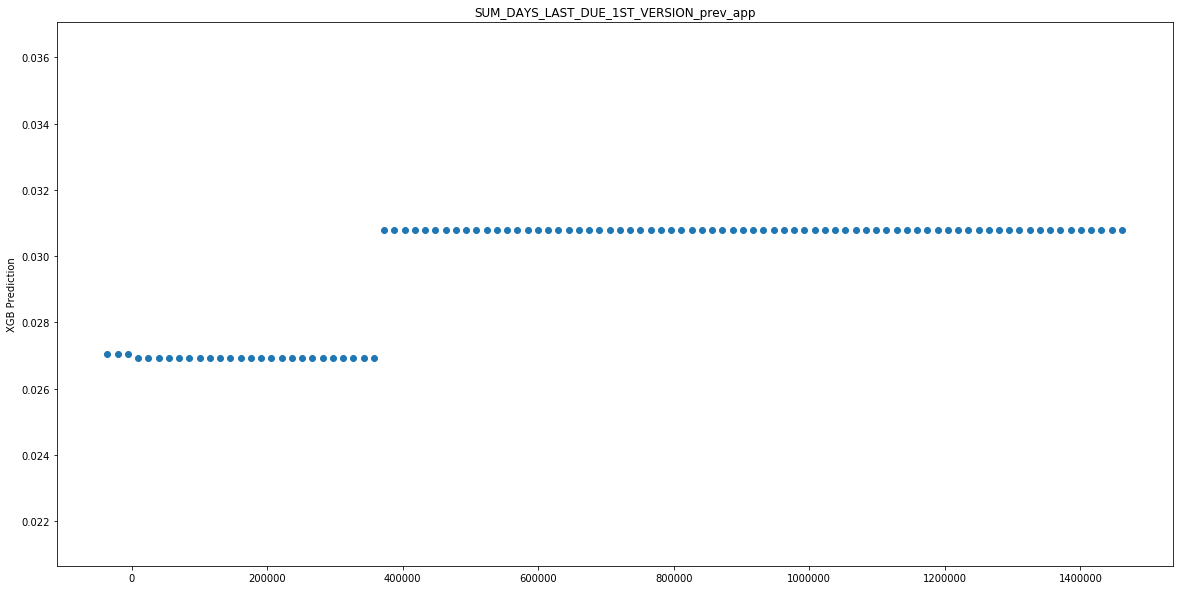

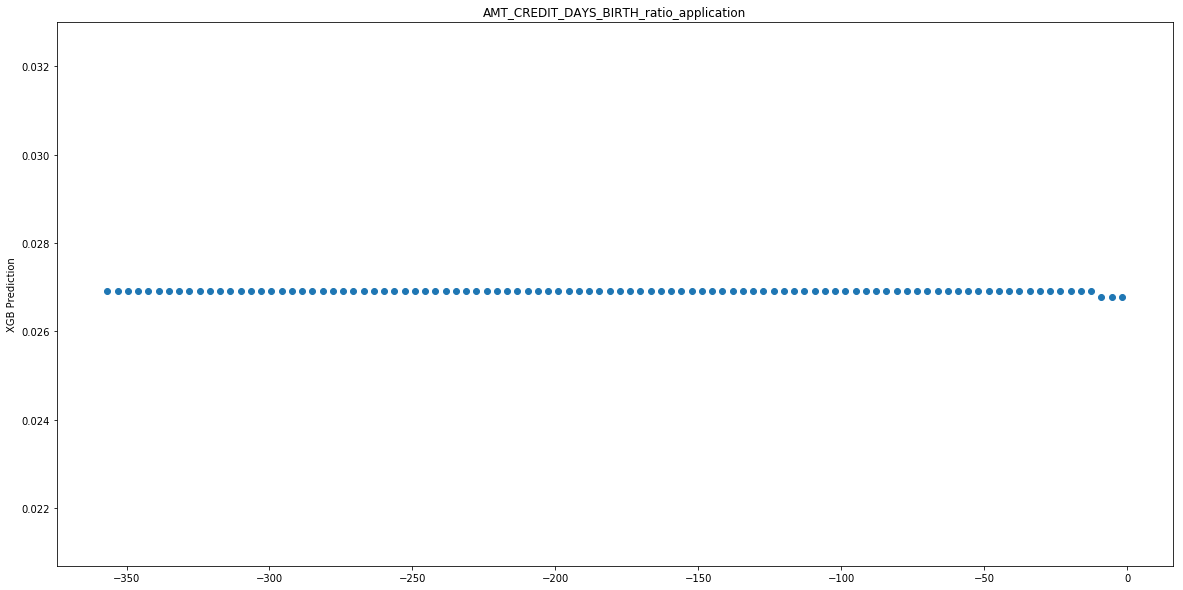

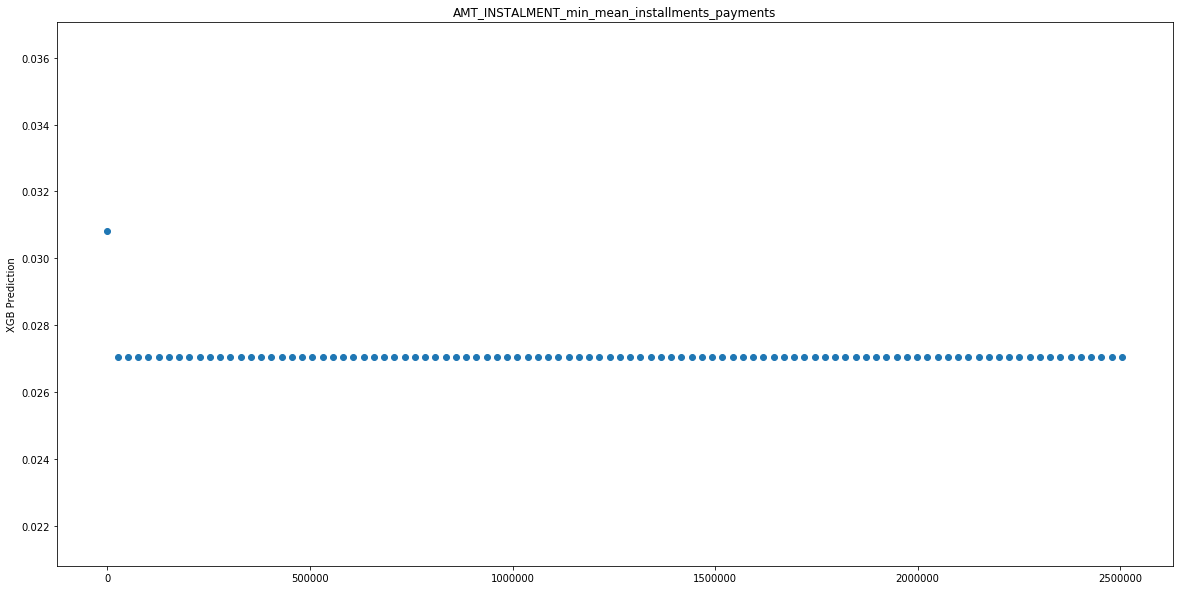

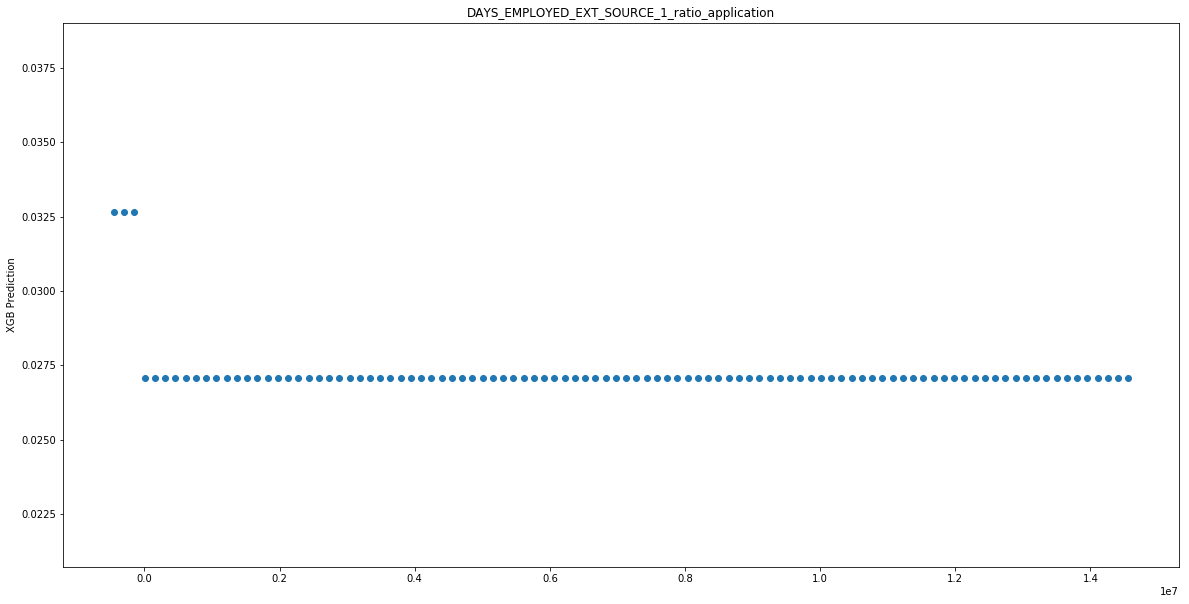

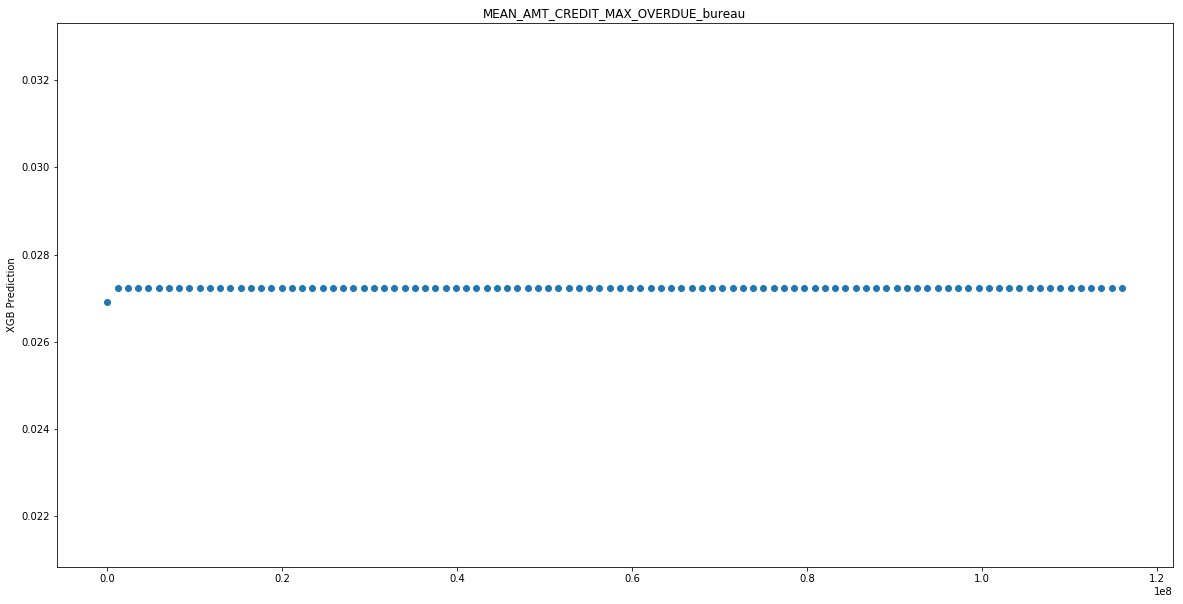

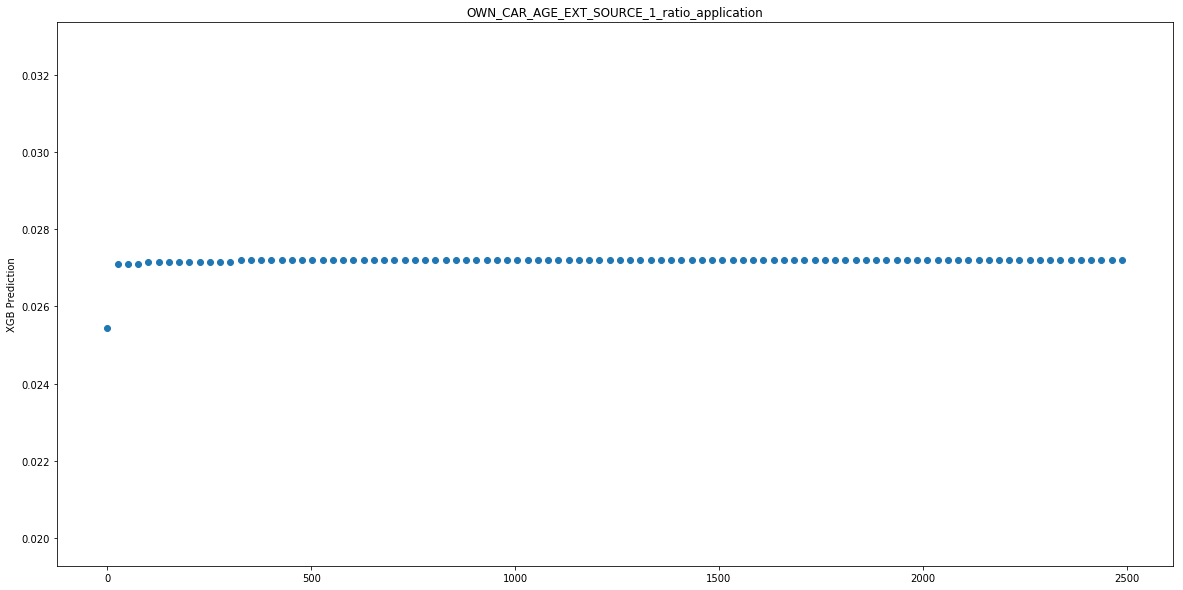

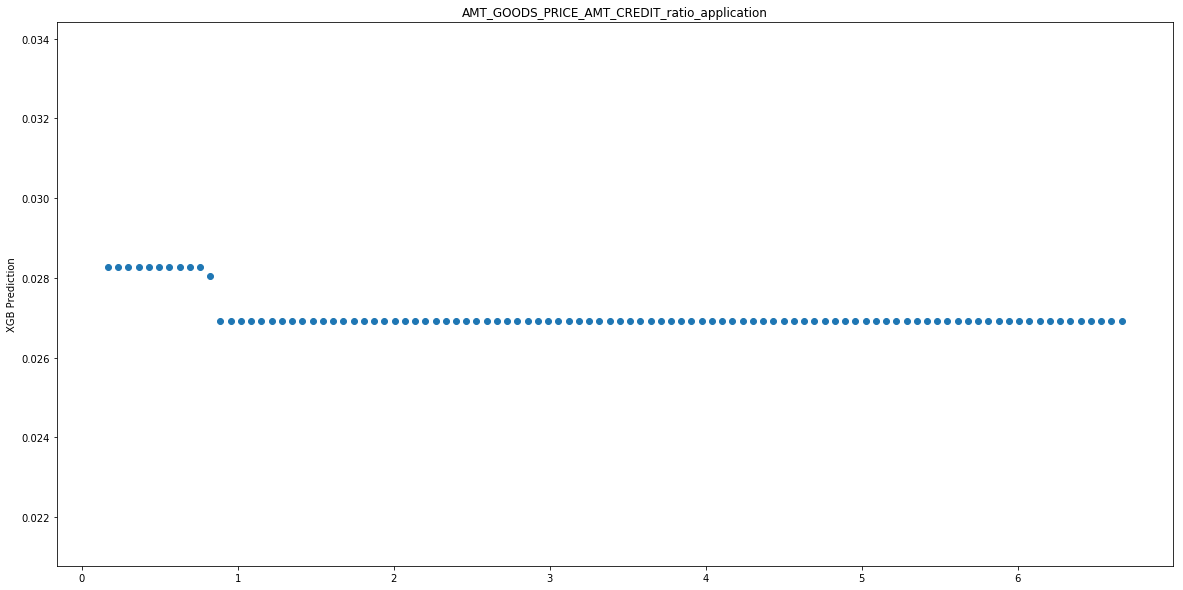

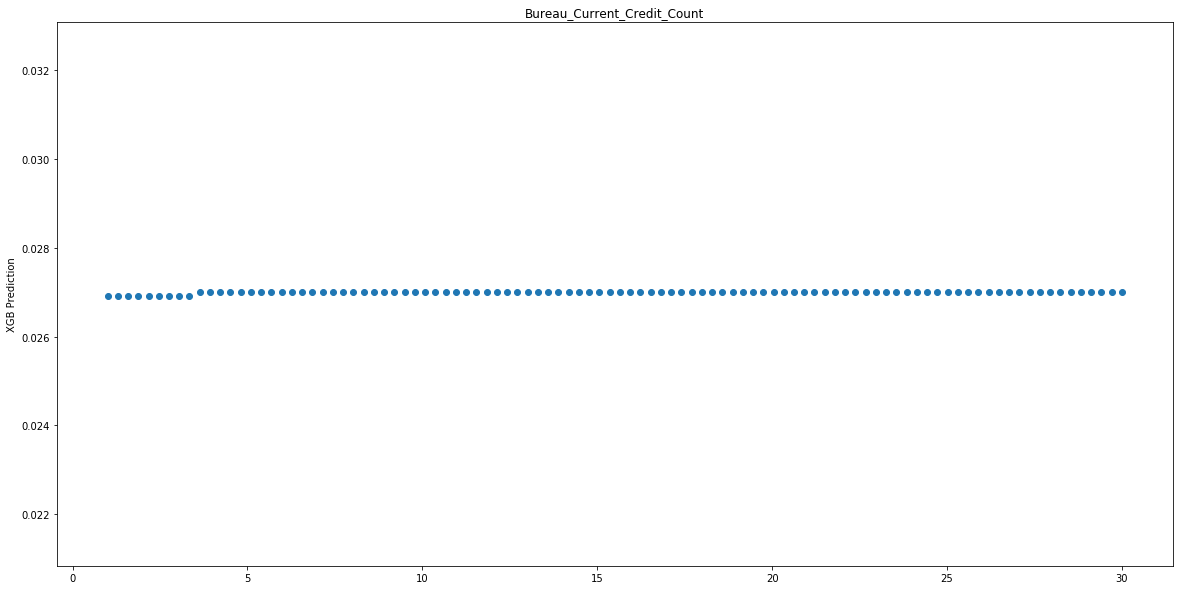

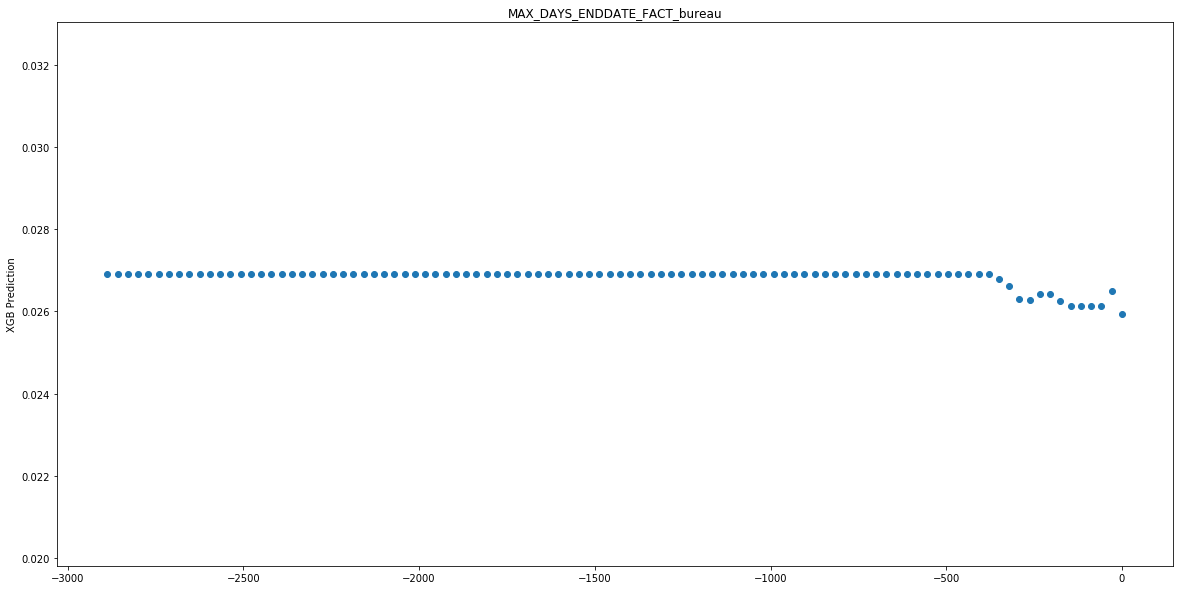

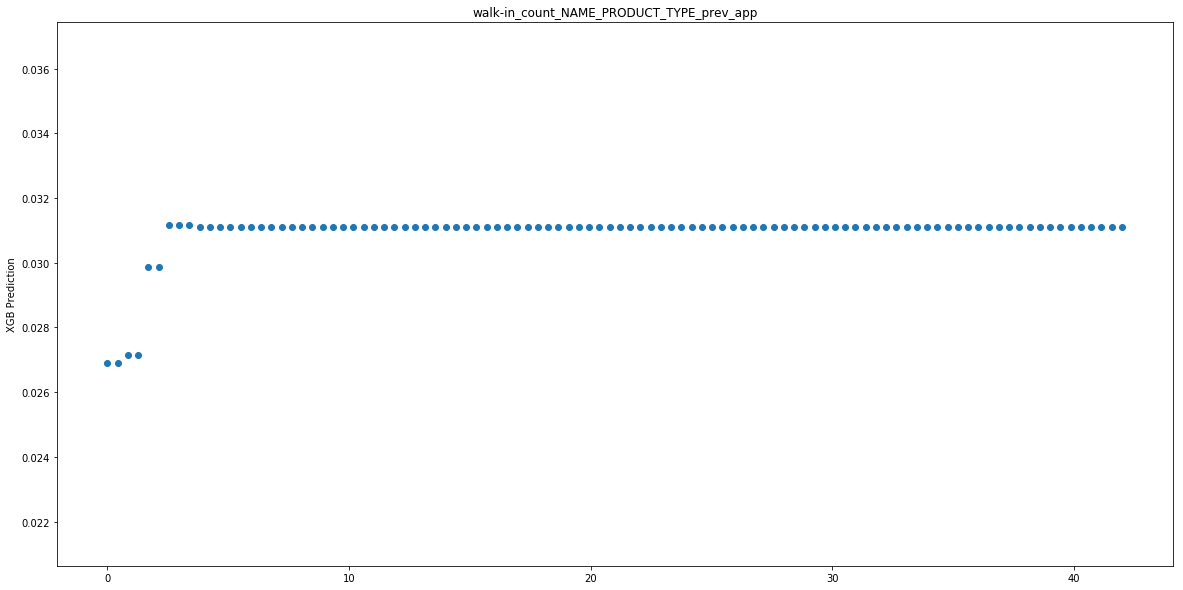

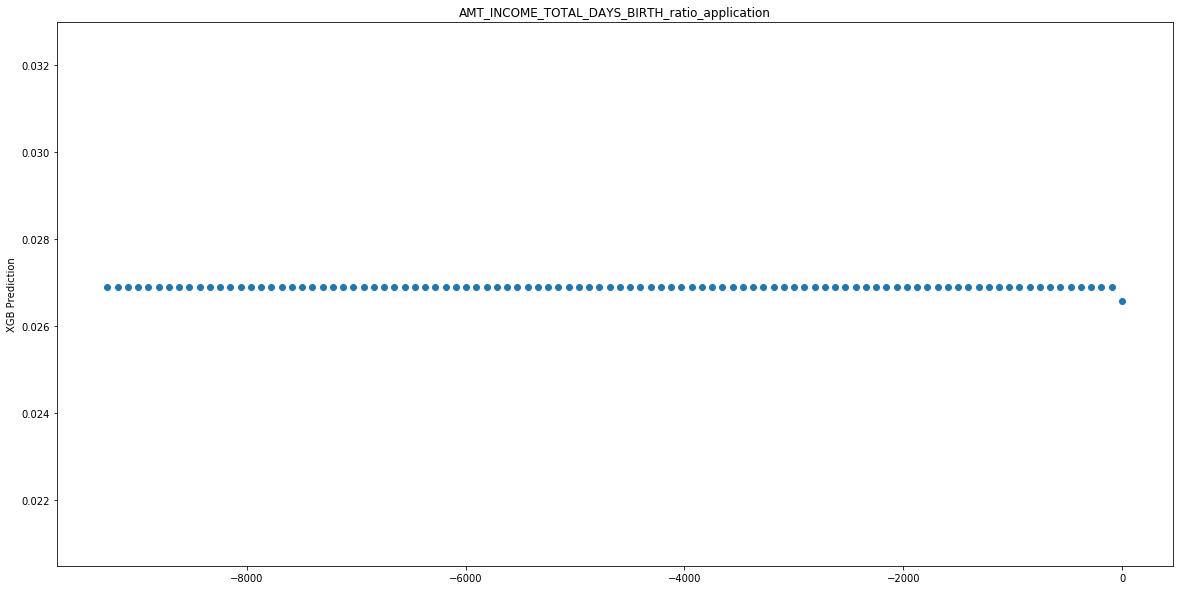

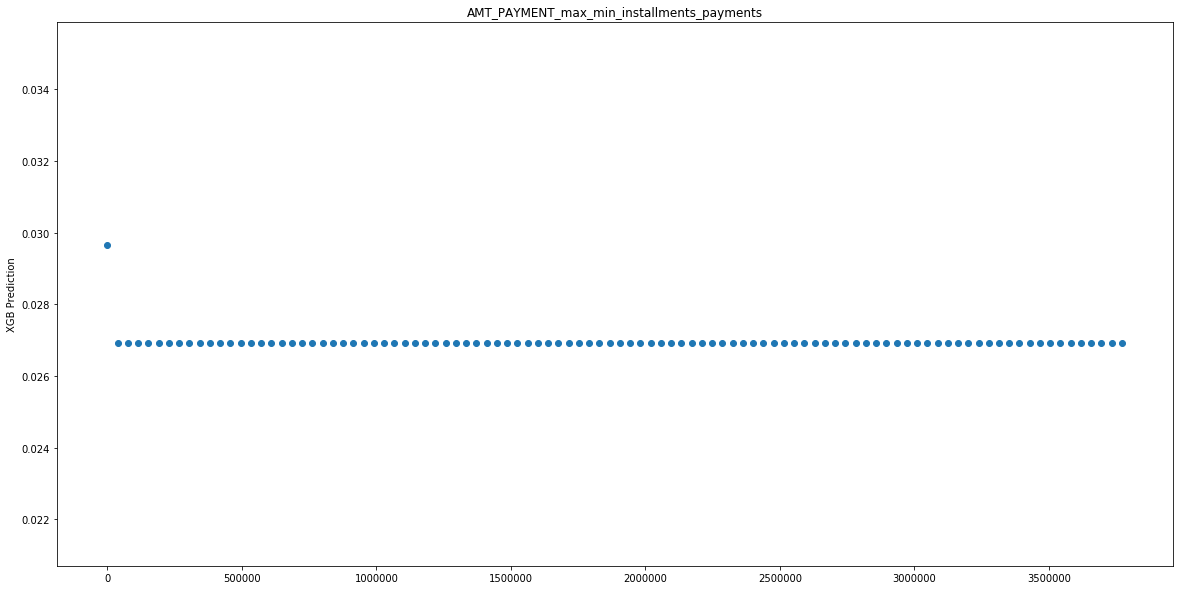

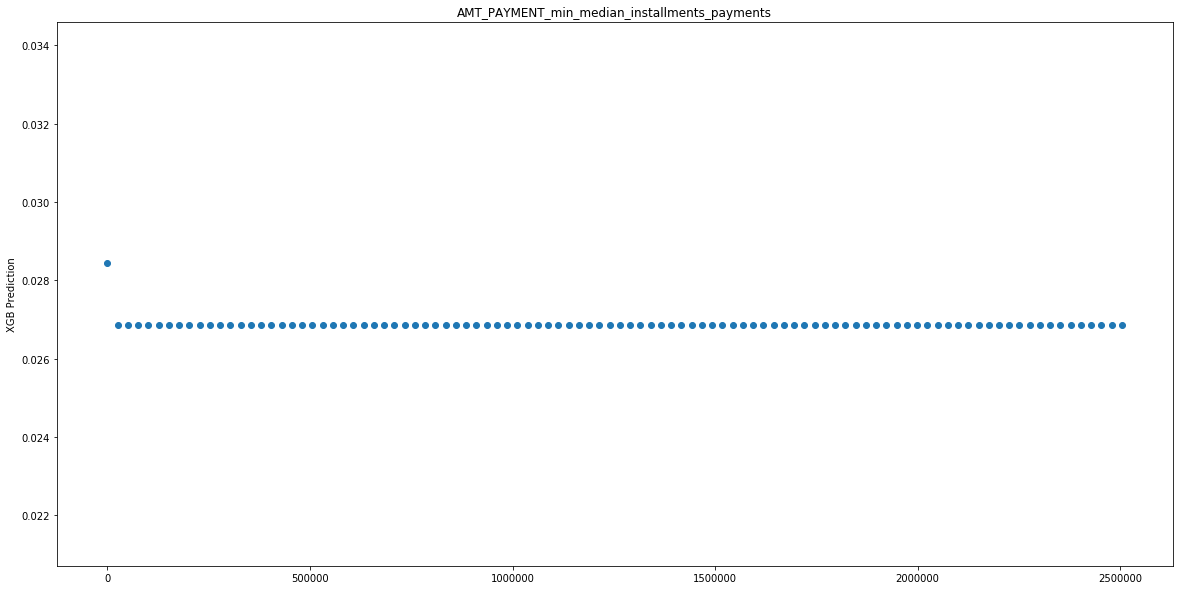

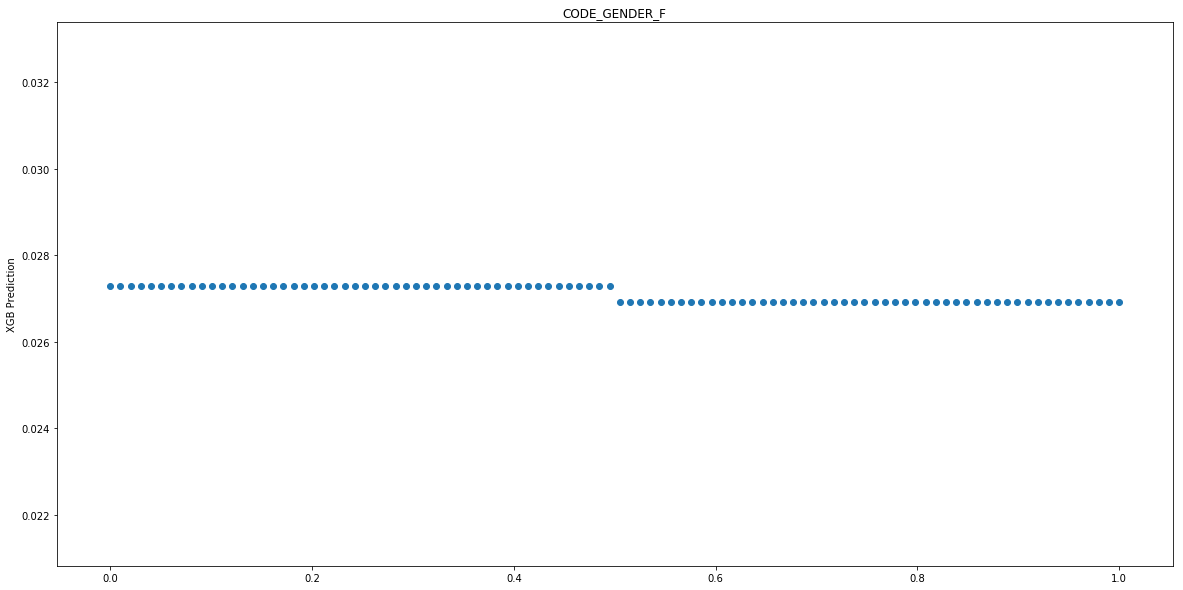

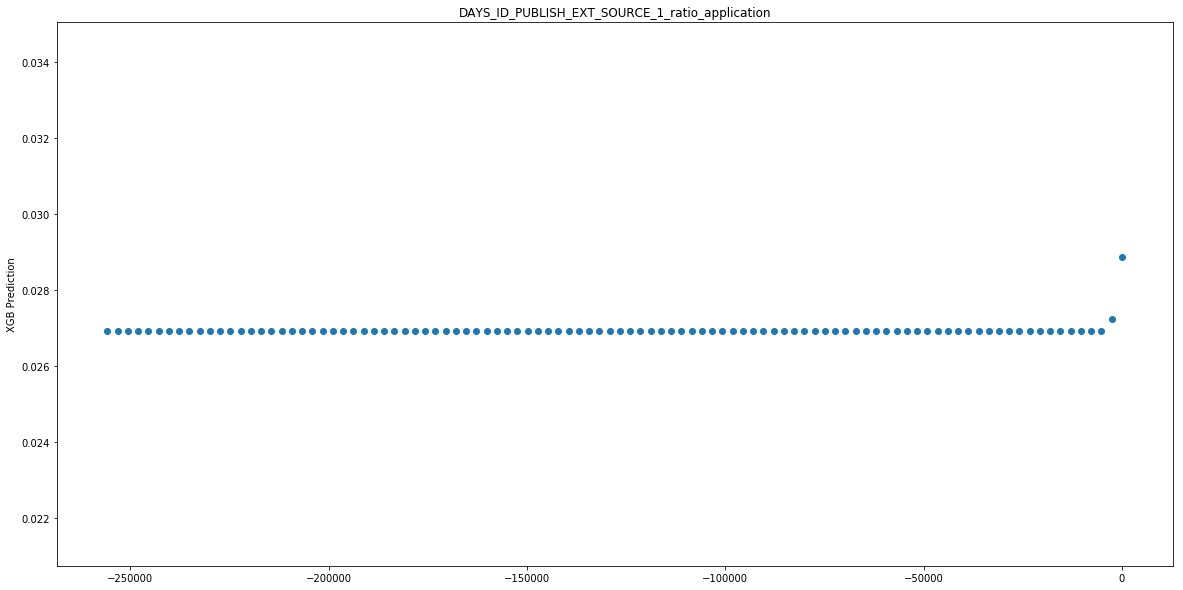

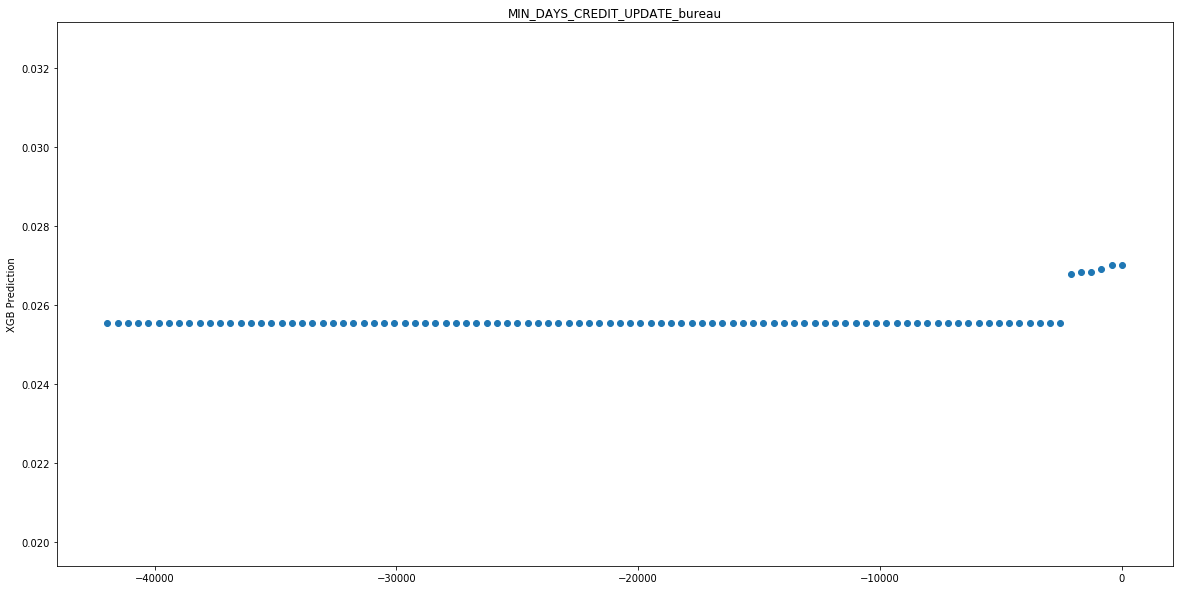

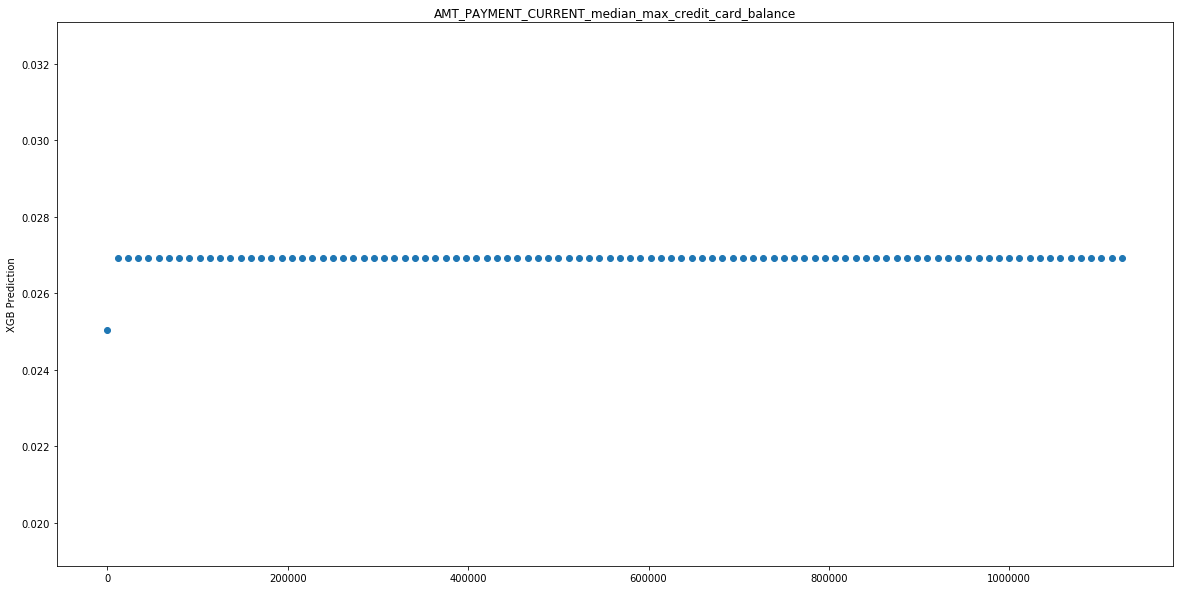

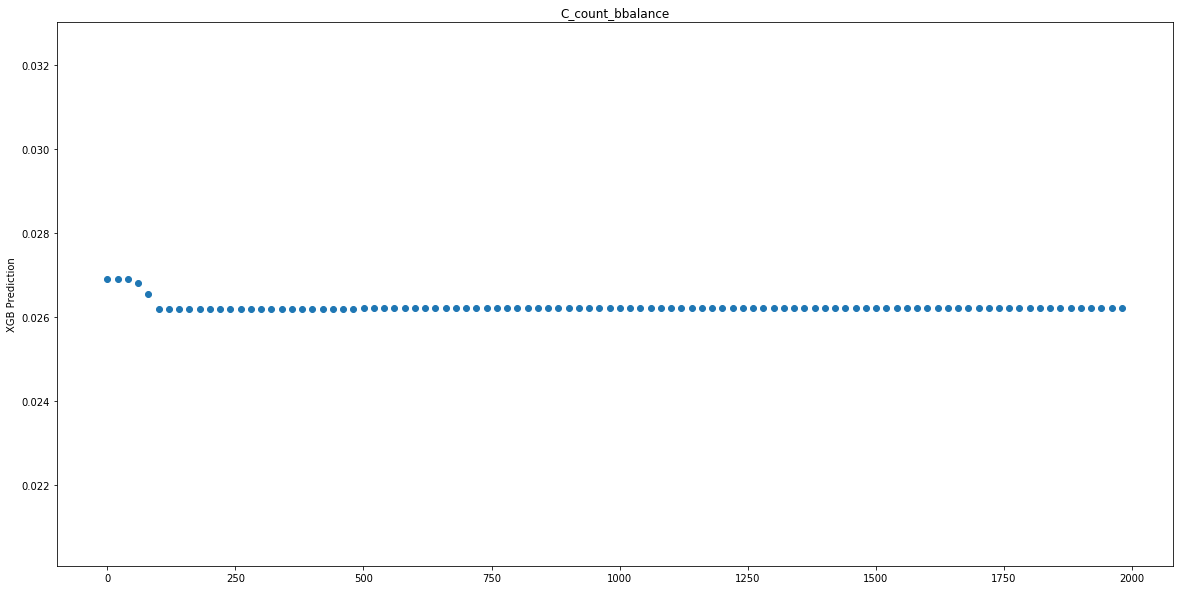

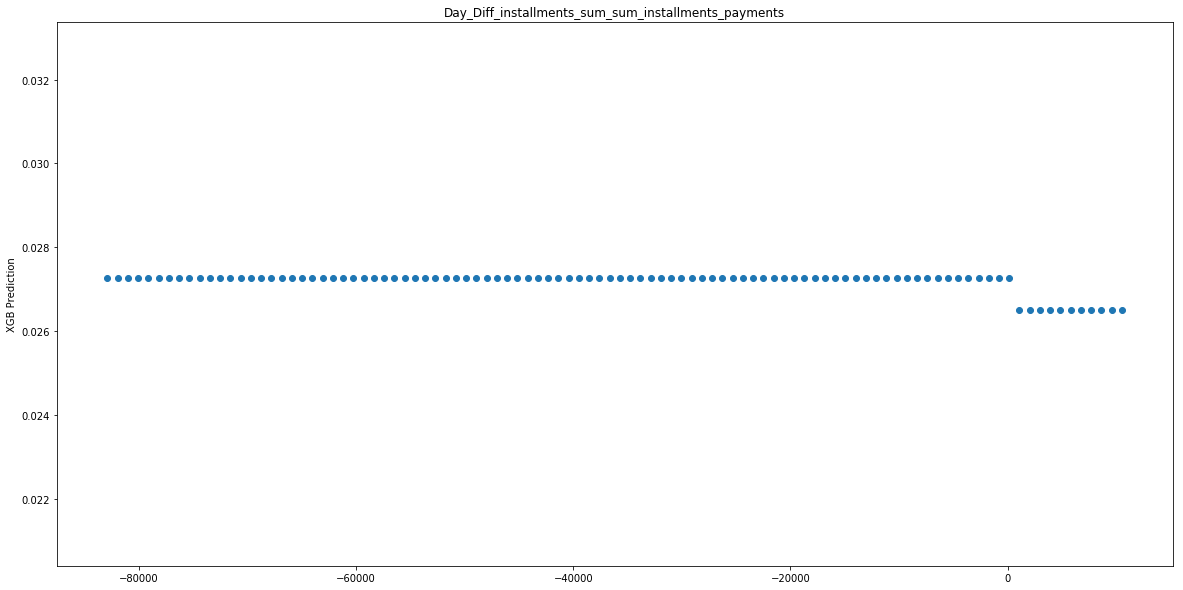

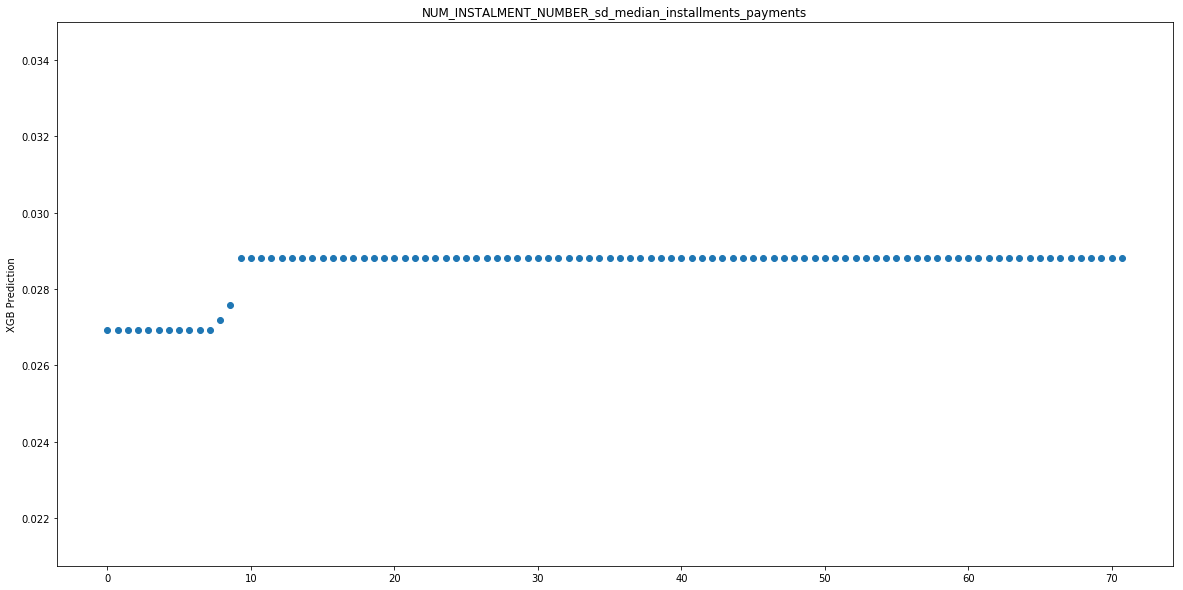

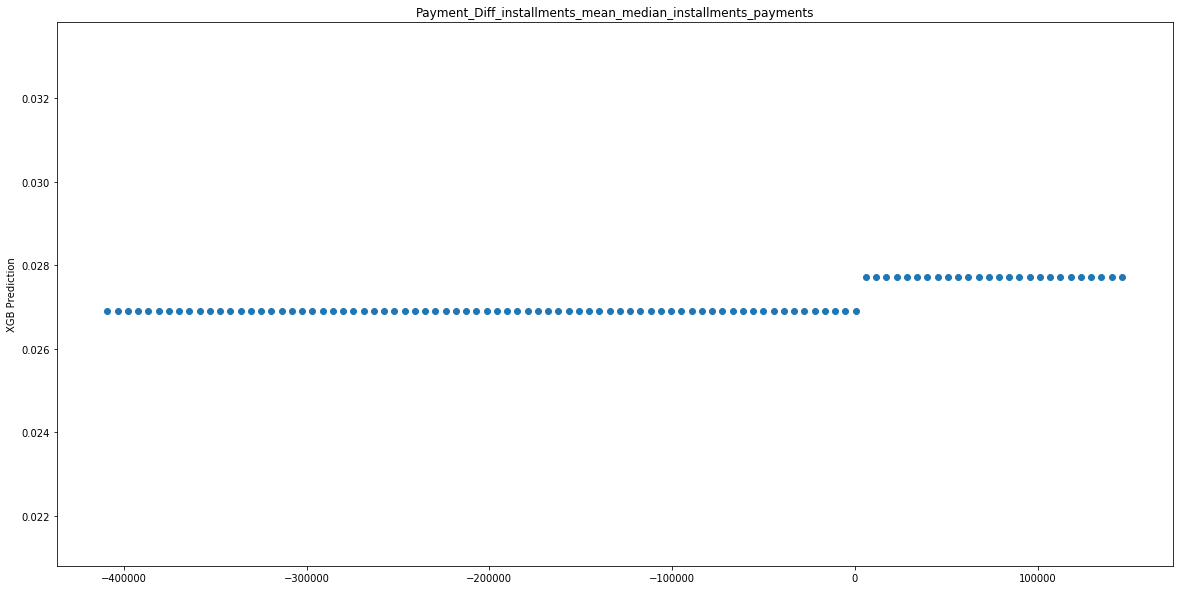

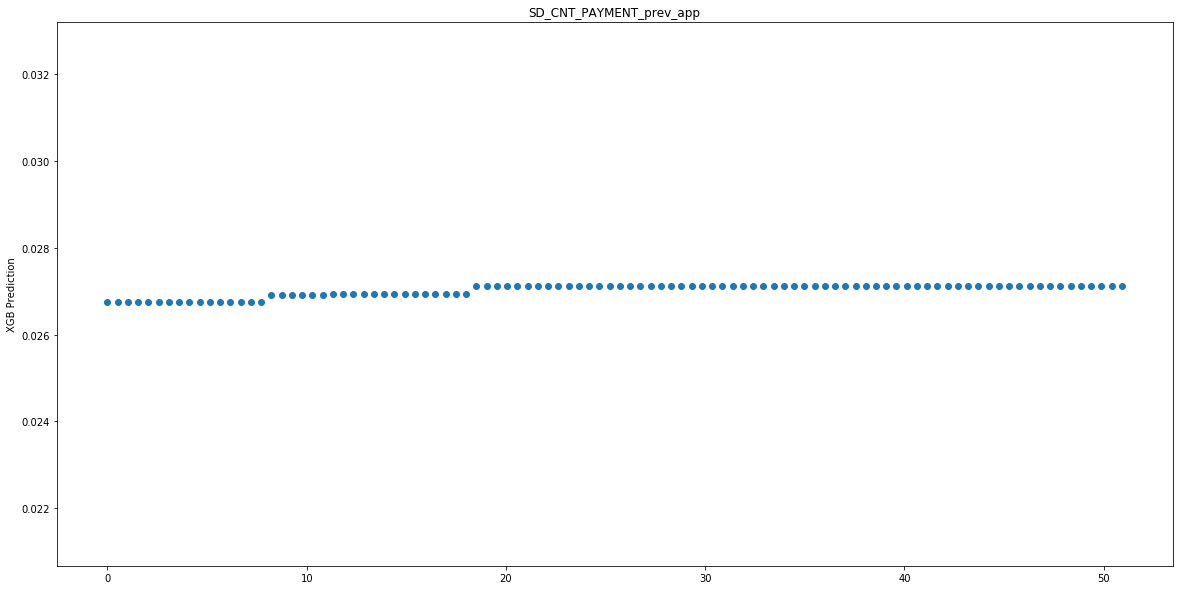

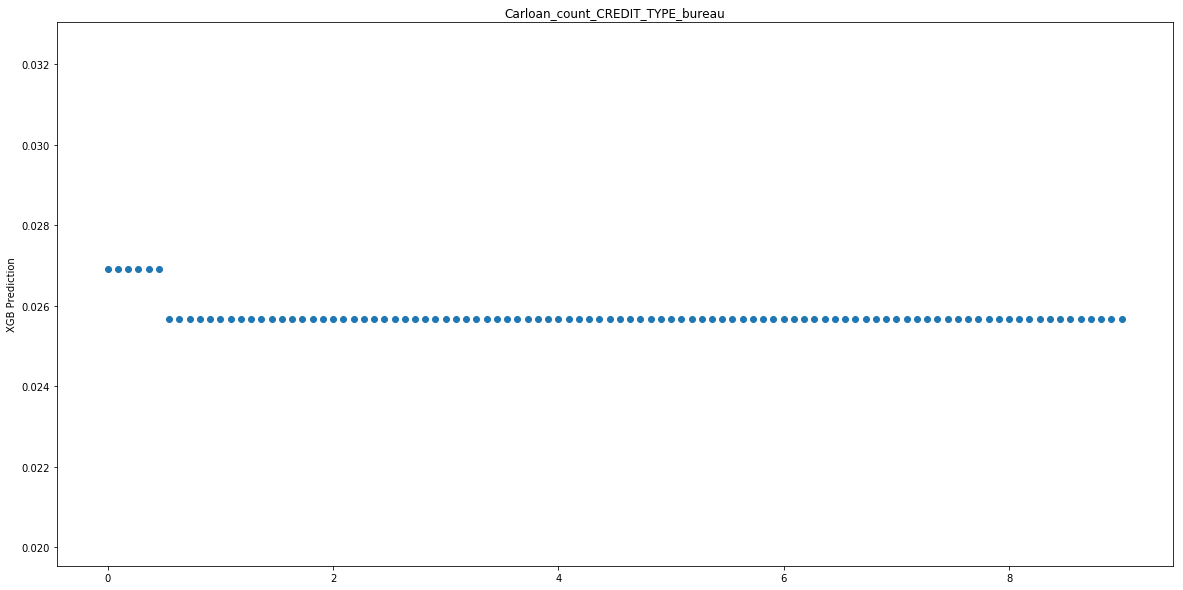

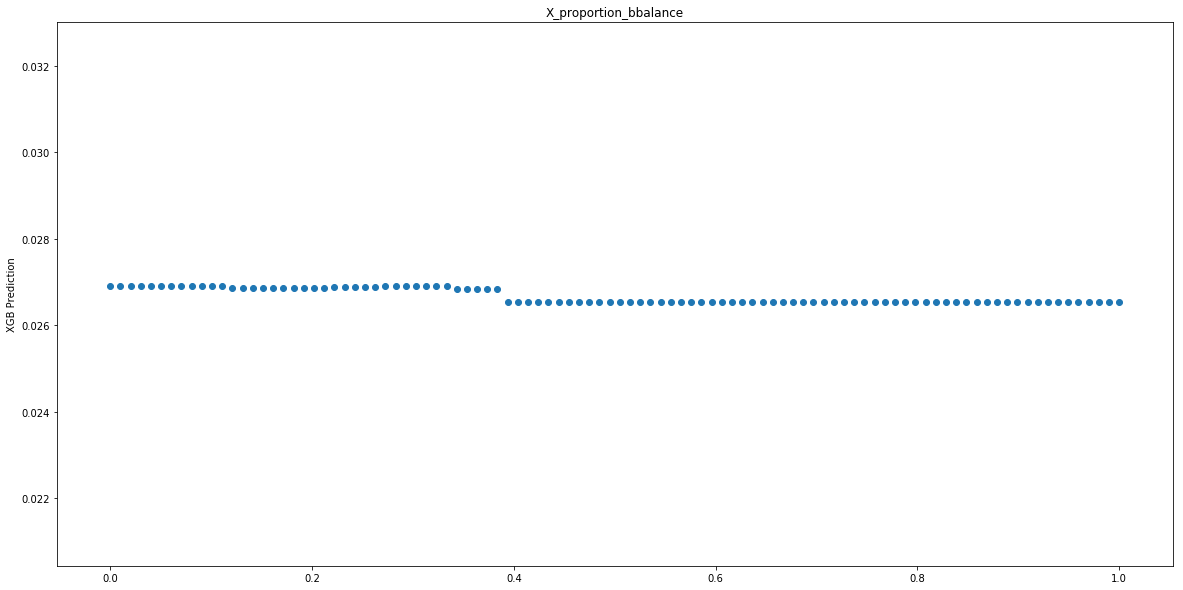

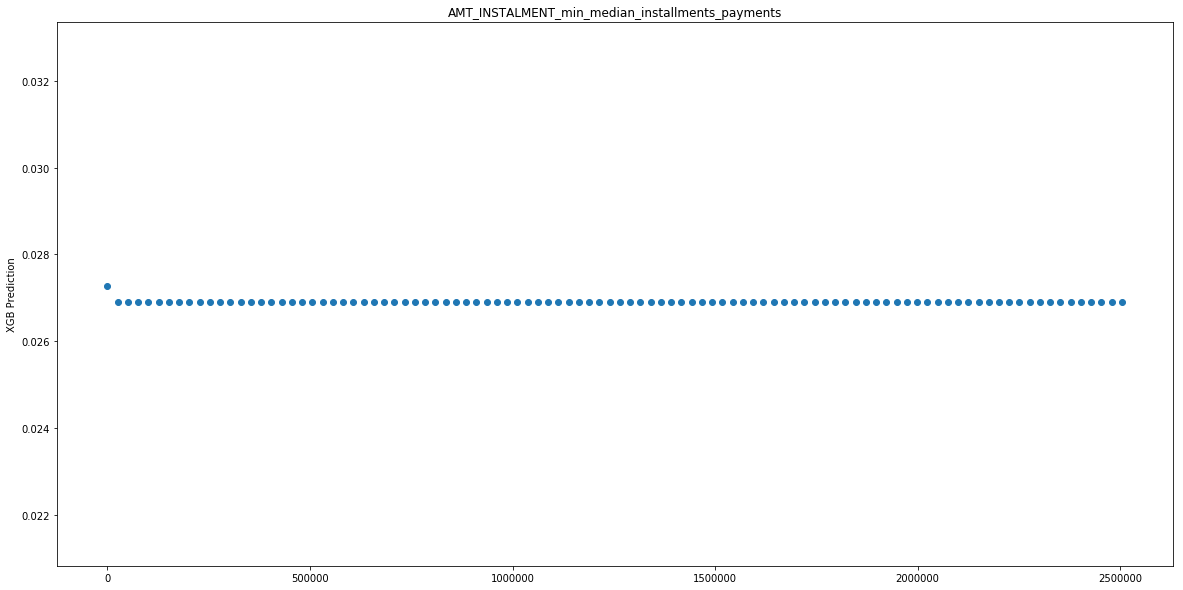

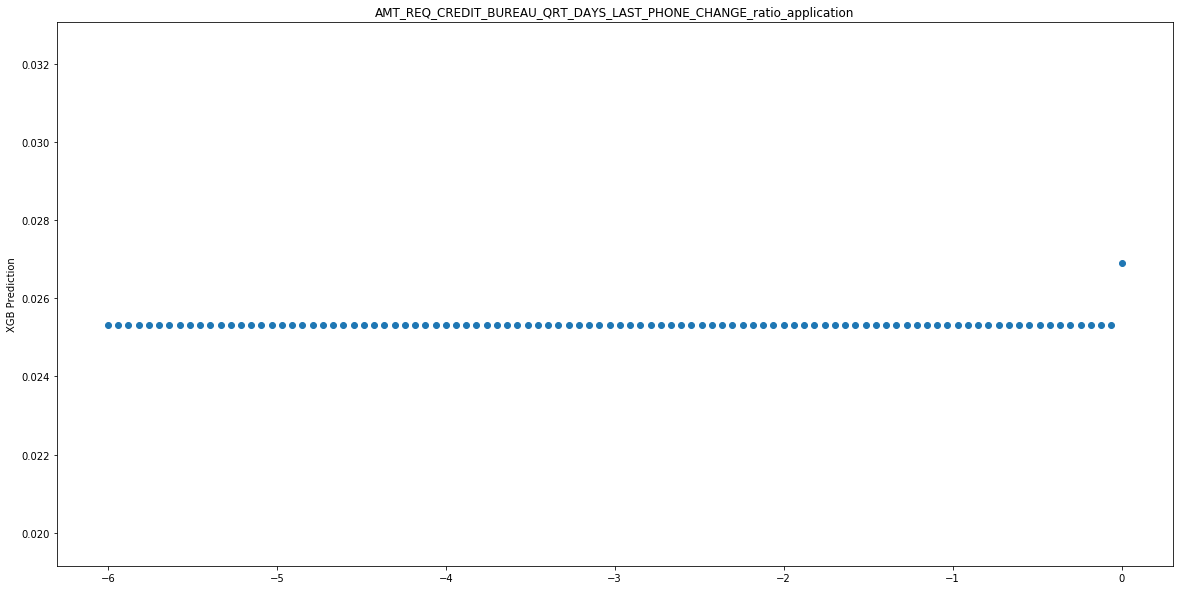

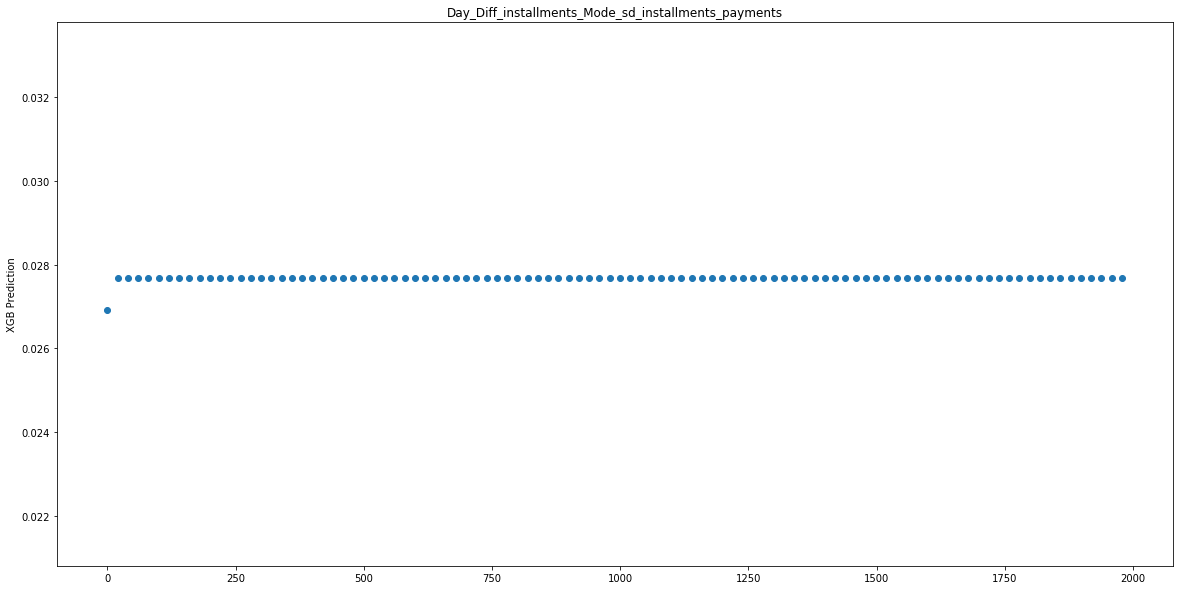

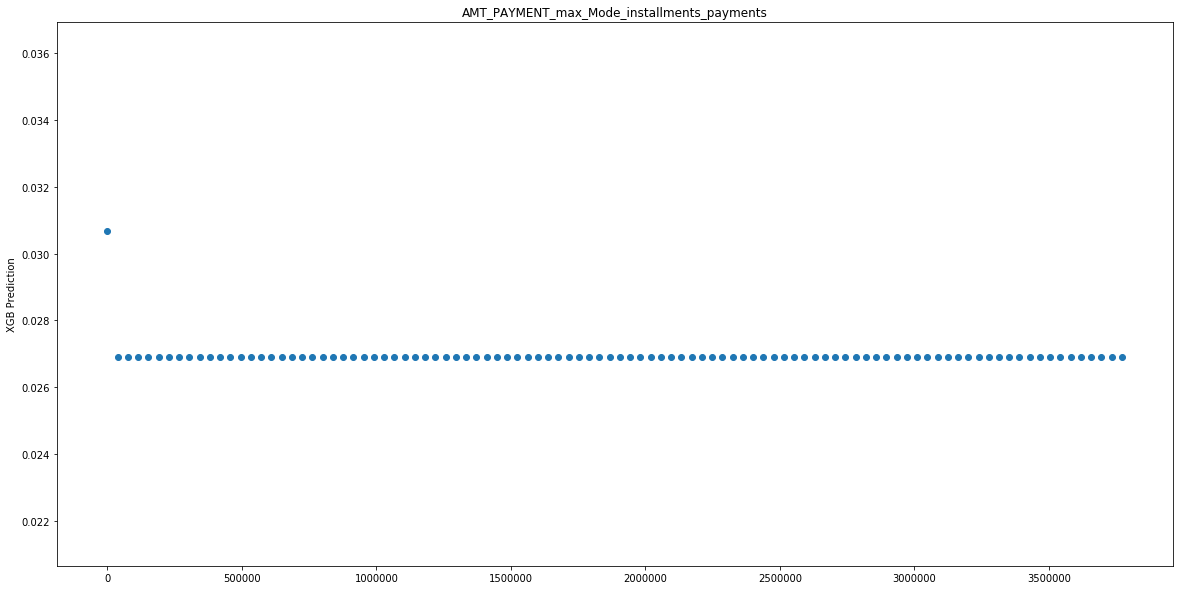

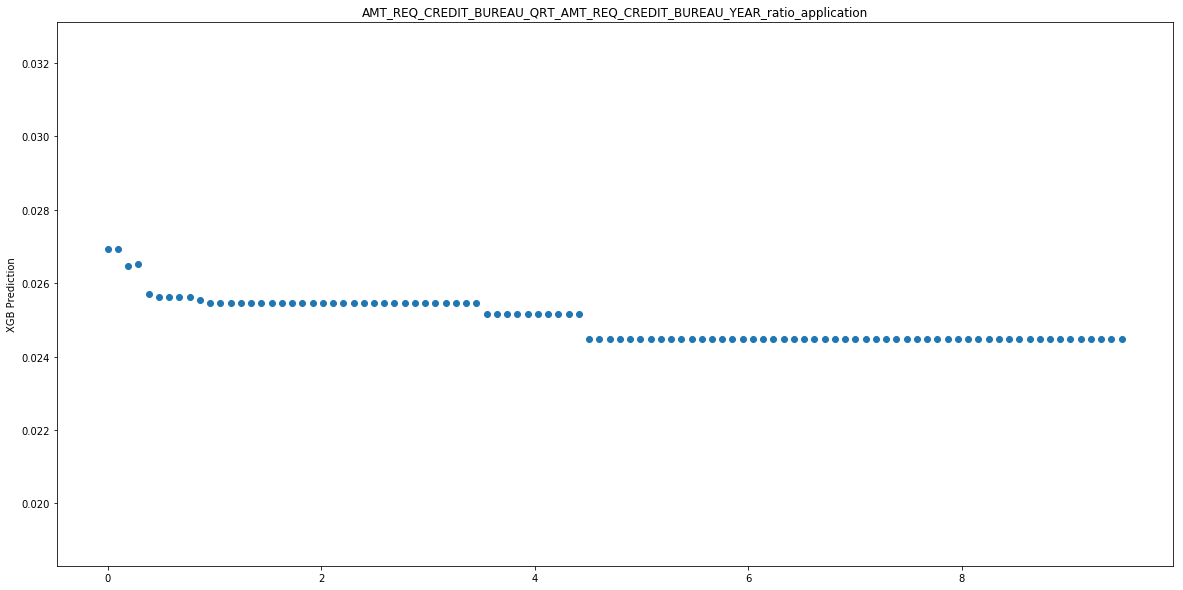

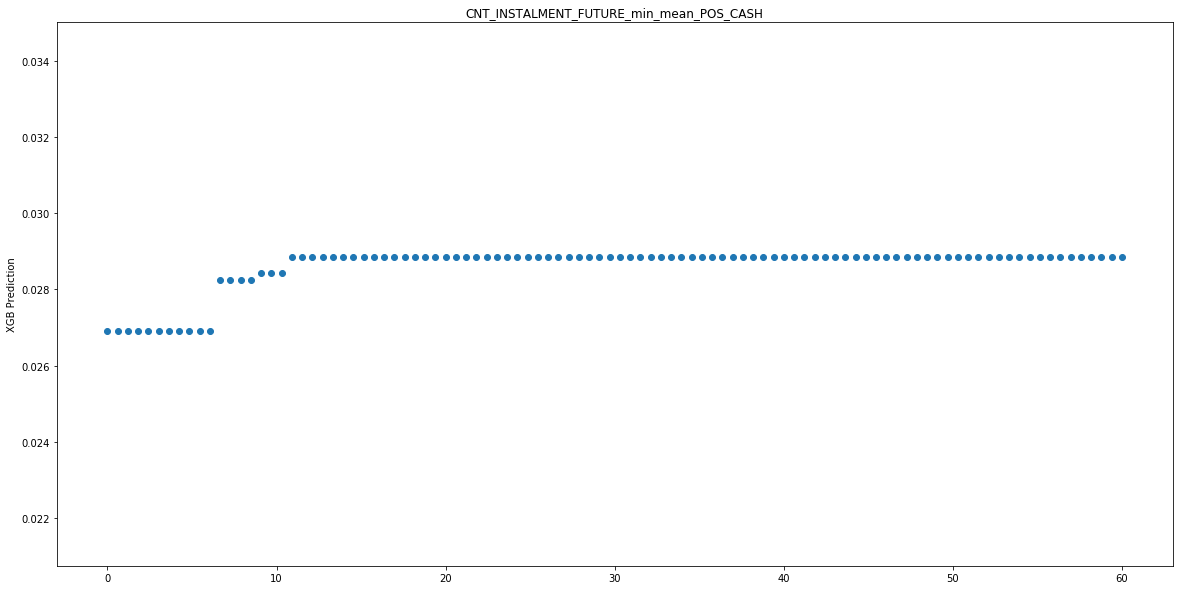

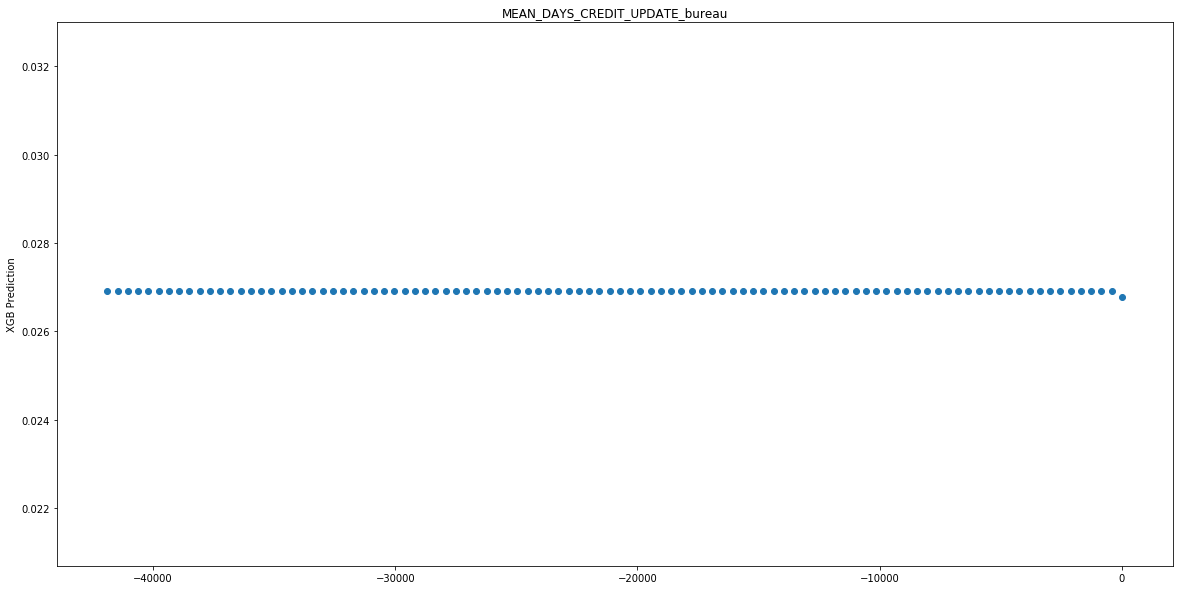

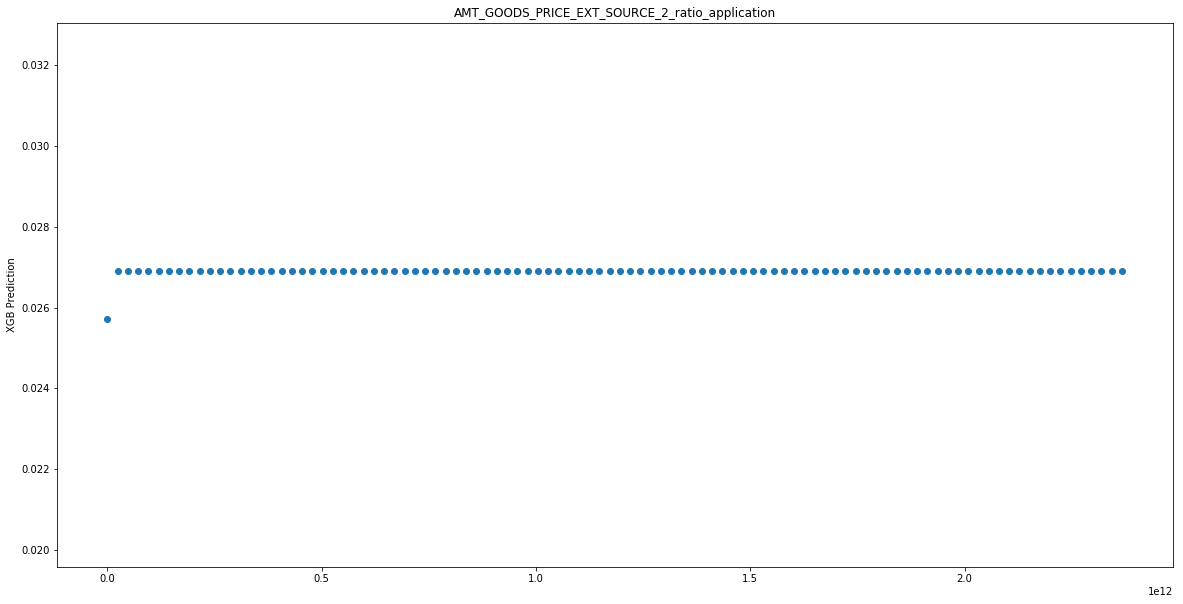

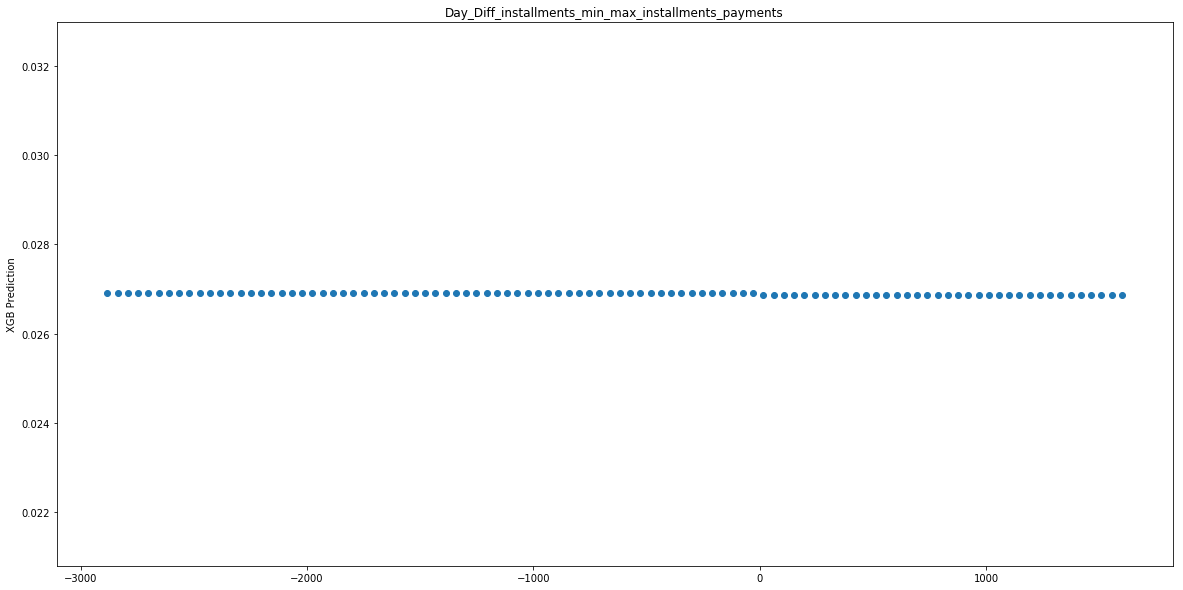

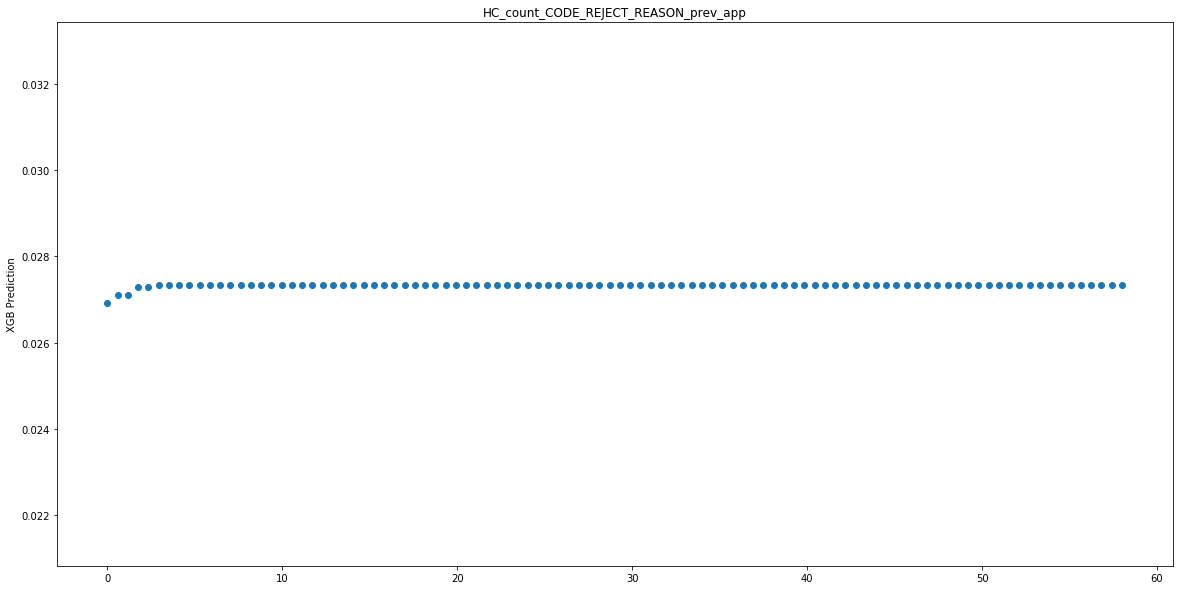

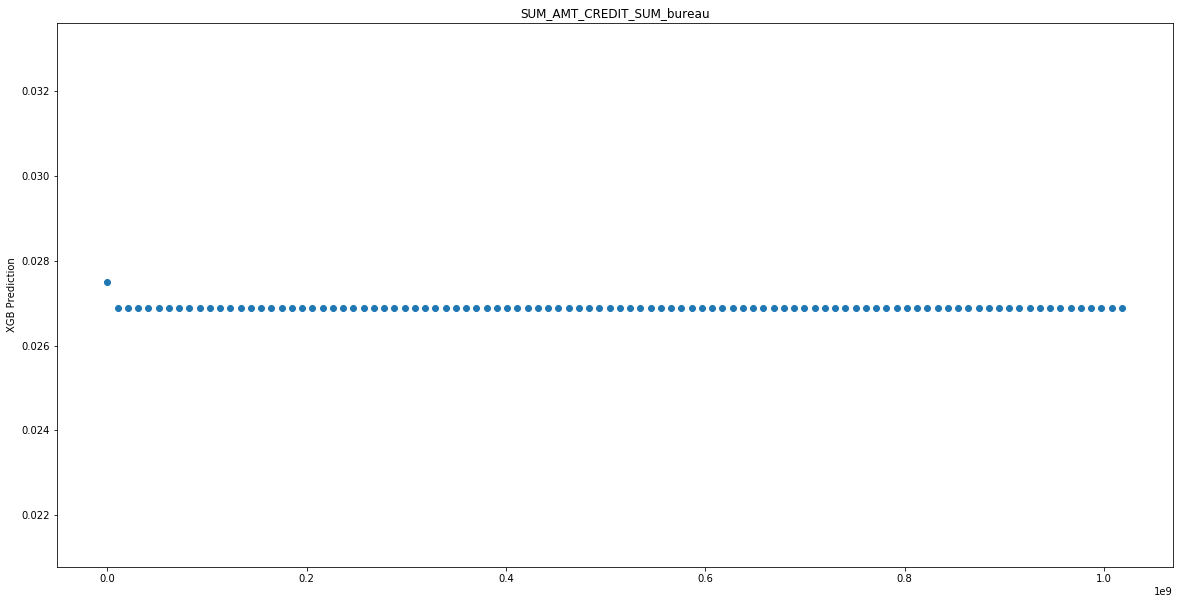

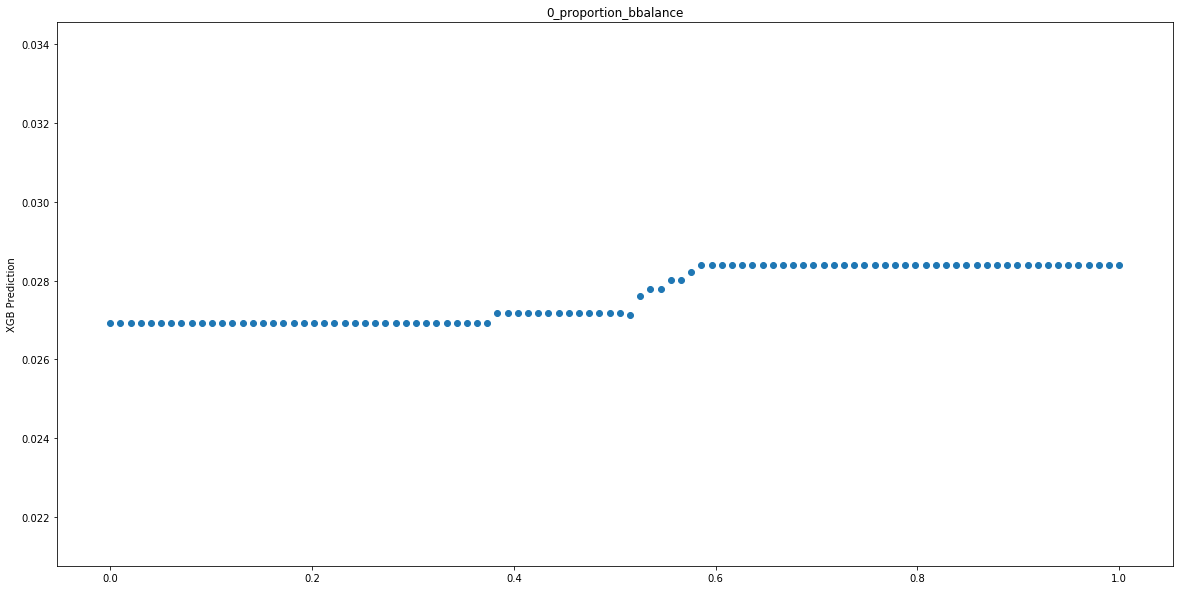

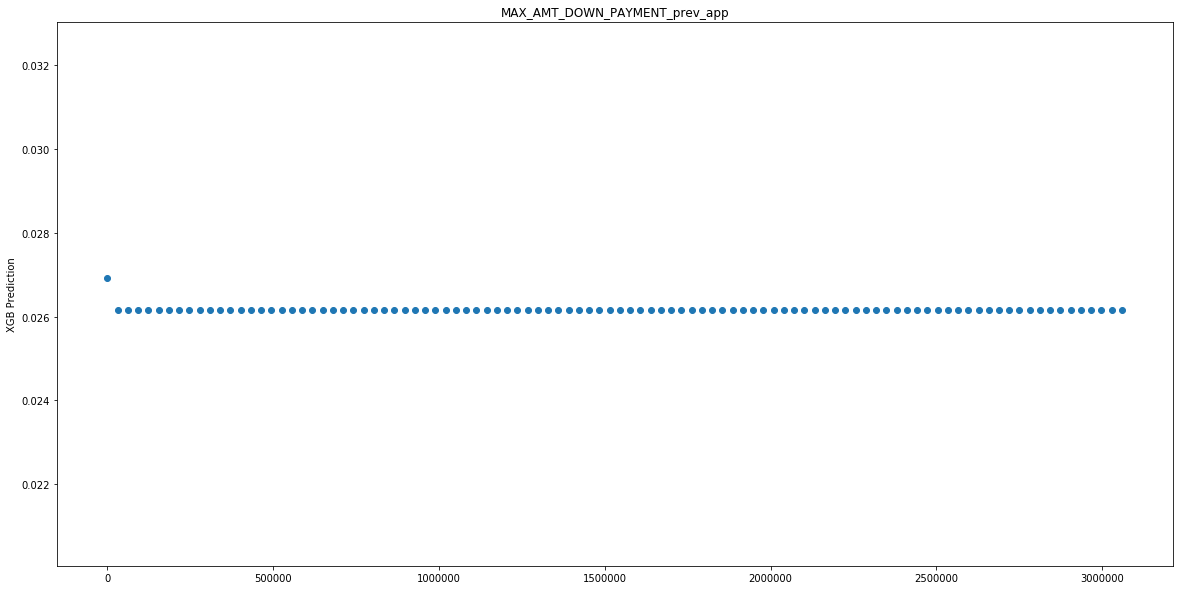

In [83]:
PD_Frame = get_partial_dependence_table(importance_top_1000[0:99])

plt.rcParams['figure.figsize'] = [20, 10]

for i in importance_top_1000[0:99]:
    tmp = PD_Frame.loc[PD_Frame['Batch_Var'] == i,:]
    tmp_DMatrix = xgb.DMatrix(data = tmp.drop(columns = ['Batch_Var', 'fold', 'TARGET', 'Weights', 'SK_ID_CURR']))
    preds = Trained_Model.predict(tmp_DMatrix)
    plt.scatter(x= tmp[i], y = preds)
    plt.ylabel('XGB Prediction')
    plt.title(i)
    plt.show()


